# R Notebook: Wet State and Spell Length Distributions

Wet state, spell length for PRISM data.

Uses R to do some analysis

Add in the part to make a DataFrame with our best fit negative binomial parameters and then to output this to a spreadsheet

## Parameters and Library Loading

In [1]:
library(feather)
library(dplyr)
library(fitdistrplus)
library(vcd)
library(dgof)
library(xlsx)
library(r2excel)

Warning message:
"package 'feather' was built under R version 3.6.1"Warning message:
"package 'dplyr' was built under R version 3.6.1"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'fitdistrplus' was built under R version 3.6.1"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Warning message:
"package 'vcd' was built under R version 3.6.1"Loading required package: grid

Attaching package: 'dgof'

The following object is masked from 'package:stats':

    ks.test



**Note:** We only want to mask package:stats ks.test with that from package:dgof when working with discrete distributions.

In [2]:
setwd("//augustine.space.swri.edu/jdrive/Groundwater/R8937_Stochastic_CC_Recharge/Data/R/Working")

Now specify some parameters - just file names

In [3]:
feWPath <- "WetDays_1981-2010.feather"

## Initial Load and Process of DataFrame

In [4]:
dfWet <- read_feather(feWPath)
ddates <- as.Date( ISOdate( dfWet$Year, dfWet$Month, dfWet$Day ) )
dfWet["Date"] <- ddates

Warning message:
"Coercing int64 to double"Warning message:
"Coercing int64 to double"Warning message:
"Coercing int64 to double"Warning message:
"Coercing int64 to double"Warning message:
"Coercing int64 to double"

In [5]:
str(dfWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	226190 obs. of  26 variables:
 $ Grid_Id    : num  662328 662328 662328 662328 662328 ...
 $ Year       : num  1981 1981 1981 1981 1981 ...
 $ Month      : num  1 1 1 1 1 2 2 2 2 3 ...
 $ Day        : num  6 9 11 14 17 5 10 21 28 3 ...
 $ Wet_Count  : num  1 1 1 1 3 1 1 1 2 2 ...
 $ Total_Depth: num  1.31 7.96 0.32 0.7 12.92 ...
 $ Day_1      : num  1.31 7.96 0.32 0.7 1.08 ...
 $ Day_2      : num  0 0 0 0 5.27 ...
 $ Day_3      : num  0 0 0 0 6.57 ...
 $ Day_4      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_5      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_12     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_13     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_14     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_

In [6]:
head(dfWet)

Grid_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,Day_3,Day_4,...,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Date
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
662328,1981,1,6,1,1.31,1.31,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,1981-01-06
662328,1981,1,9,1,7.96,7.96,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,1981-01-09
662328,1981,1,11,1,0.32,0.32,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,1981-01-11
662328,1981,1,14,1,0.70,0.70,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,1981-01-14
662328,1981,1,17,3,12.92,1.08,5.27,6.57,0,...,0,0,0,0,0,0,0,0,0,1981-01-17
662328,1981,2,5,1,0.90,0.90,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,1981-02-05


First filter for each month with all Grid_Id

In [7]:
wJan <- dfWet %>% filter( Month == 1 )
wFeb <- dfWet %>% filter( Month == 2 )
wMar <- dfWet %>% filter( Month == 3 )
wApr <- dfWet %>% filter( Month == 4 )
wMay <- dfWet %>% filter( Month == 5 )
wJun <- dfWet %>% filter( Month == 6 )
wJul <- dfWet %>% filter( Month == 7 )
wAug <- dfWet %>% filter( Month == 8 )
wSep <- dfWet %>% filter( Month == 9 )
wOct <- dfWet %>% filter( Month == 10 )
wNov <- dfWet %>% filter( Month == 11 )
wDec <- dfWet %>% filter( Month == 12 )

Set-up a dataframe to store the basic summary statistics. Eventually will write this to Excel.

In [8]:
MonSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            perc0=rep(NA,12), perc10=rep(NA,12), perc20=rep(NA,12), 
                            perc30=rep(NA,12), perc40=rep(NA,12), perc50=rep(NA,12),
                            perc60=rep(NA,12), perc70=rep(NA,12), perc80=rep(NA,12), 
                            perc90=rep(NA,12), perc100=rep(NA,12), stringsAsFactors=FALSE )

In [9]:
pvec <- seq(0,1,0.1)

In [10]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for the dry day counts for each month

In [11]:
summary( wJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.866   2.000  12.000 

In [12]:
oQuants = quantile( wJan$Wet_Count, pvec )

In [13]:
MonSumStatDF[1, ] <-list( 1, mean(wJan$Wet_Count), median(wJan$Wet_Count), 
                          max(wJan$Wet_Count), min(wJan$Wet_Count), sd(wJan$Wet_Count),
                          var(wJan$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [14]:
summary( wFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.816   2.000   9.000 

In [15]:
oQuants = quantile( wFeb$Wet_Count, pvec )

In [16]:
MonSumStatDF[2, ] <-list( 2, mean(wFeb$Wet_Count), median(wFeb$Wet_Count), 
                          max(wFeb$Wet_Count), min(wFeb$Wet_Count), sd(wFeb$Wet_Count),
                          var(wFeb$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [17]:
summary( wMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.762   2.000   8.000 

In [18]:
oQuants = quantile( wMar$Wet_Count, pvec )

In [19]:
MonSumStatDF[3, ] <-list( 3, mean(wMar$Wet_Count), median(wMar$Wet_Count), 
                          max(wMar$Wet_Count), min(wMar$Wet_Count), sd(wMar$Wet_Count),
                          var(wMar$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [20]:
summary( wApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.769   2.000   6.000 

In [21]:
oQuants = quantile( wApr$Wet_Count, pvec )

In [22]:
MonSumStatDF[4, ] <-list( 4, mean(wApr$Wet_Count), median(wApr$Wet_Count), 
                          max(wApr$Wet_Count), min(wApr$Wet_Count), sd(wApr$Wet_Count),
                          var(wApr$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [23]:
summary( wMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.862   2.000  17.000 

In [24]:
oQuants = quantile( wMay$Wet_Count, pvec )

In [25]:
MonSumStatDF[5, ] <-list( 5, mean(wMay$Wet_Count), median(wMay$Wet_Count), 
                          max(wMay$Wet_Count), min(wMay$Wet_Count), sd(wMay$Wet_Count),
                          var(wMay$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [26]:
summary( wJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.072   2.000  14.000 

In [27]:
oQuants = quantile( wJun$Wet_Count, pvec )

In [28]:
MonSumStatDF[6, ] <-list( 6, mean(wJun$Wet_Count), median(wJun$Wet_Count), 
                          max(wJun$Wet_Count), min(wJun$Wet_Count), sd(wJun$Wet_Count),
                          var(wJun$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [29]:
summary( wJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.057   3.000  13.000 

In [30]:
oQuants = quantile( wJul$Wet_Count, pvec )

In [31]:
MonSumStatDF[7, ] <-list( 7, mean(wJul$Wet_Count), median(wJul$Wet_Count), 
                          max(wJul$Wet_Count), min(wJul$Wet_Count), sd(wJul$Wet_Count),
                          var(wJul$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [32]:
summary( wAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.098   3.000  15.000 

In [33]:
oQuants = quantile( wAug$Wet_Count, pvec )

In [34]:
MonSumStatDF[8, ] <-list( 8, mean(wAug$Wet_Count), median(wAug$Wet_Count), 
                          max(wAug$Wet_Count), min(wAug$Wet_Count), sd(wAug$Wet_Count),
                          var(wAug$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [35]:
summary( wSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.863   2.000  10.000 

In [36]:
oQuants = quantile( wSep$Wet_Count, pvec )

In [37]:
MonSumStatDF[9, ] <-list( 9, mean(wSep$Wet_Count), median(wSep$Wet_Count), 
                          max(wSep$Wet_Count), min(wSep$Wet_Count), sd(wSep$Wet_Count),
                          var(wSep$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [38]:
summary( wOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    2.17    2.00   19.00 

In [39]:
oQuants = quantile( wOct$Wet_Count, pvec )

In [40]:
MonSumStatDF[10, ] <-list( 10, mean(wOct$Wet_Count), median(wOct$Wet_Count), 
                          max(wOct$Wet_Count), min(wOct$Wet_Count), sd(wOct$Wet_Count),
                          var(wOct$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [41]:
summary( wNov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.988   3.000   8.000 

In [42]:
oQuants = quantile( wNov$Wet_Count, pvec )

In [43]:
MonSumStatDF[11, ] <-list( 11, mean(wNov$Wet_Count), median(wNov$Wet_Count), 
                          max(wNov$Wet_Count), min(wNov$Wet_Count), sd(wNov$Wet_Count),
                          var(wNov$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [44]:
summary( wDec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.823   2.000   9.000 

In [45]:
oQuants = quantile( wDec$Wet_Count, pvec )

In [46]:
MonSumStatDF[12, ] <-list( 12, mean(wDec$Wet_Count), median(wDec$Wet_Count), 
                          max(wDec$Wet_Count), min(wDec$Wet_Count), sd(wDec$Wet_Count),
                          var(wDec$Wet_Count), oQuants[1], oQuants[2], oQuants[3],
                          oQuants[4], oQuants[5], oQuants[6], oQuants[7], oQuants[8],
                          oQuants[9], oQuants[10], oQuants[11] )

In [47]:
print( MonSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var perc0 perc10 perc20 perc30
     1 1.866392      2  12   1 1.165071 1.357391     1      1      1      1
     2 1.815739      2   9   1 1.053266 1.109368     1      1      1      1
     3 1.761789      1   8   1 1.076056 1.157897     1      1      1      1
     4 1.768595      1   6   1 1.015030 1.030286     1      1      1      1
     5 1.862177      1  17   1 1.305705 1.704865     1      1      1      1
     6 2.071890      2  14   1 1.630758 2.659373     1      1      1      1
     7 2.056709      2  13   1 1.494490 2.233500     1      1      1      1
     8 2.098422      2  15   1 1.661041 2.759057     1      1      1      1
     9 1.863289      2  10   1 1.202872 1.446901     1      1      1      1
    10 2.170252      2  19   1 1.865462 3.479947     1      1      1      1
    11 1.987832      2   8   1 1.240532 1.538918     1      1      1      1
    12 1.823286      1   9   1 1.170106 1.369148     1      1      1      1
 perc40 perc

## Month Distribution Fits

Start out by making distributions using all of the grid cells

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use the negative binomial distribution, **nbinom**, for the wet and dry day spell length distributions so #1 is taken care of and we can start with #2.

### Basic Plotting and Analysis

Basic plotting and analysis is to look at discrete histograms, empirial CDFs, and Q-Q plots with theoretical negative binomial distributions for each month. This is to ensure that everything looks acceptable.

Use another value tracking DataFrame here to keep track of sample distribution and theoretical, fitted distribution properties.

In [48]:
MonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                         sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                         pvalue=rep(NA,12), stringsAsFactors=FALSE )

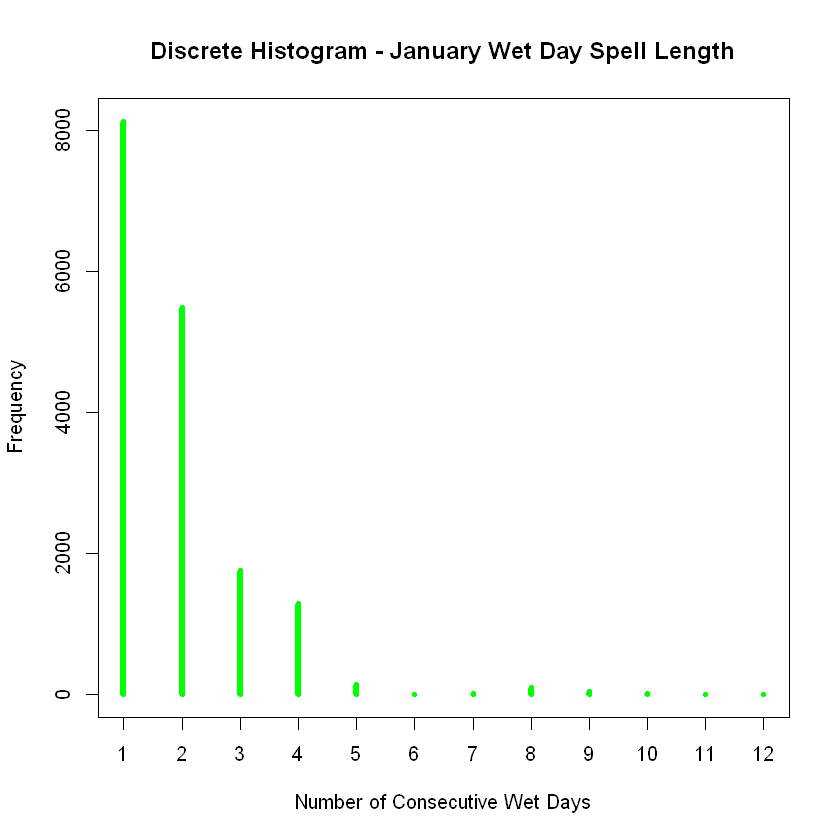

In [49]:
# continuous histogram plotting with density
#hist( wJan$Wet_Count, breaks=25, prob=T, xlab="Number of Consecutive Wet Days",
#      main="Histogram - January Wet Day Spell Length", col="green" )
#lines( density(wJan$Wet_Count), col="black")
# our case is discrete so use this command
plot( table( wJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - January Wet Day Spell Length", 
      col="green" )

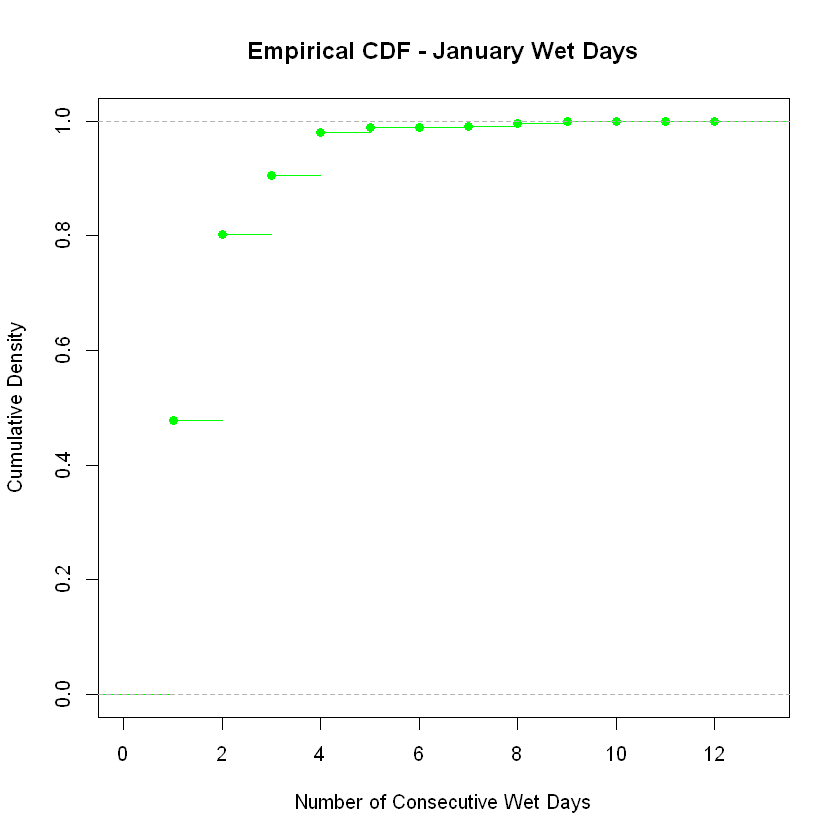

In [50]:
plot(ecdf(wJan$Wet_Count), main="Empirical CDF - January Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [57]:
wJanMax <- max( wJan$Wet_Count )
wJanMean <- mean( wJan$Wet_Count )
wJanVar <- var( wJan$Wet_Count )
wJanBNr <- wJanMean^2 / max( (wJanVar - wJanMean), 1.0 )

In [58]:
print(wJanBNr)

[1] 3.483419


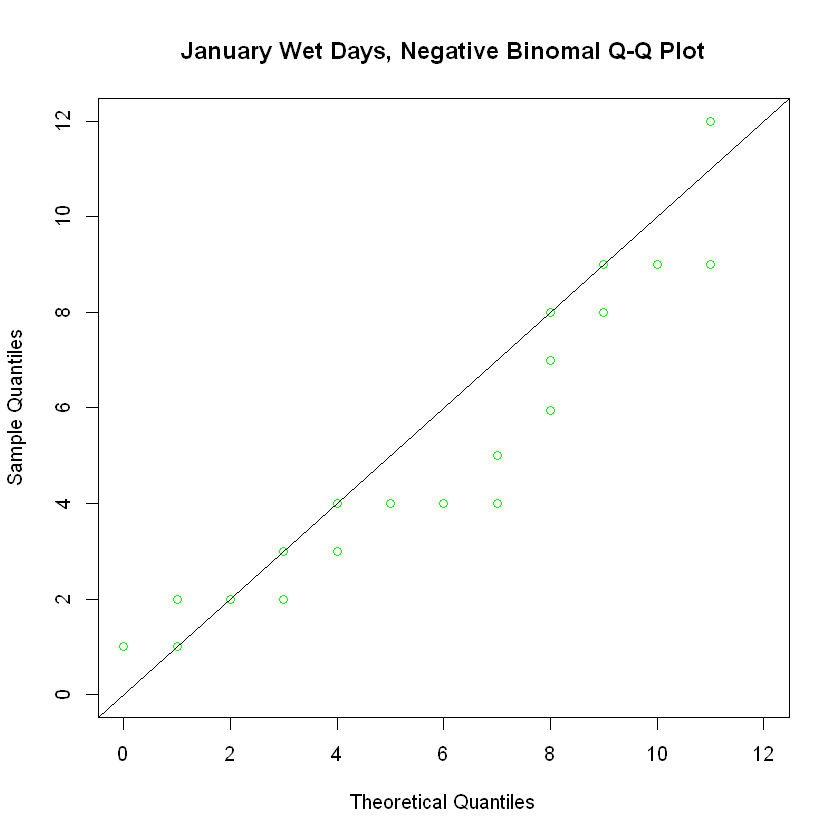

In [68]:
wJanMax <- max( wJan$Wet_Count )
wJanMean <- mean( wJan$Wet_Count )
wJanVar <- var( wJan$Wet_Count )
wJanBNr <- wJanMean^2 / max( (wJanVar - wJanMean), 1.0 )
wJanTstNB <- rnbinom( 1000, mu=wJanMean, size=wJanBNr )
qqplot( wJanTstNB, wJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="January Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wJanMax), ylim=c(0,wJanMax) )
abline( 0, 1)

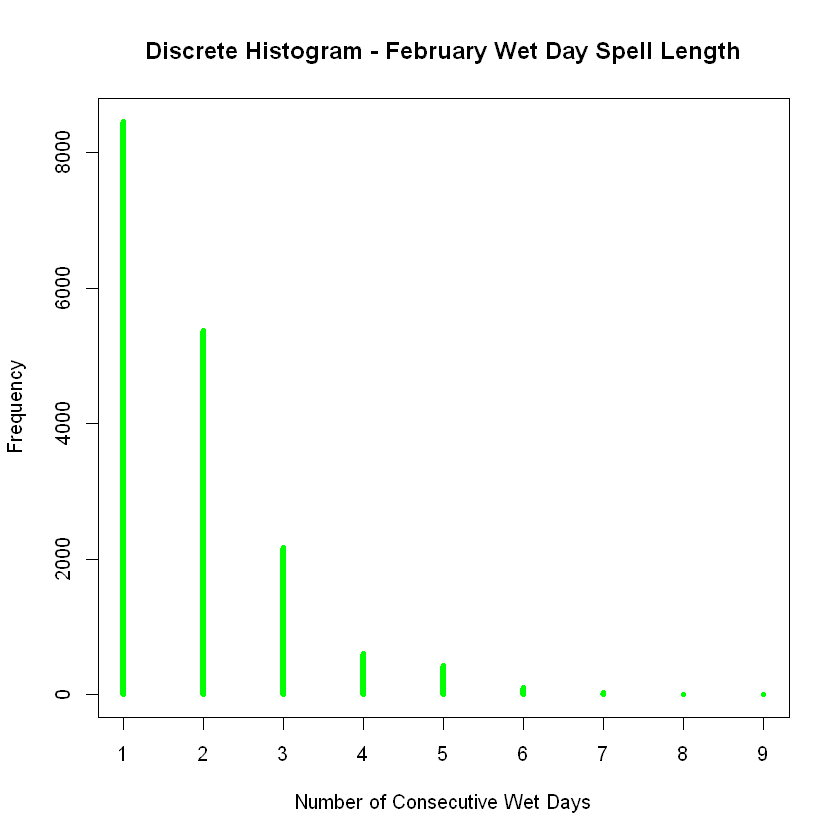

In [60]:
plot( table( wFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - February Wet Day Spell Length", 
      col="green" )

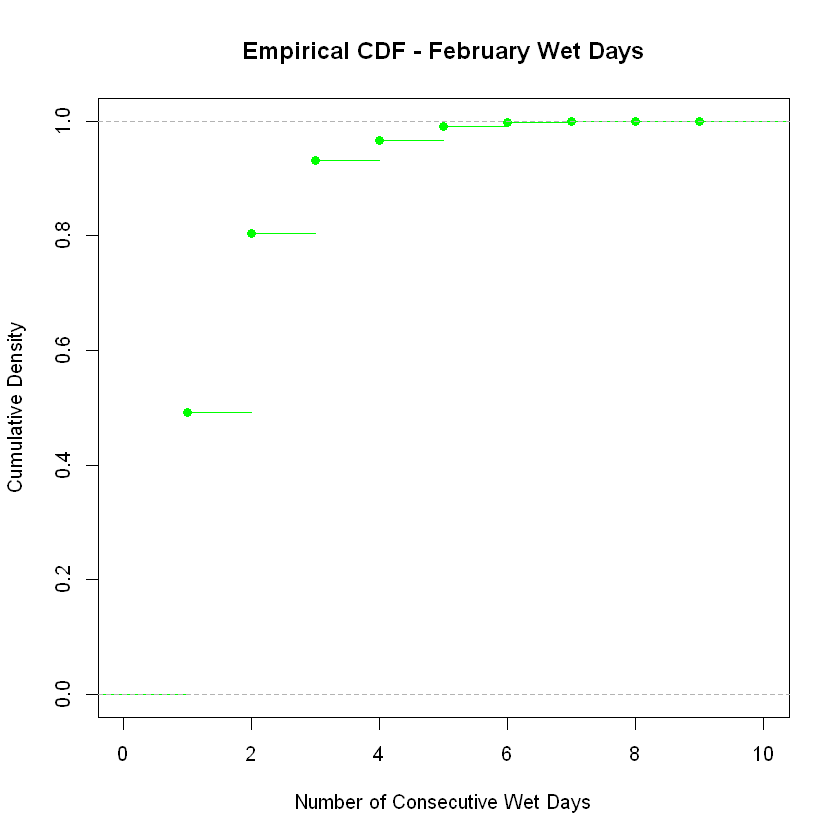

In [61]:
plot(ecdf(wFeb$Wet_Count), main="Empirical CDF - February Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

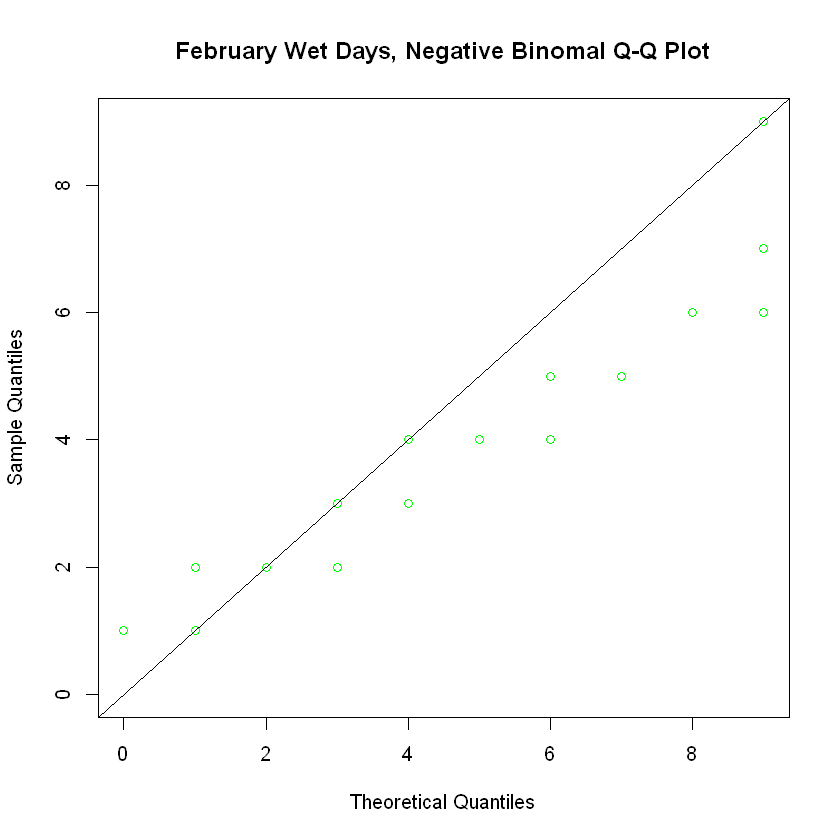

In [69]:
wFebMax <- max( wFeb$Wet_Count )
wFebMean <- mean( wFeb$Wet_Count )
wFebVar <- var( wFeb$Wet_Count )
wFebBNr <- wFebMean^2 / max( (wFebVar - wFebMean), 1.0 )
wFebTstNB <- rnbinom( 1000, mu=wFebMean, size=wFebBNr )
qqplot( wFebTstNB, wFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="February Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wFebMax), ylim=c(0,wFebMax) )
abline( 0, 1)

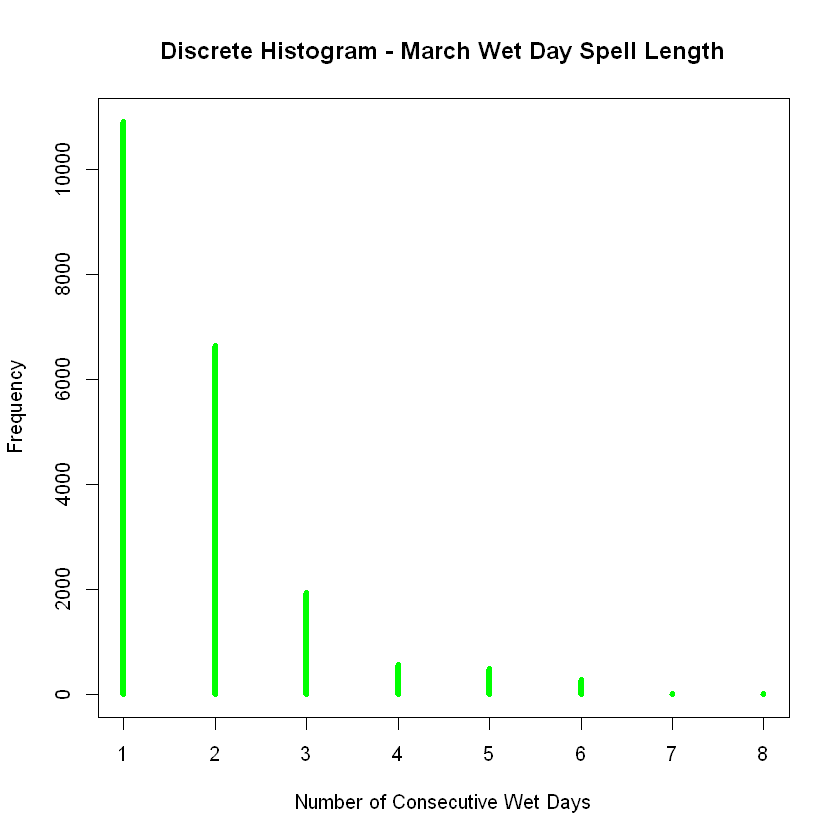

In [70]:
plot( table( wMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - March Wet Day Spell Length", 
      col="green" )

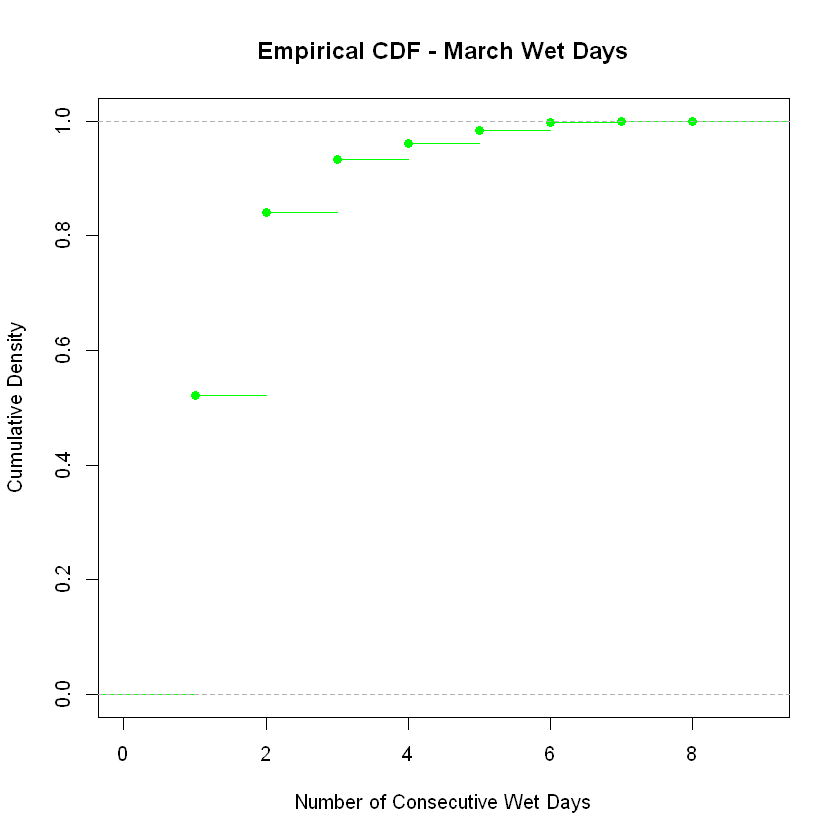

In [71]:
plot(ecdf(wMar$Wet_Count), main="Empirical CDF - March Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

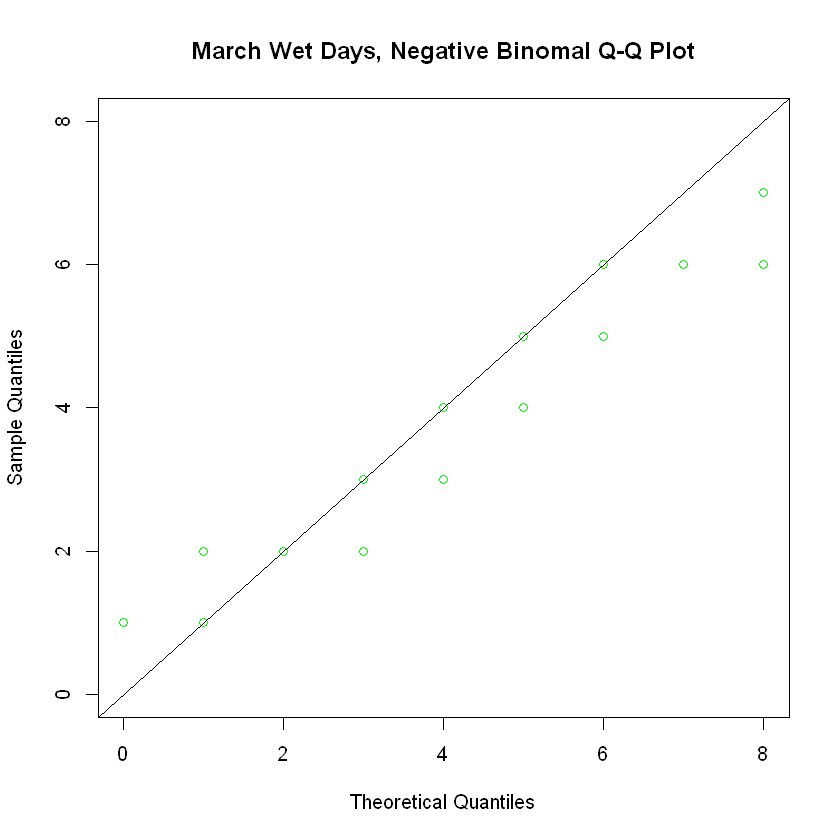

In [76]:
wMarMax <- max( wMar$Wet_Count )
wMarMean <- mean( wMar$Wet_Count )
wMarVar <- var( wMar$Wet_Count )
wMarBNr <- wMarMean^2 / max( (wMarVar - wMarMean), 1.0 )
wMarTstNB <- rnbinom( 1000, mu=wMarMean, size=wMarBNr )
qqplot( wMarTstNB, wMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="March Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wMarMax), ylim=c(0,wMarMax) )
abline( 0, 1)

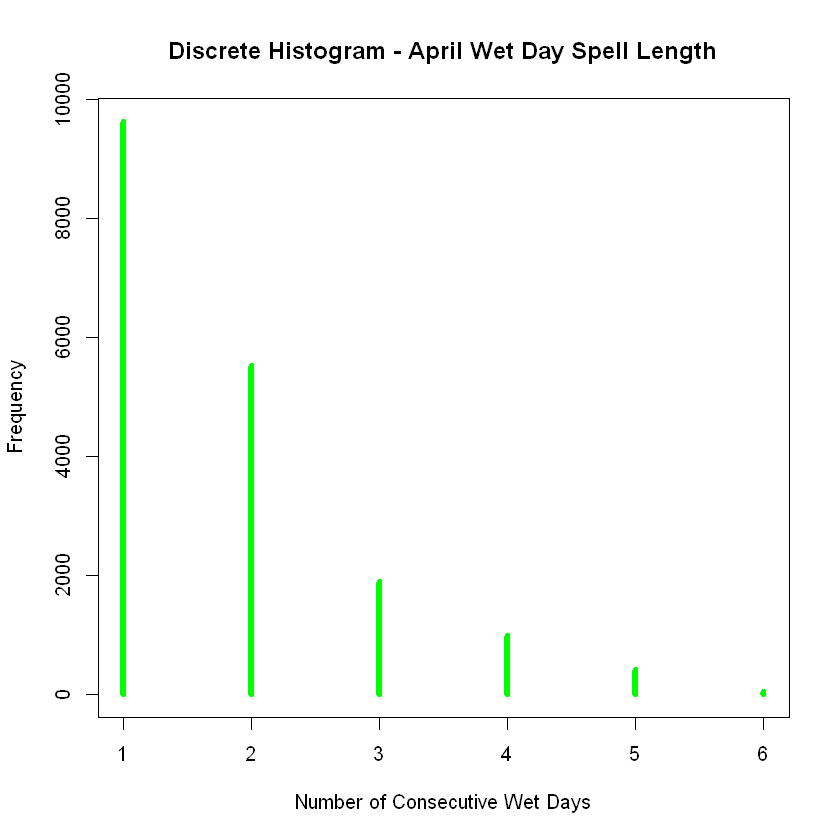

In [77]:
plot( table( wApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - April Wet Day Spell Length", 
      col="green" )

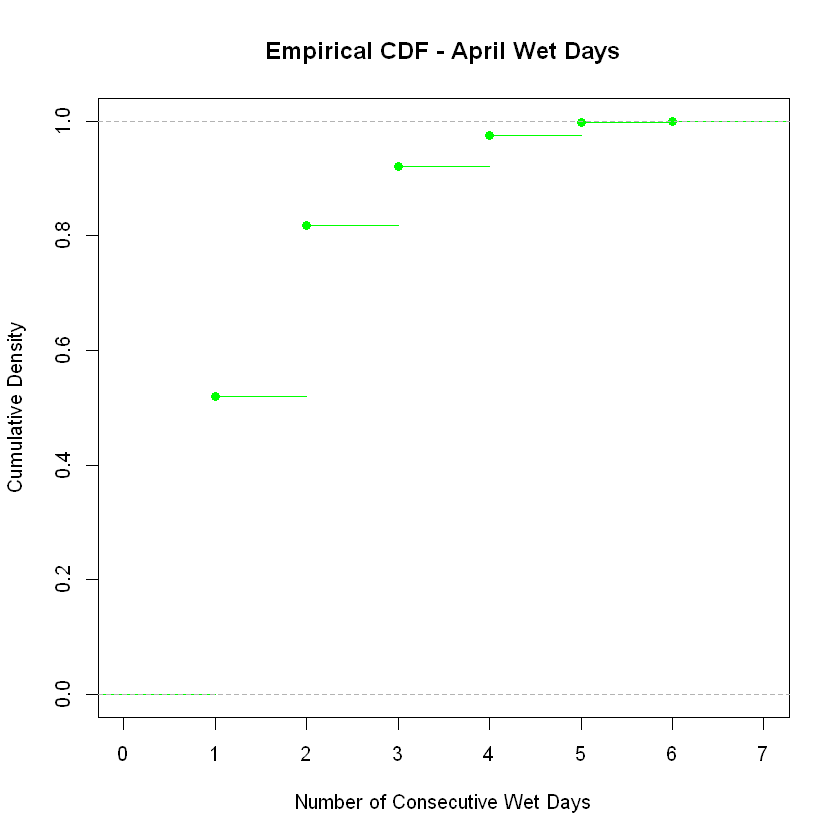

In [78]:
plot(ecdf(wApr$Wet_Count), main="Empirical CDF - April Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

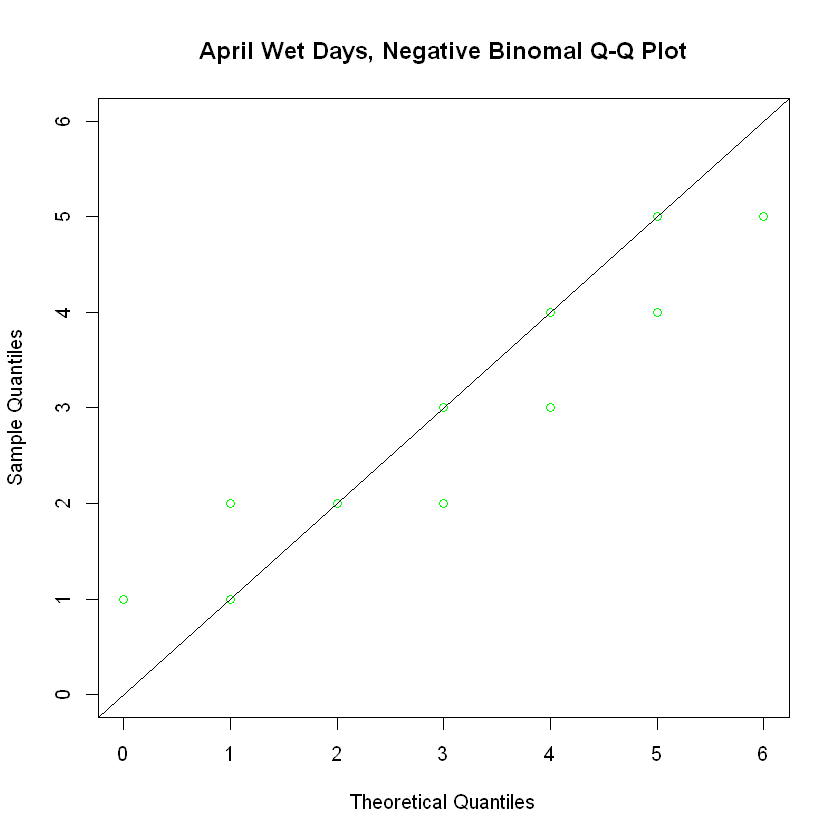

In [80]:
wAprMax <- max( wApr$Wet_Count )
wAprMean <- mean( wApr$Wet_Count )
wAprVar <- var( wApr$Wet_Count )
wAprBNr <- wAprMean^2 / max( (wAprVar - wAprMean), 1.0 )
wAprTstNB <- rnbinom( 1000, mu=wAprMean, size=wAprBNr )
qqplot( wAprTstNB, wApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="April Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wAprMax), ylim=c(0,wAprMax) )
abline( 0, 1)

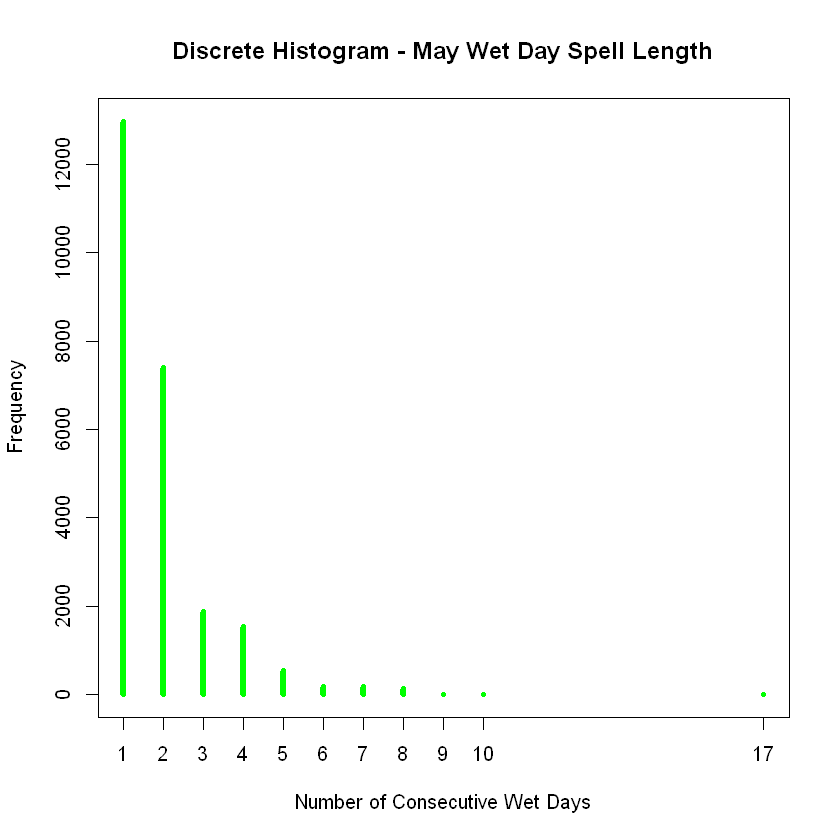

In [81]:
plot( table( wMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

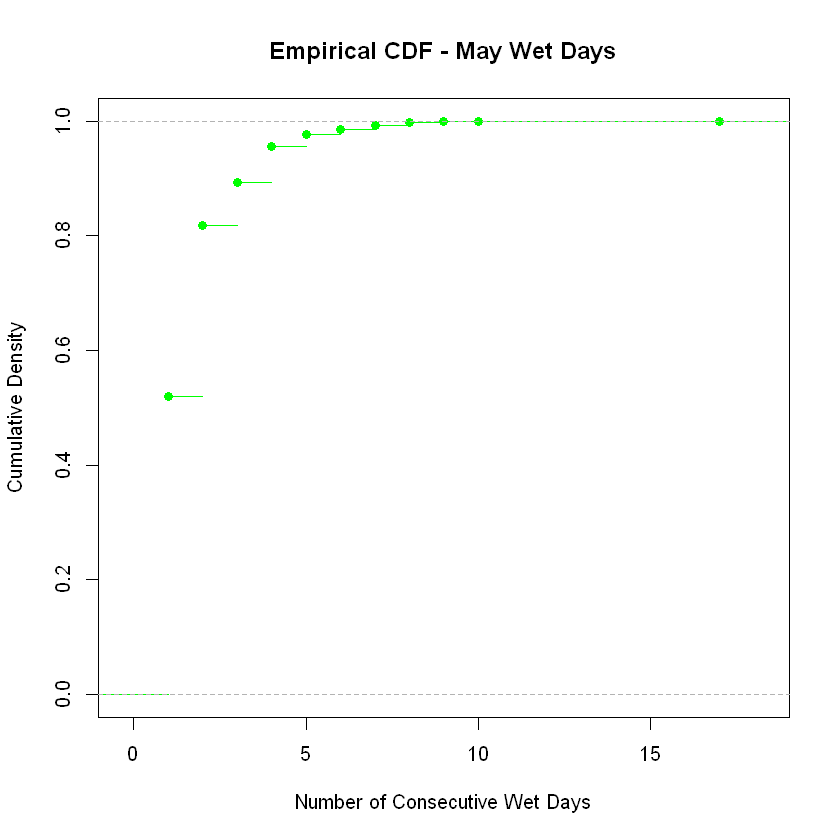

In [82]:
plot(ecdf(wMay$Wet_Count), main="Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

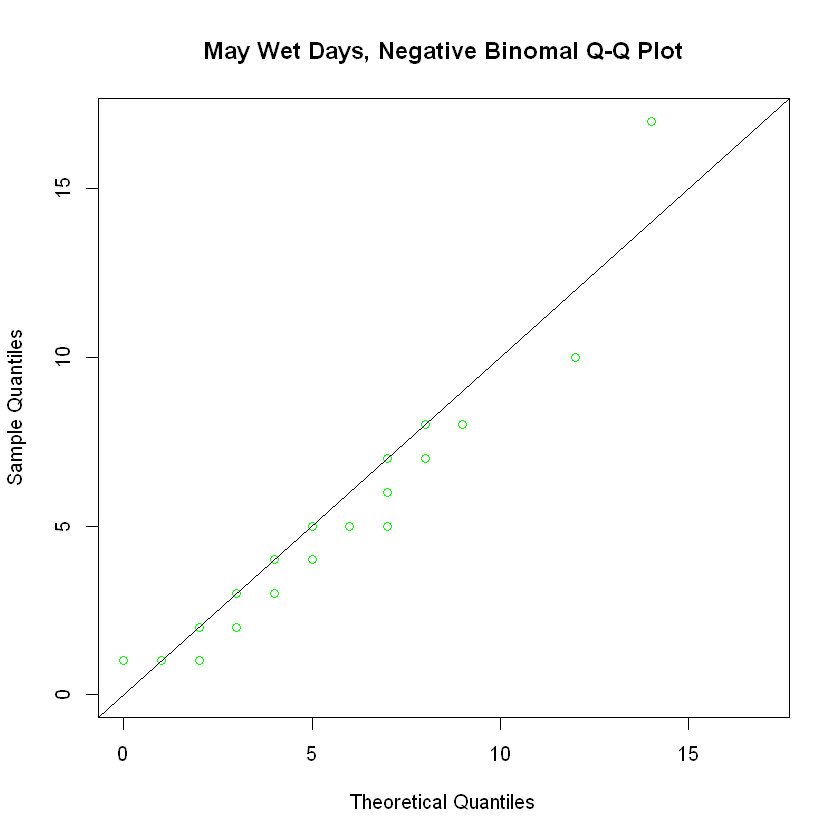

In [84]:
wMayMax <- max( wMay$Wet_Count )
wMayMean <- mean( wMay$Wet_Count )
wMayVar <- var( wMay$Wet_Count )
wMayBNr <- wMayMean^2 / max( (wMayVar - wMayMean), 1.0 )
wMayTstNB <- rnbinom( 1000, mu=wMayMean, size=wMayBNr )
qqplot( wMayTstNB, wMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wMayMax), ylim=c(0,wMayMax) )
abline( 0, 1)

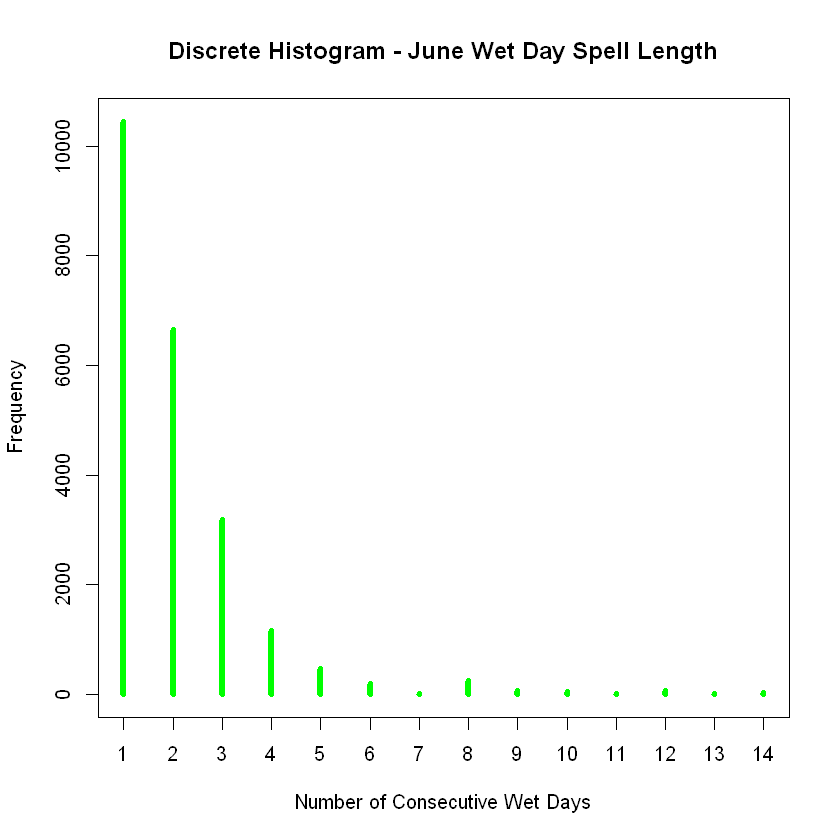

In [85]:
plot( table( wJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - June Wet Day Spell Length", 
      col="green" )

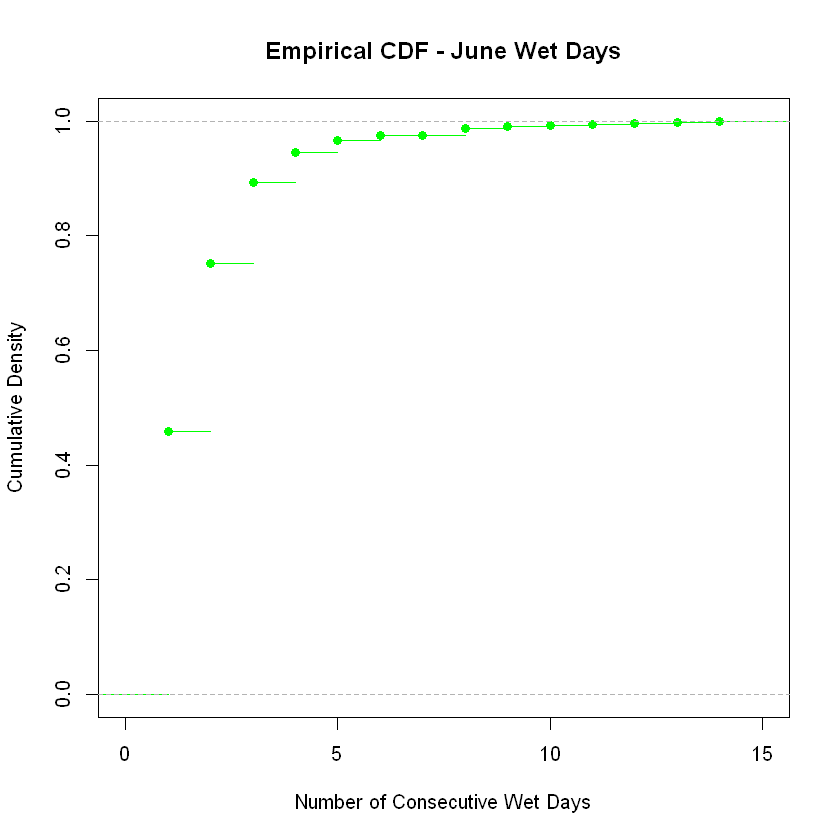

In [86]:
plot(ecdf(wJun$Wet_Count), main="Empirical CDF - June Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

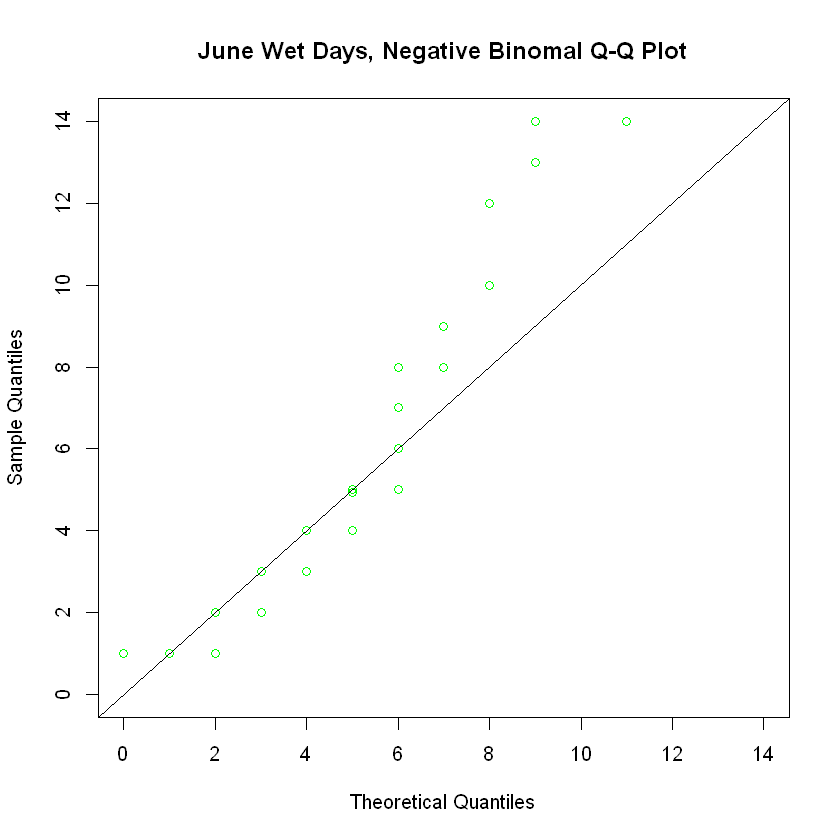

In [113]:
wJunMax <- max( wJun$Wet_Count )
wJunMean <- mean( wJun$Wet_Count )
wJunVar <- var( wJun$Wet_Count )
wJunBNr <- wJunMean^2 / max( (wJunVar - wJunMean), 1.0 )
wJunTstNB <- rnbinom( 1000, mu=wJunMean, size=wJunBNr )
qqplot( wJunTstNB, wJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="June Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wJunMax), ylim=c(0,wJunMax) )
abline( 0, 1)

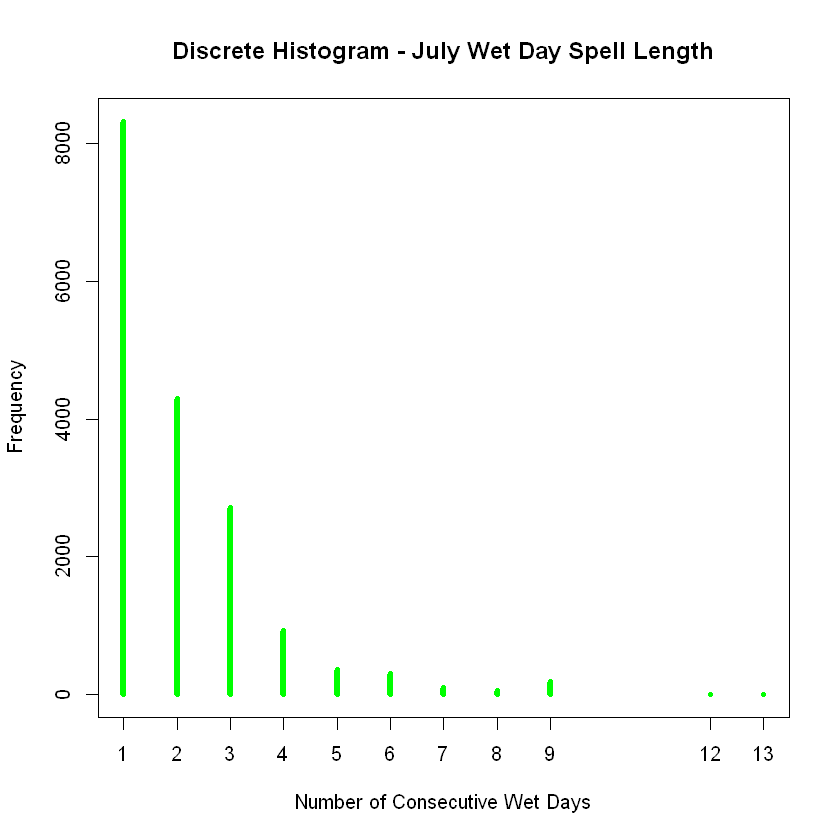

In [88]:
plot( table( wJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - July Wet Day Spell Length", 
      col="green" )

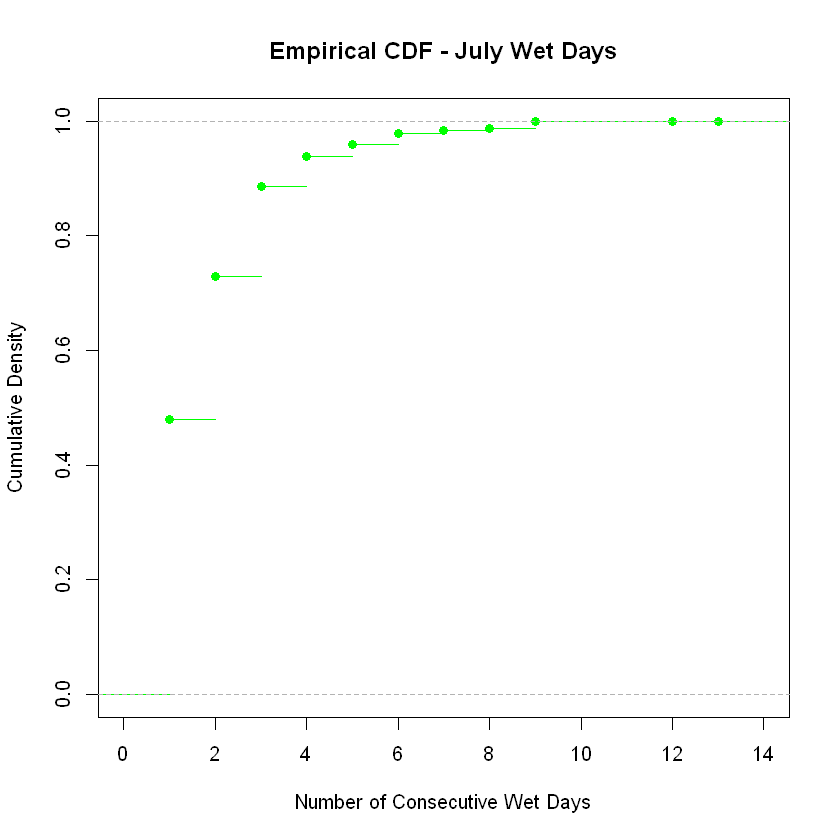

In [89]:
plot(ecdf(wJul$Wet_Count), main="Empirical CDF - July Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

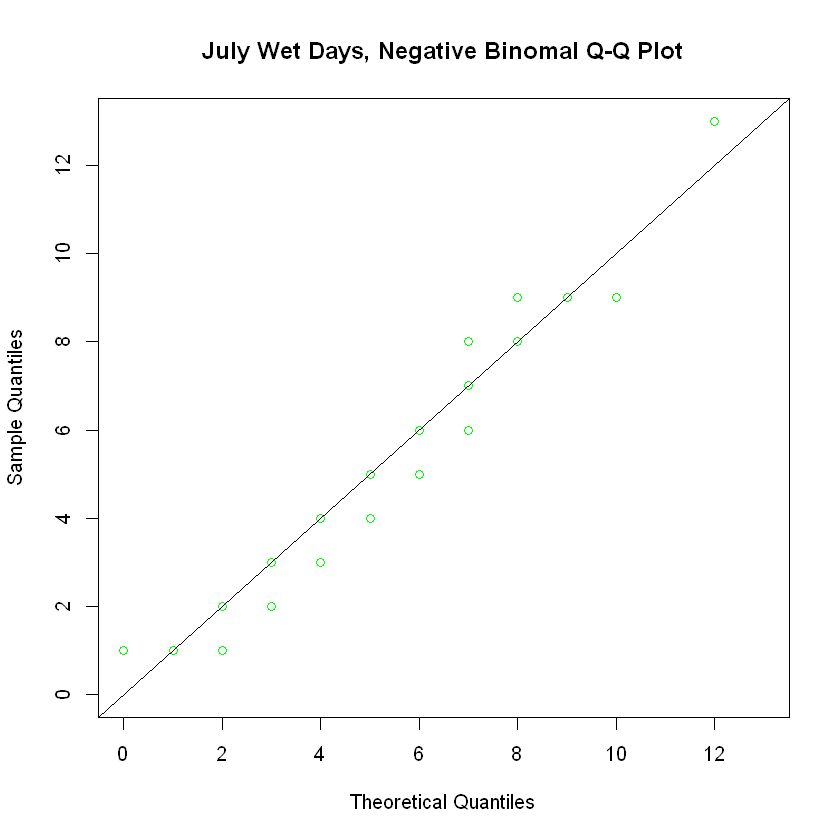

In [112]:
wJulMax <- max( wJul$Wet_Count )
wJulMean <- mean( wJul$Wet_Count )
wJulVar <- var( wJul$Wet_Count )
wJulBNr <- wJulMean^2 / max( (wJulVar - wJulMean), 1.0 )
wJulTstNB <- rnbinom( 1000, mu=wJulMean, size=wJulBNr )
qqplot( wJulTstNB, wJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="July Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wJulMax), ylim=c(0,wJulMax) )
abline( 0, 1)

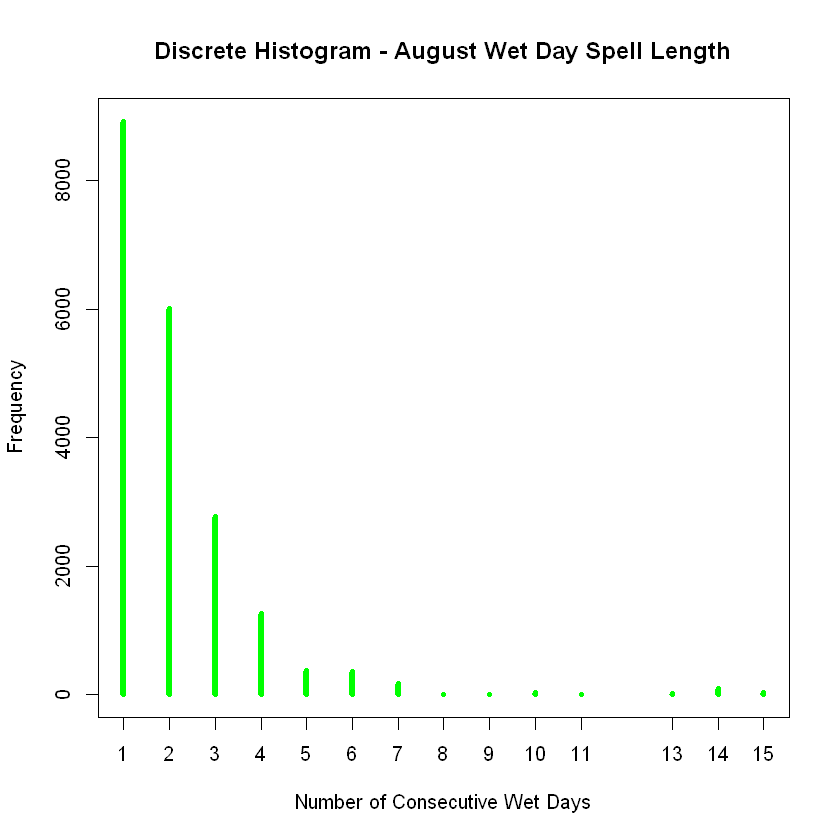

In [91]:
plot( table( wAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - August Wet Day Spell Length", 
      col="green" )

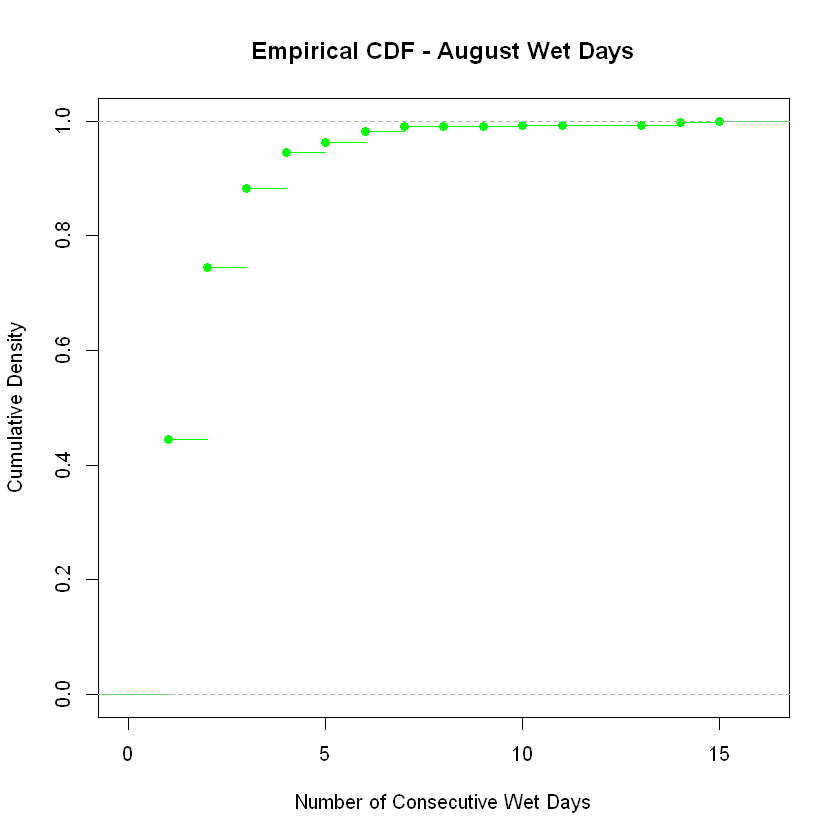

In [92]:
plot(ecdf(wAug$Wet_Count), main="Empirical CDF - August Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

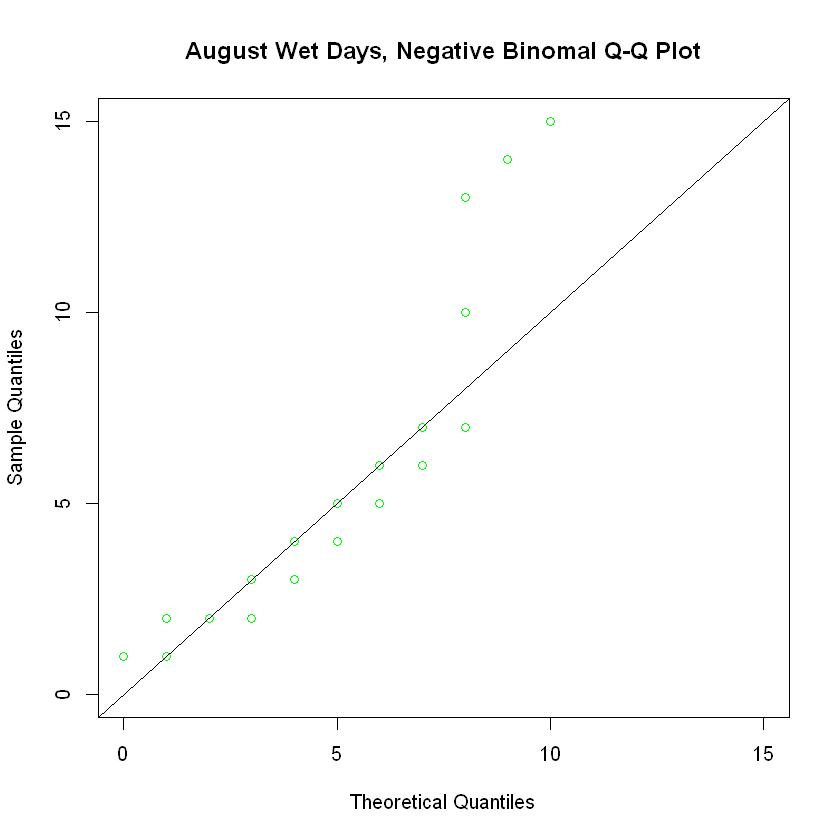

In [111]:
wAugMax <- max( wAug$Wet_Count )
wAugMean <- mean( wAug$Wet_Count )
wAugVar <- var( wAug$Wet_Count )
wAugBNr <- wAugMean^2 / max( (wAugVar - wAugMean), 1.0 )
wAugTstNB <- rnbinom( 1000, mu=wAugMean, size=wAugBNr )
qqplot( wAugTstNB, wAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="August Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wAugMax), ylim=c(0,wAugMax) )
abline( 0, 1)

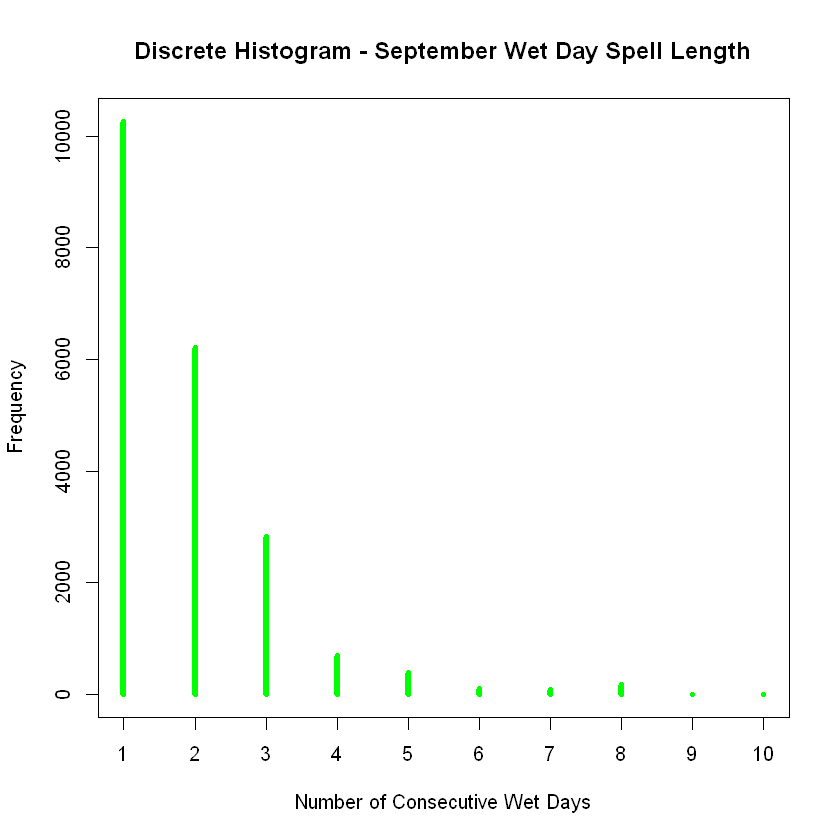

In [94]:
plot( table( wSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - September Wet Day Spell Length", 
      col="green" )

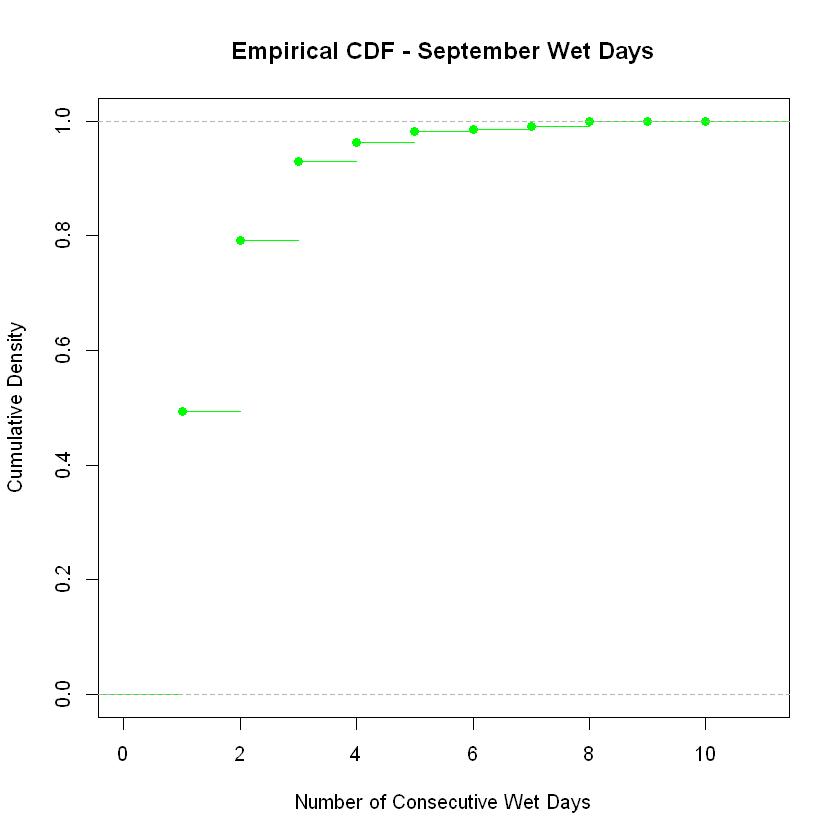

In [95]:
plot(ecdf(wSep$Wet_Count), main="Empirical CDF - September Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

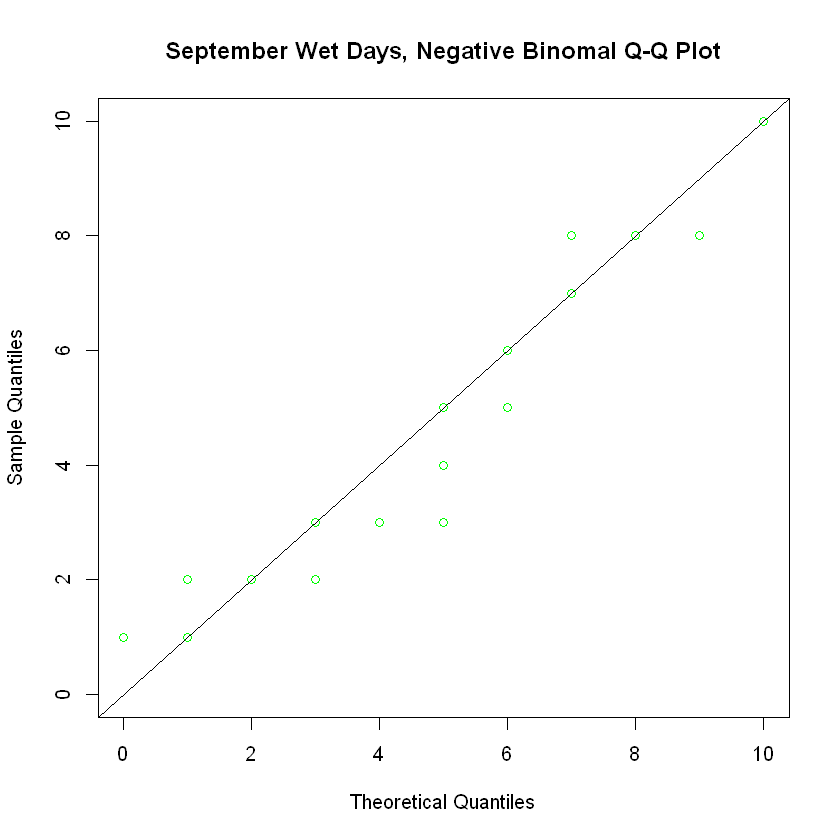

In [97]:
wSepMax <- max( wSep$Wet_Count )
wSepMean <- mean( wSep$Wet_Count )
wSepVar <- var( wSep$Wet_Count )
wSepBNr <- wSepMean^2 / max( (wSepVar - wSepMean), 1.0 )
wSepTstNB <- rnbinom( 1000, mu=wSepMean, size=wSepBNr )
qqplot( wSepTstNB, wSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="September Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wSepMax), ylim=c(0,wSepMax) )
abline( 0, 1)

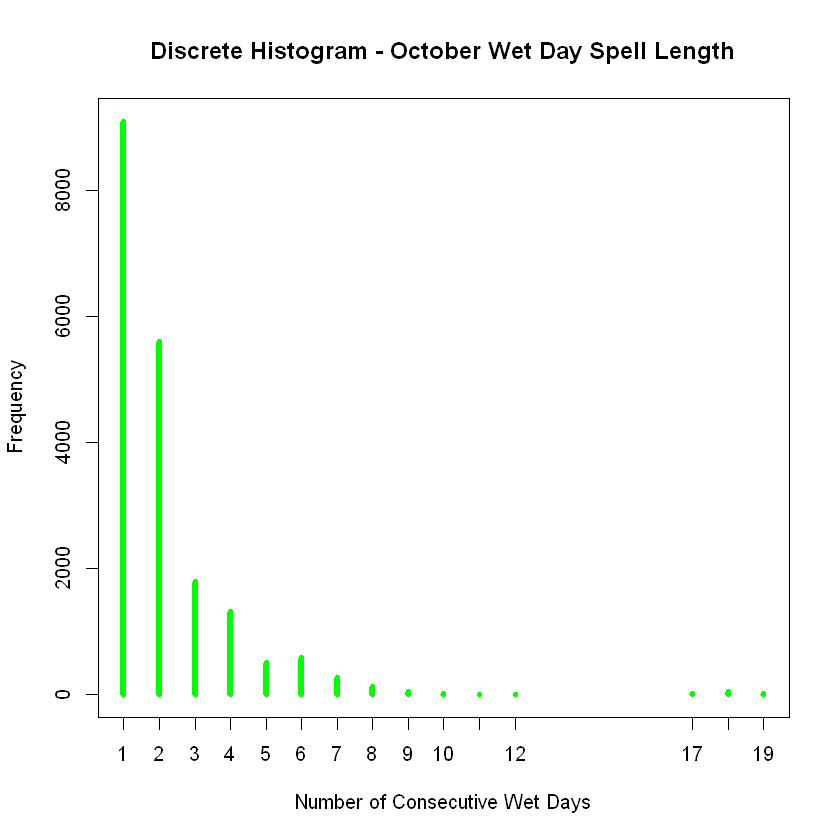

In [98]:
plot( table( wOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - October Wet Day Spell Length", 
      col="green" )

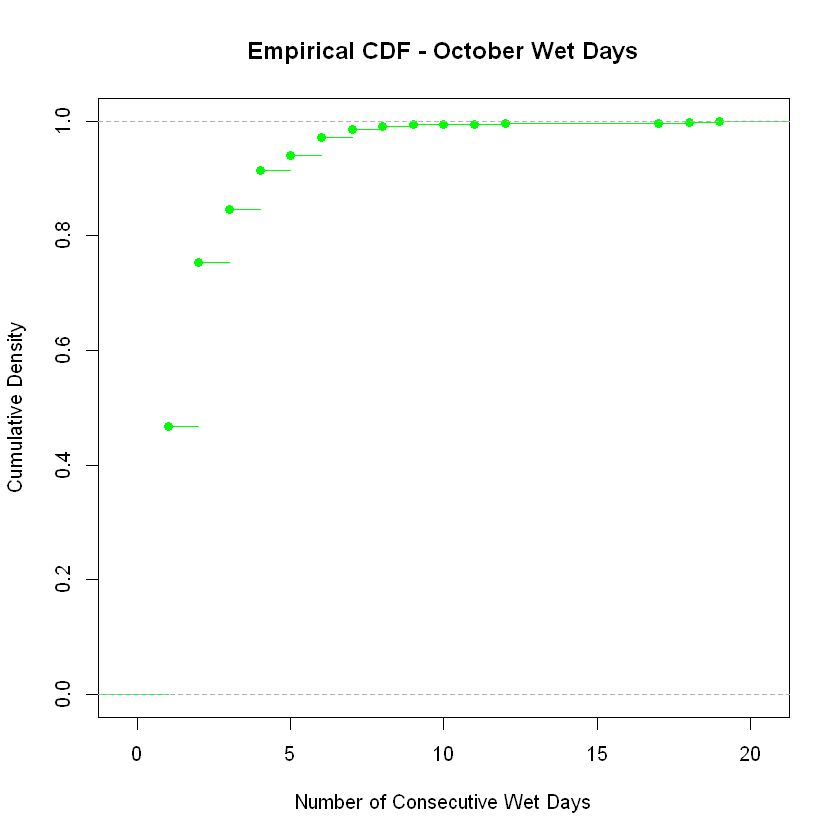

In [99]:
plot(ecdf(wOct$Wet_Count), main="Empirical CDF - October Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

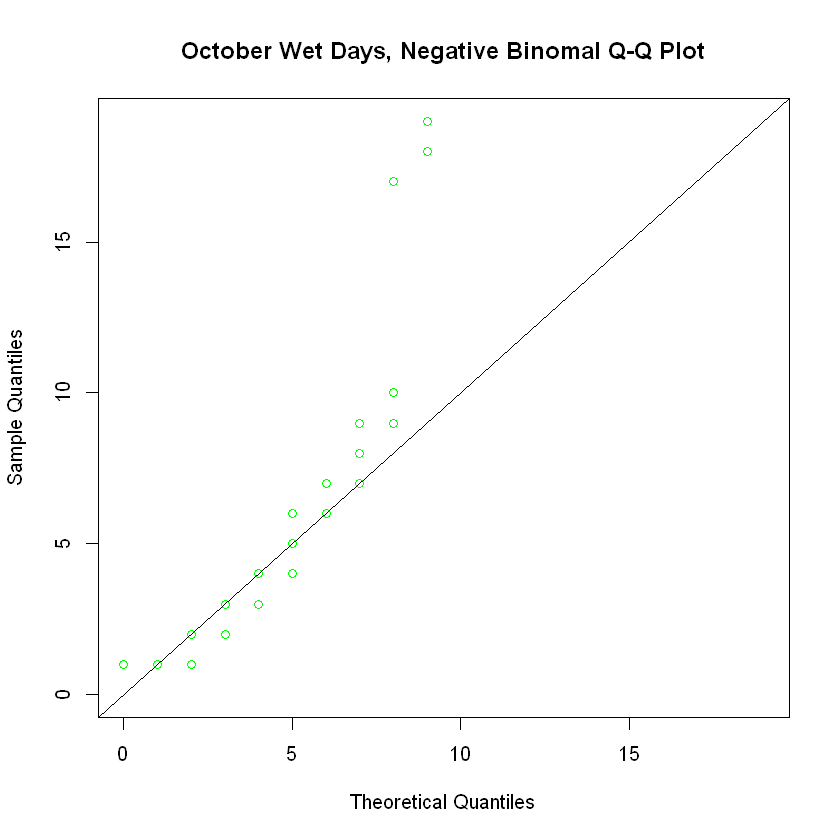

In [110]:
wOctMax <- max( wOct$Wet_Count )
wOctMean <- mean( wOct$Wet_Count )
wOctVar <- var( wOct$Wet_Count )
wOctBNr <- wOctMean^2 / max( (wOctVar - wOctMean), 1.0 )
wOctTstNB <- rnbinom( 1000, mu=wOctMean, size=wOctBNr )
qqplot( wOctTstNB, wOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="October Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wOctMax), ylim=c(0,wOctMax) )
abline( 0, 1)

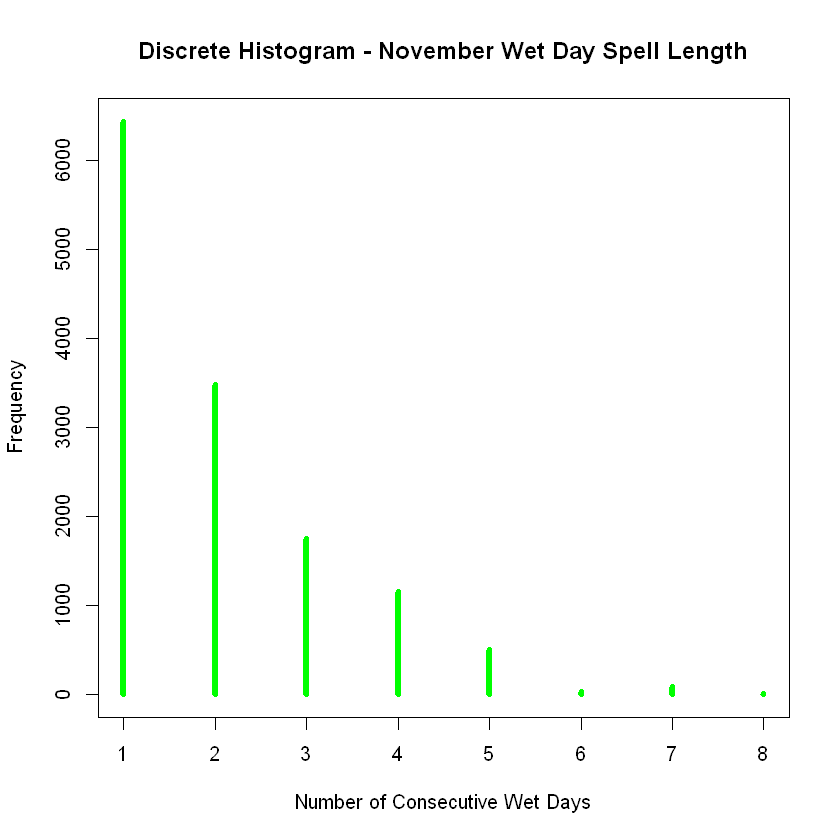

In [101]:
plot( table( wNov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - November Wet Day Spell Length", 
      col="green" )

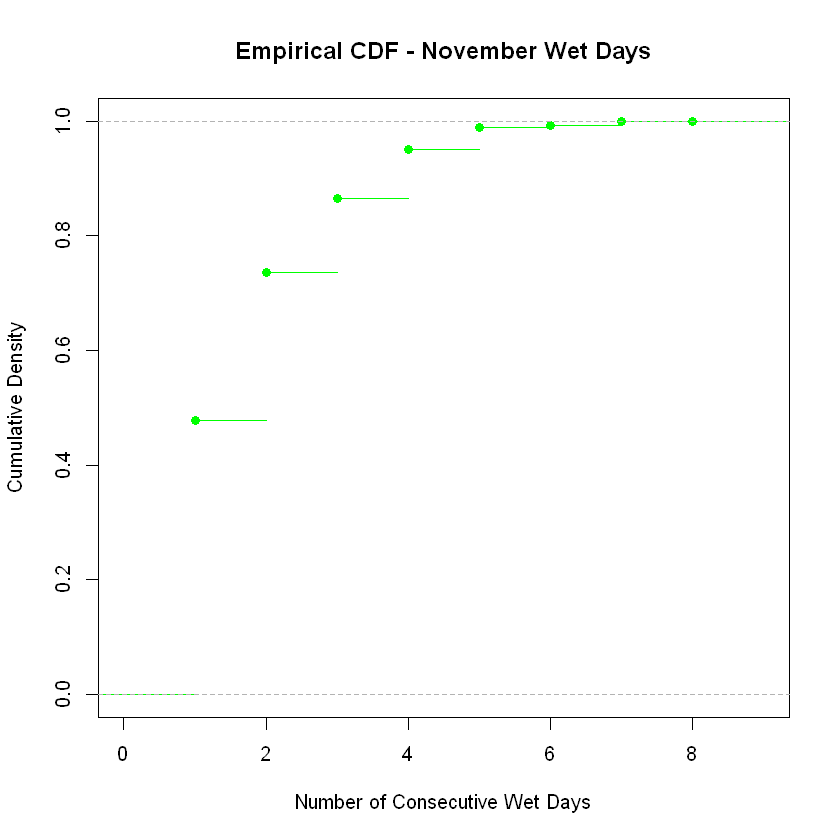

In [102]:
plot(ecdf(wNov$Wet_Count), main="Empirical CDF - November Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

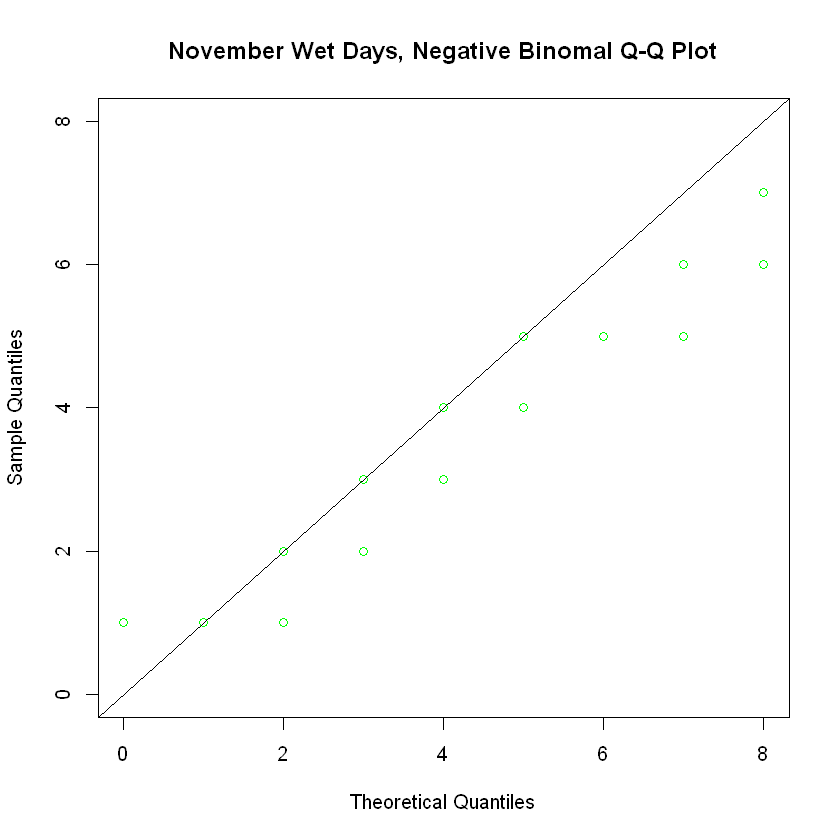

In [104]:
wNovMax <- max( wNov$Wet_Count )
wNovMean <- mean( wNov$Wet_Count )
wNovVar <- var( wNov$Wet_Count )
wNovBNr <- wNovMean^2 /  max( (wNovVar - wNovMean), 1.0 )
wNovTstNB <- rnbinom( 1000, mu=wNovMean, size=wNovBNr )
qqplot( wNovTstNB, wNov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="November Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wNovMax), ylim=c(0,wNovMax) )
abline( 0, 1)

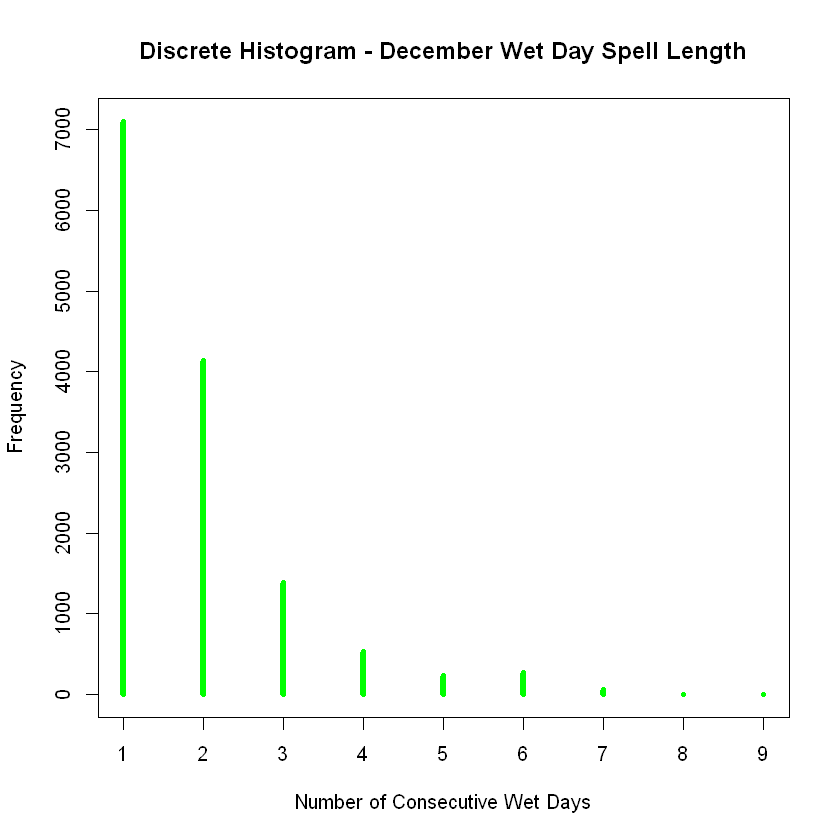

In [105]:
plot( table( wDec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="Discrete Histogram - December Wet Day Spell Length", 
      col="green" )

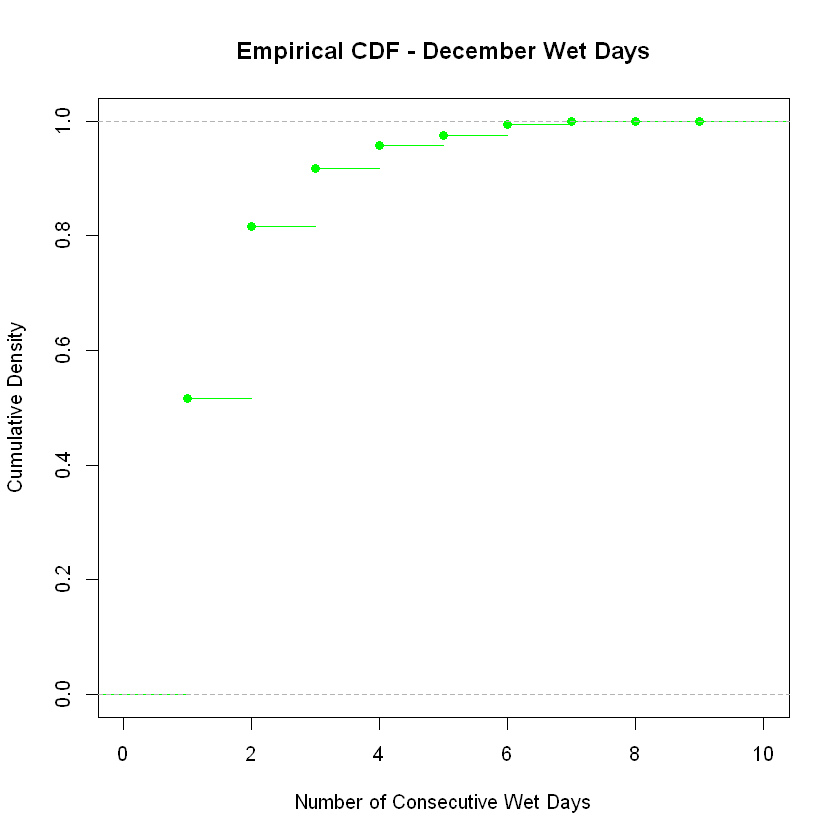

In [106]:
plot(ecdf(wDec$Wet_Count), main="Empirical CDF - December Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

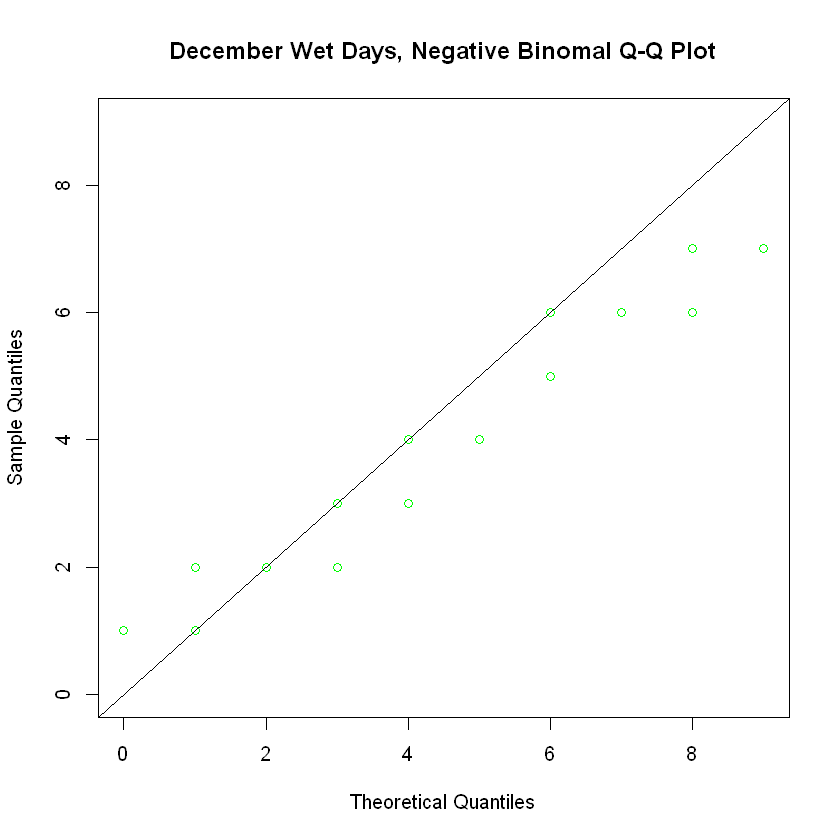

In [108]:
wDecMax <- max( wDec$Wet_Count )
wDecMean <- mean( wDec$Wet_Count )
wDecVar <- var( wDec$Wet_Count )
wDecBNr <- wDecMean^2 / max( (wDecVar - wDecMean), 1.0 )
wDecTstNB <- rnbinom( 1000, mu=wDecMean, size=wDecBNr )
qqplot( wDecTstNB, wDec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="December Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,wDecMax), ylim=c(0,wDecMax) )
abline( 0, 1)

In [114]:
cat("Jan scale: ", wJanBNr, "\n", "Feb scale: ", wFebBNr, "\n",
    "Mar scale: ", wMarBNr, "\n", "Apr scale: ", wAprBNr, "\n",
    "May scale: ", wMayBNr, "\n", "Jun scale: ", wJunBNr, "\n",
    "Jul scale: ", wJulBNr, "\n", "Aug scale: ", wAugBNr, "\n",
    "Sep scale: ", wSepBNr, "\n", "Oct scale: ", wOctBNr, "\n",
    "Nov scale: ", wNovBNr, "\n", "Dec scale: ", wDecBNr, "\n" )

Jan scale:  3.483419 
 Feb scale:  3.296908 
 Mar scale:  3.103899 
 Apr scale:  3.127928 
 May scale:  3.467703 
 Jun scale:  4.292729 
 Jul scale:  4.230053 
 Aug scale:  4.403374 
 Sep scale:  3.471844 
 Oct scale:  3.596253 
 Nov scale:  3.951476 
 Dec scale:  3.324371 


### Fitting Negative Binomial Distributions

Use the **fitdistrplus** package for distribution fitting. This also provides the *plotdist* function which provides a pair of plots: 

1. empirical density, or a histogram
2. empirical cumulative distribution

These plots were provided above from scratch. **fitdistrplus** also provides a *descdist* function that provides classical descriptive statistics for the sample.

Distributions are then fit using a Maximum Likelihood Estimation (MLE) estimator in the *fitdist* function. Then goodness-of-fit statistics are calculated using the *gofstat* function.

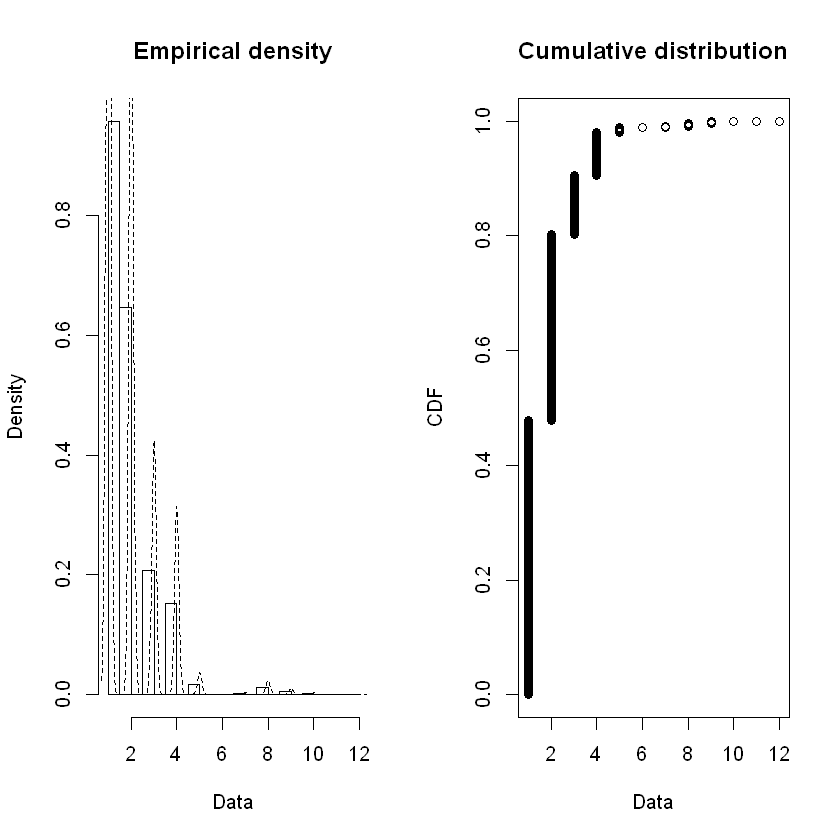

In [115]:
plotdist( wJan$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  12 
median:  2 
mean:  1.866392 
estimated sd:  1.165071 
estimated skewness:  2.346238 
estimated kurtosis:  12.17146 

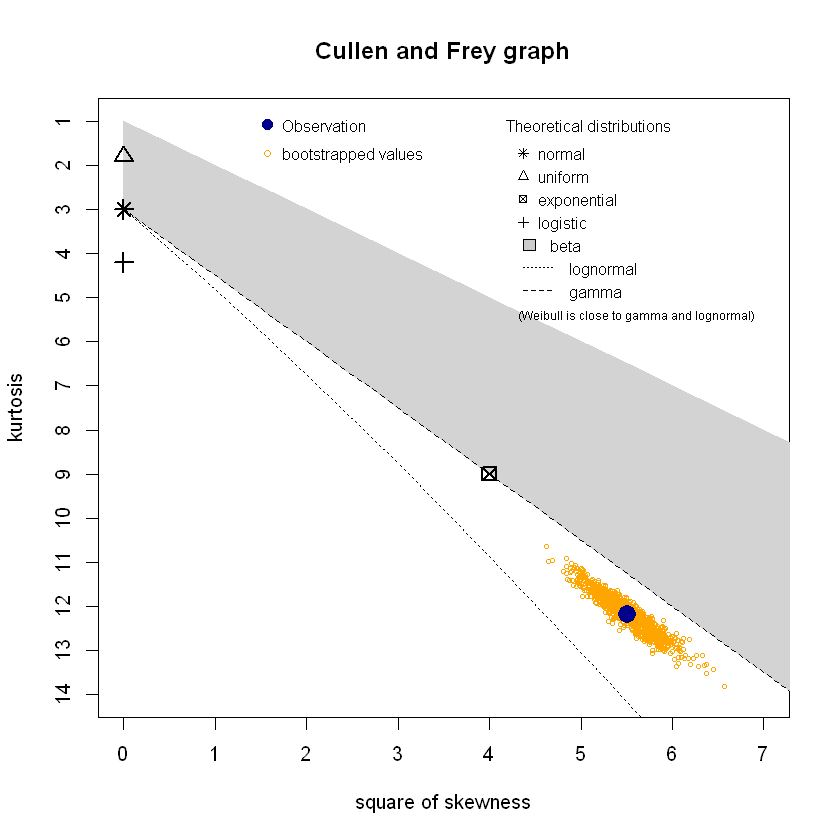

In [116]:
descdist( wJan$Wet_Count, boot=1000 )

In [117]:
fd_NB_wJan <- fitdist( wJan$Wet_Count, "nbinom" )
fd_GE_wJan <- fitdist( wJan$Wet_Count, "geom" )

In [118]:
summary( fd_NB_wJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate Std. Error
size 6.860232e+06 2.08054479
mu   1.866322e+00 0.01048065
Loglikelihood:  -25628.22   AIC:  51260.44   BIC:  51275.92 
Correlation matrix:
     size mu
size    1  0
mu      0  1


In [119]:
fdNB_wJan_size <- fd_NB_wJan$estimate[["size"]]
fdNB_wJan_mu <- fd_NB_wJan$estimate[["mu"]]
cat("Jan size: ", fdNB_wJan_size, "\n", "Jan mu: ", fdNB_wJan_mu, "\n")

Jan size:  6860232 
 Jan mu:  1.866322 


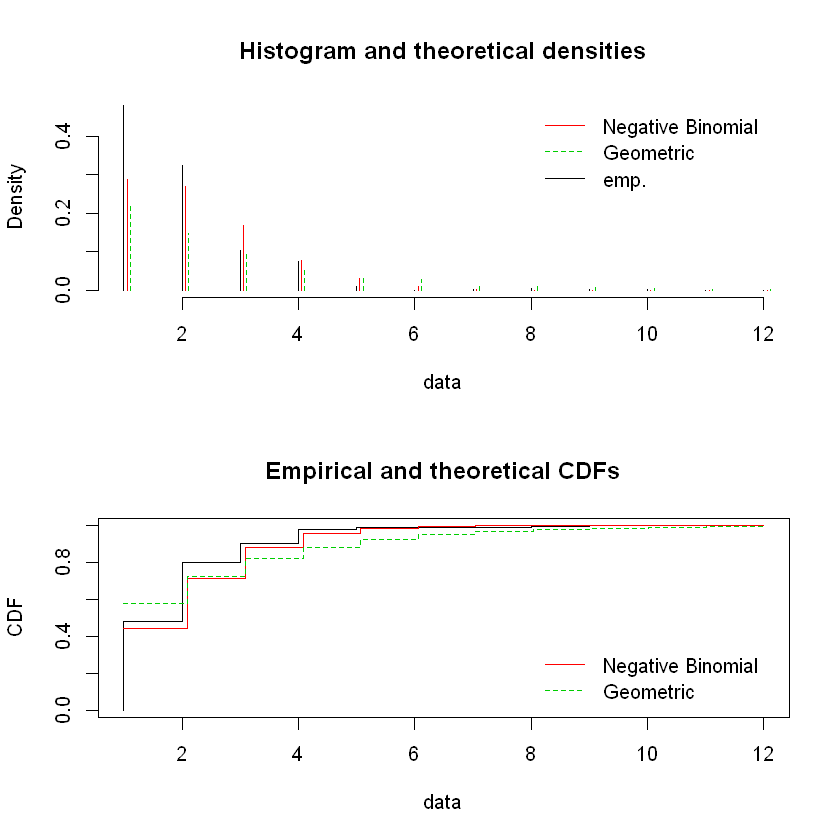

In [120]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wJan, fd_GE_wJan), legendtext=plot.legend )
cdfcomp( list(fd_NB_wJan, fd_GE_wJan), legendtext=plot.legend )

In [121]:
statRes <- gofstat( list(fd_NB_wJan, fd_GE_wJan), fitnames=c("Negative Binomial", "Geometric") )

In [122]:
print(statRes)

Chi-squared statistic:  2098.452 5257.229 
Degree of freedom of the Chi-squared distribution:  3 4 
Chi-squared p-value:  0 0 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      8135            7533.296203      9786.7591
<= 2      5490            4577.234106      2512.9992
<= 3      1755            2847.530956      1636.2876
<= 4      1288            1328.602635      1065.4349
<= 8       266             700.900690      1631.0827
> 8         56               2.435409       357.4365

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          51260.44  62994.94
Bayesian Information Criterion          51275.92  63002.68


In [123]:
fdNB_wJan_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

[Chi-Squared Test](https://www.r-bloggers.com/chi-squared-test/)

Like all statistical tests, chi-squared test assumes a null hypothesis and an alternate hypothesis. The general practice is, if the p-value that comes out in the result is less than a pre-determined significance level, which is 0.05 usually, then we reject the null hypothesis.

- H0: The The two variables are independent
- H1: The two variables are related.

The null hypothesis of the chi-squared test is that the two variables are independent and the alternate hypothesis is that they are related.

In this case our p-value is 0.0 and we can reject the null hypothesis that sample and MLE-fit distribution are not related.

In [124]:
fdNB_wJan_p = fdNB_wJan_size / (fdNB_wJan_size + fdNB_wJan_mu)
cat("prob: ", fdNB_wJan_p)

prob:  0.9999997

In [125]:
# add to our tracking dataframe
MonDistDF[1, ] <- list( 1, wJanMean, wJanBNr, fdNB_wJan_p, fdNB_wJan_mu, fdNB_wJan_size,
                        fdNB_wJan_pvalue )

In [126]:
gf_wJan <- goodfit( wJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wJan_size, prob=fdNB_wJan_p) )

In [127]:
summary( gf_wJan )

Warning message in summary.goodfit(gf_wJan):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          7833.419 12        0
Likelihood Ratio 8845.543 11        0


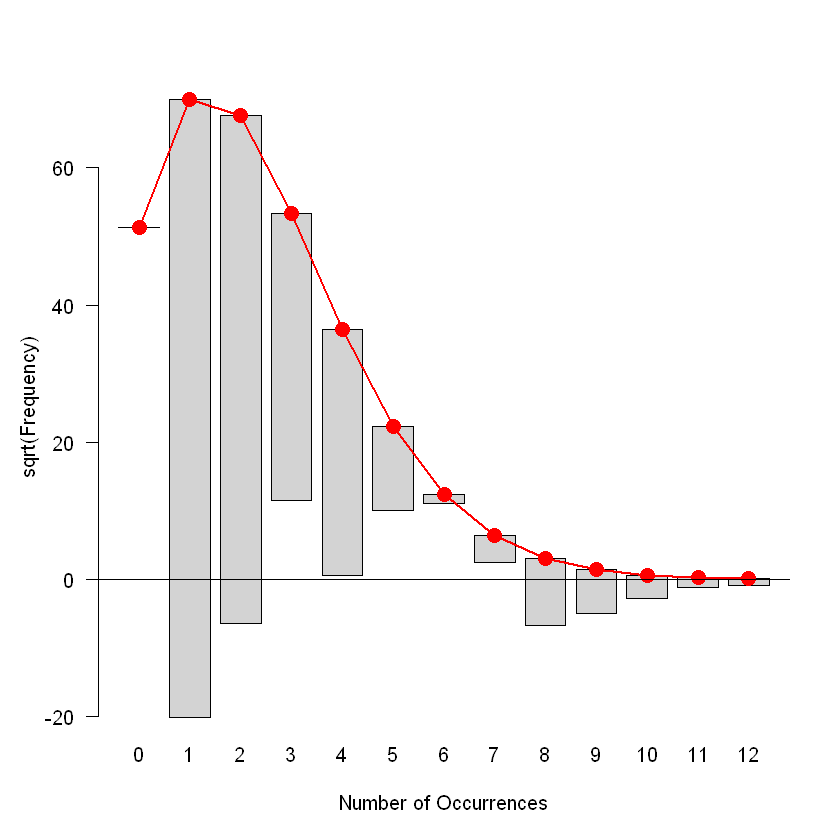

In [128]:
plot( gf_wJan )

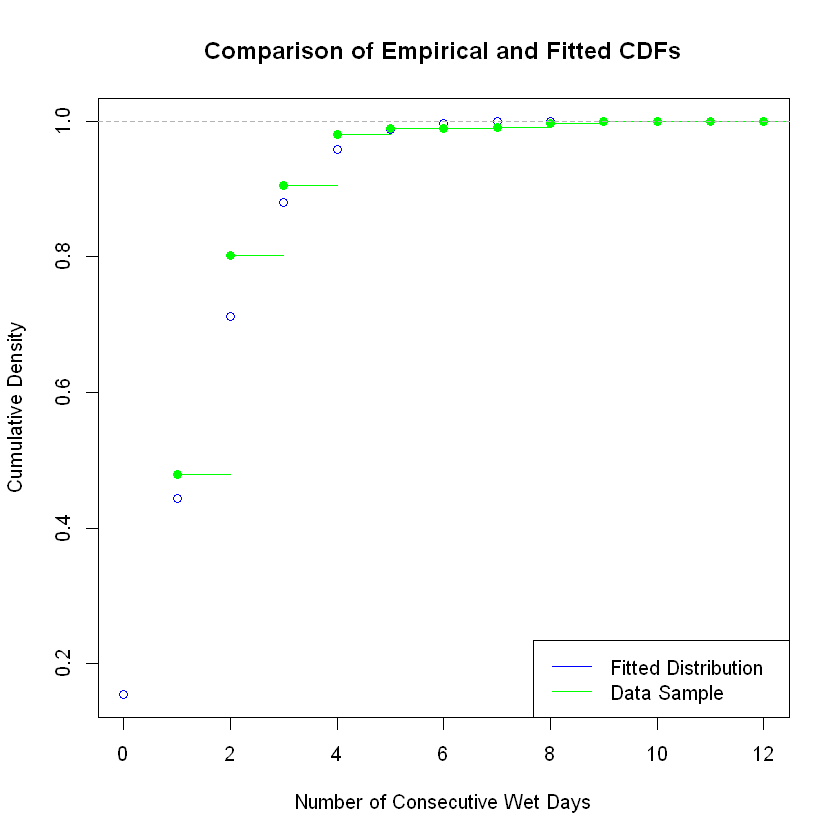

In [129]:
x <- seq(0,wJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wJan_mu, size=fdNB_wJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

In [130]:
ks.test( wJan$Wet_Count, "pnbinom", mu=fdNB_wJan_mu, size=fdNB_wJan_size )

Warning message in ks.test(wJan$Wet_Count, "pnbinom", mu = fdNB_wJan_mu, size = fdNB_wJan_size):
"default ks.test() cannot compute correct p-values with ties;
 see help page for one-sample Kolmogorov test for discrete distributions."


	One-sample Kolmogorov-Smirnov test

data:  wJan$Wet_Count
D = 0.4434, p-value < 2.2e-16
alternative hypothesis: two-sided


Generally, K-S test is better for continuous distributions.

[Kolmogorv-Smirnov Test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/ks.test.html)

Null hypothesis that the true distribution function of x is equal to the hypothesized distribution function (one-sample case). This is a comparison of cumulative distribution functions, and the test statistic is the maximum difference in value, with the statistic in the "greater" alternative being D^+ = max[F_x(u) - F_y(u)]

Exact p-values are not available for the two-sample case if one-sided or in the presence of ties. If exact = NULL (the default), an exact p-value is computed if the sample size is less than 100 in the one-sample case and there are no ties, and if the product of the sample sizes is less than 10000 in the two-sample case. Otherwise, asymptotic distributions are used whose approximations may be inaccurate in small samples.

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In the one-sample case, the distribution considered under the null hypothesis may be continuous (see Section 2), purely discrete or mixed (see Section 2.2).

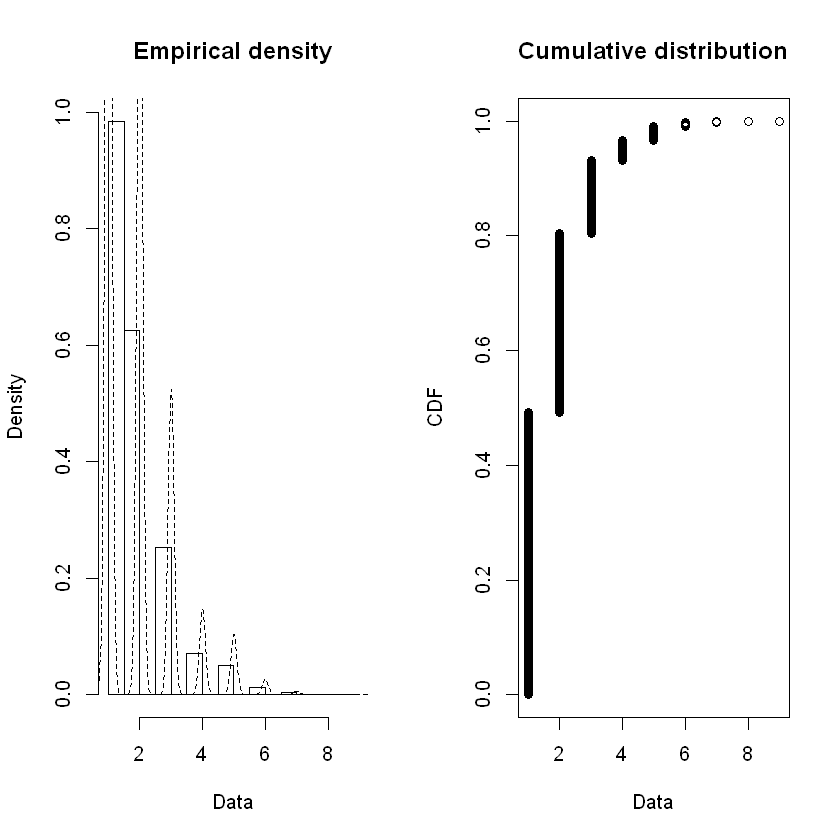

In [131]:
plotdist( wFeb$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  9 
median:  2 
mean:  1.815739 
estimated sd:  1.053266 
estimated skewness:  1.647749 
estimated kurtosis:  6.278035 

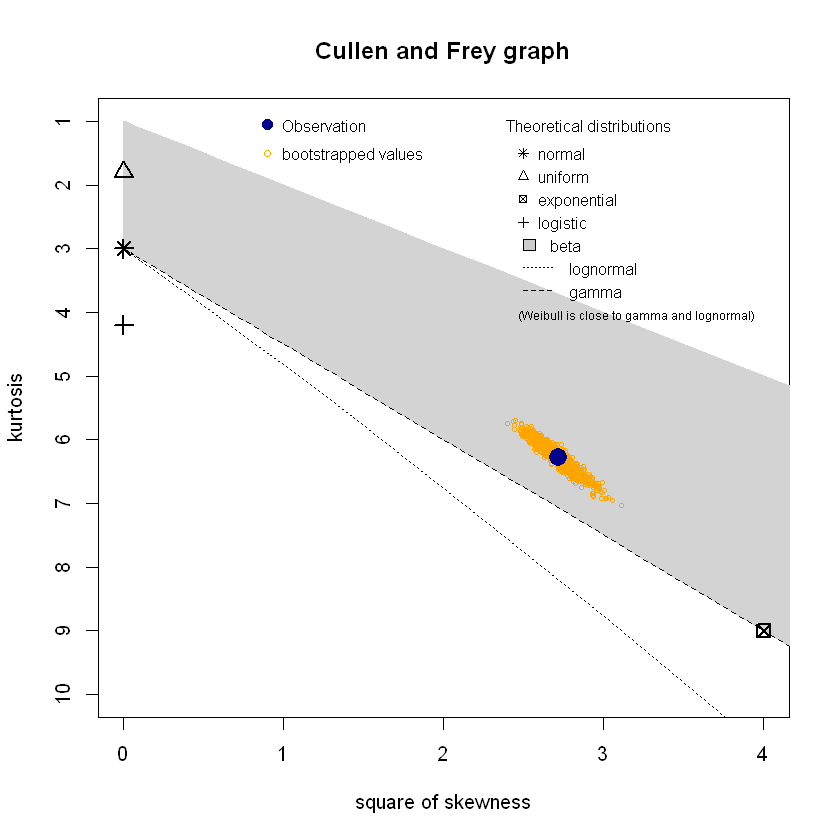

In [132]:
descdist( wFeb$Wet_Count, boot=1000 )

In [133]:
fd_NB_wFeb <- fitdist( wFeb$Wet_Count, "nbinom" )
fd_GE_wFeb <- fitdist( wFeb$Wet_Count, "geom" )

Warning message in sqrt(diag(varcovar)):
"NaNs produced"Warning message in sqrt(1/diag(V)):
"NaNs produced"Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"

In [134]:
fdNB_wFeb_size <- fd_NB_wFeb$estimate[["size"]]
fdNB_wFeb_mu <- fd_NB_wFeb$estimate[["mu"]]
cat("Feb size: ", fdNB_wFeb_size, "\n", "Feb mu: ", fdNB_wFeb_mu, "\n")

Feb size:  1958205 
 Feb mu:  1.815874 


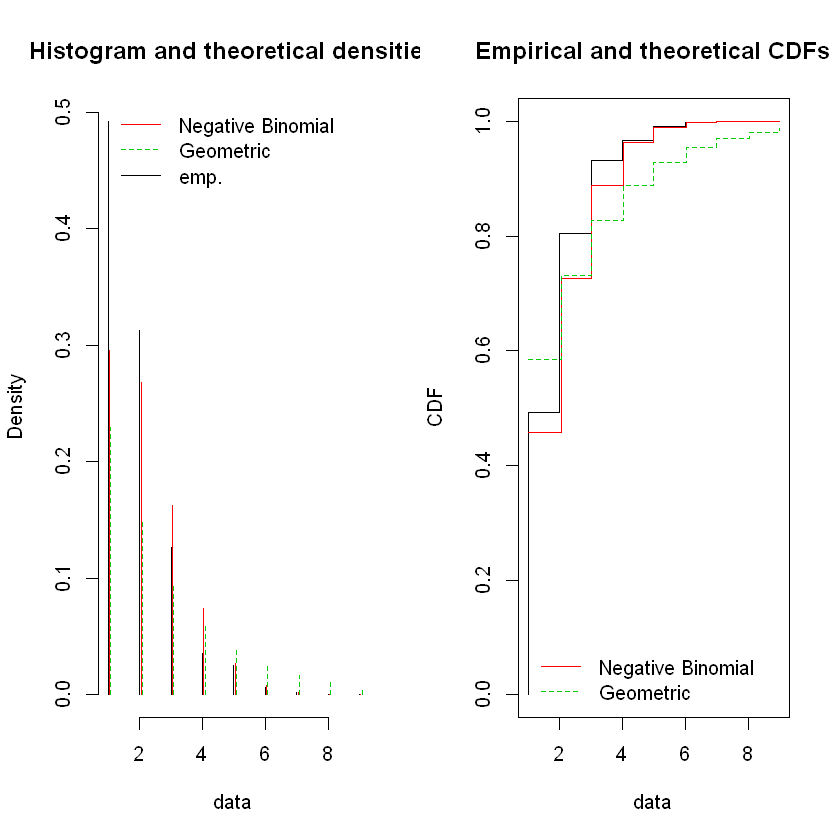

In [135]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wFeb, fd_GE_wFeb), legendtext=plot.legend )
cdfcomp( list(fd_NB_wFeb, fd_GE_wFeb), legendtext=plot.legend )

In [136]:
statRes <- gofstat( list(fd_NB_wFeb, fd_GE_wFeb), fitnames=c("Negative Binomial", "Geometric") )

In [137]:
print(statRes)

Chi-squared statistic:  665.2764 4845.221 
Degree of freedom of the Chi-squared distribution:  3 4 
Chi-squared p-value:  7.098435e-144 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      8463              7876.6366     10043.5325
<= 2      5379              4611.7826      2539.1088
<= 3      2169              2791.4730      1637.3530
<= 4       607              1267.2419      1055.8527
<= 5       431               460.2309       680.8703
> 5        144               185.6350      1236.2826

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          50477.45  62991.92
Bayesian Information Criterion          50492.96  62999.67


In [138]:
fdNB_wFeb_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [139]:
fdNB_wFeb_p = fdNB_wFeb_size / (fdNB_wFeb_size + fdNB_wFeb_mu)
cat("prob: ", fdNB_wFeb_p)

prob:  0.9999991

In [140]:
MonDistDF[2, ] <- list( 2, wFebMean, wFebBNr, fdNB_wFeb_p, fdNB_wFeb_mu, fdNB_wFeb_size,
                        fdNB_wFeb_pvalue )

In [141]:
gf_wFeb <- goodfit( wFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wFeb_size, prob=fdNB_wFeb_p) )

In [142]:
summary( gf_wFeb )

Warning message in summary.goodfit(gf_wFeb):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          5674.677  9        0
Likelihood Ratio 8182.071  8        0


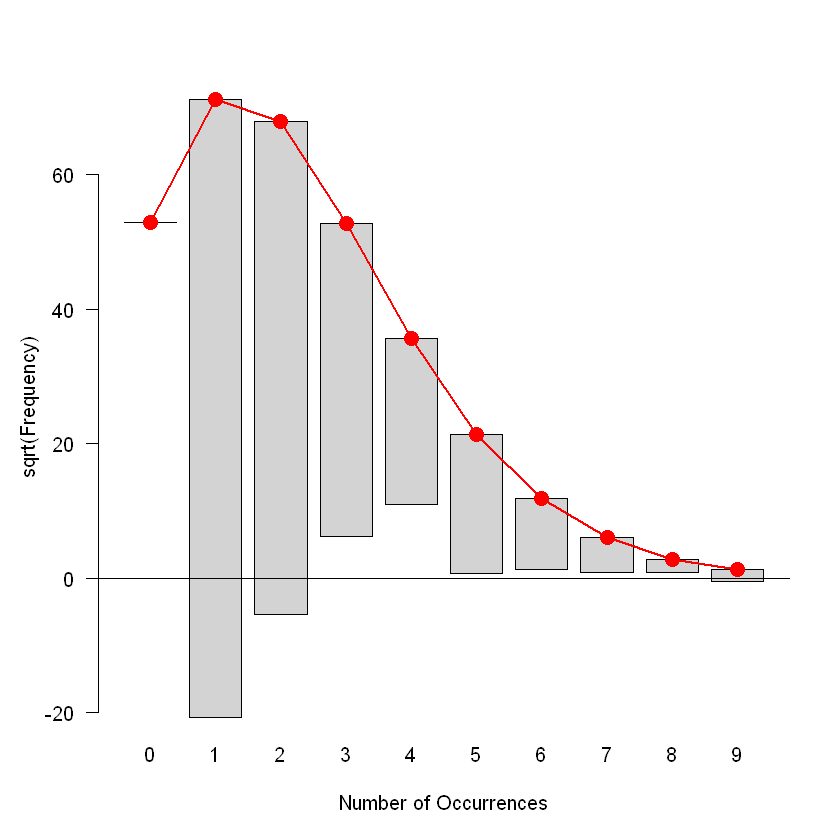

In [143]:
plot( gf_wFeb )

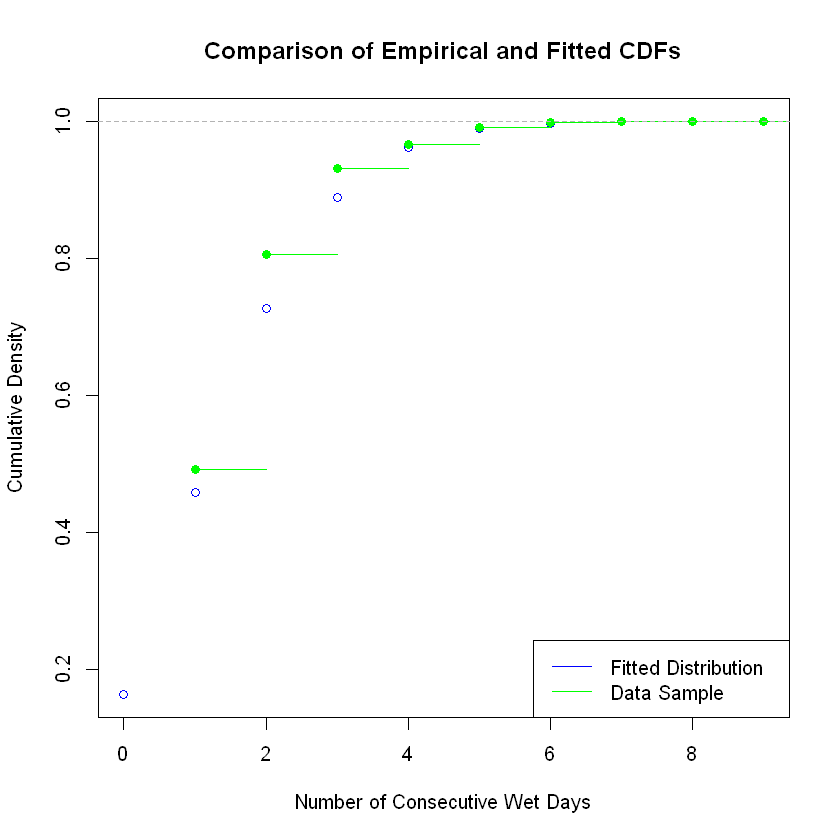

In [144]:
x <- seq(0,wFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wFeb_mu, size=fdNB_wFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

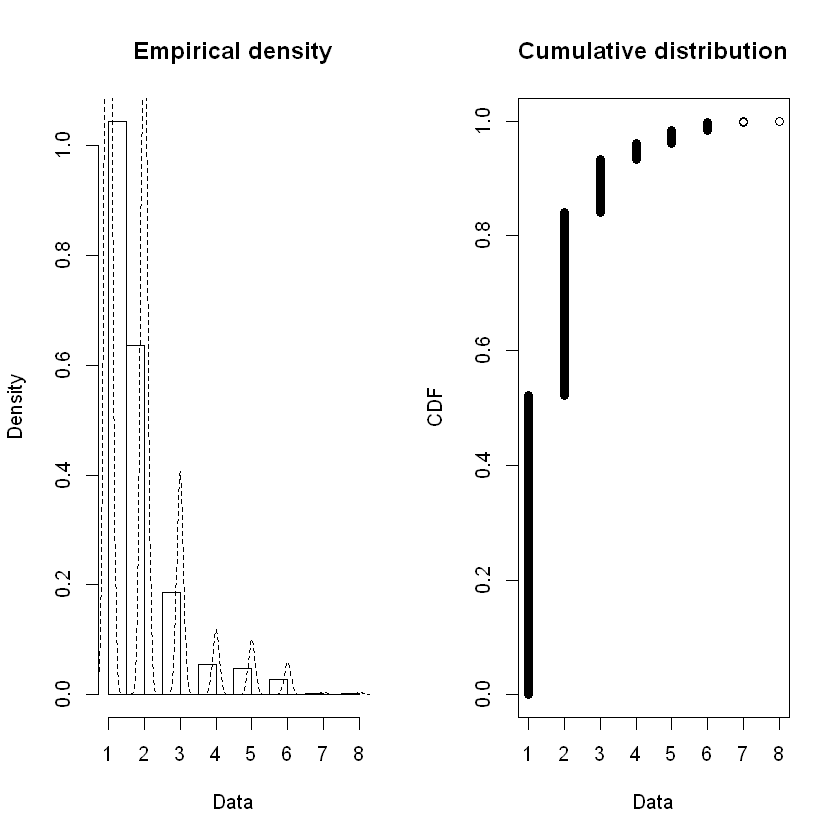

In [145]:
plotdist( wMar$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  8 
median:  1 
mean:  1.761789 
estimated sd:  1.076056 
estimated skewness:  1.987432 
estimated kurtosis:  7.694391 

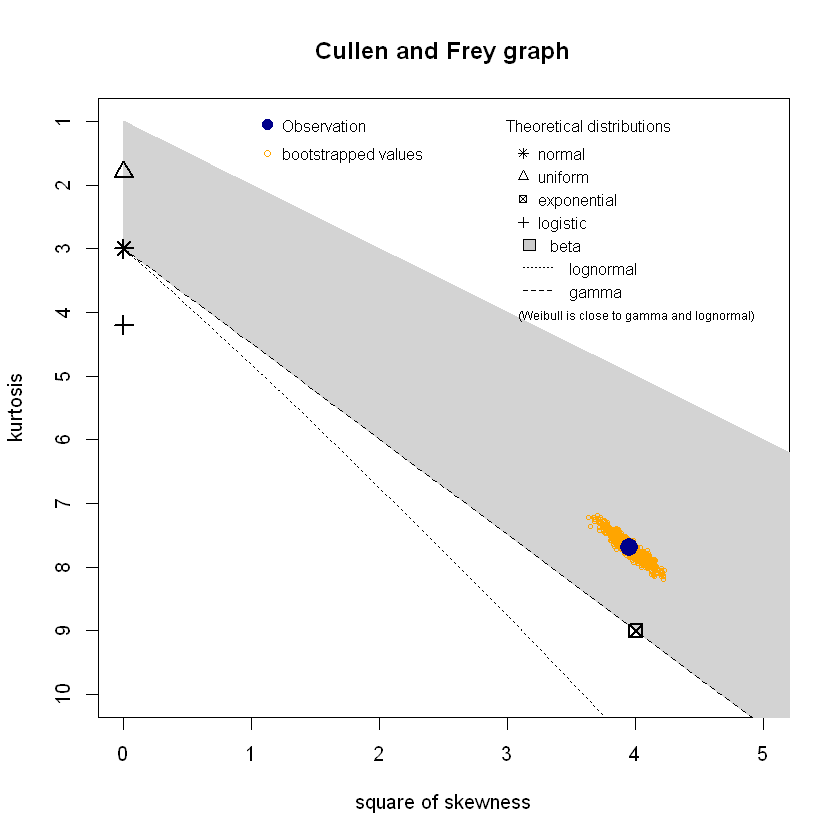

In [146]:
descdist( wMar$Wet_Count, boot=1000 )

In [147]:
fd_NB_wMar <- fitdist( wMar$Wet_Count, "nbinom" )
fd_GE_wMar <- fitdist( wMar$Wet_Count, "geom" )

In [148]:
fdNB_wMar_size <- fd_NB_wMar$estimate[["size"]]
fdNB_wMar_mu <- fd_NB_wMar$estimate[["mu"]]
cat("Mar size: ", fdNB_wMar_size, "\n", "Mar mu: ", fdNB_wMar_mu, "\n")

Mar size:  8392017 
 Mar mu:  1.761965 


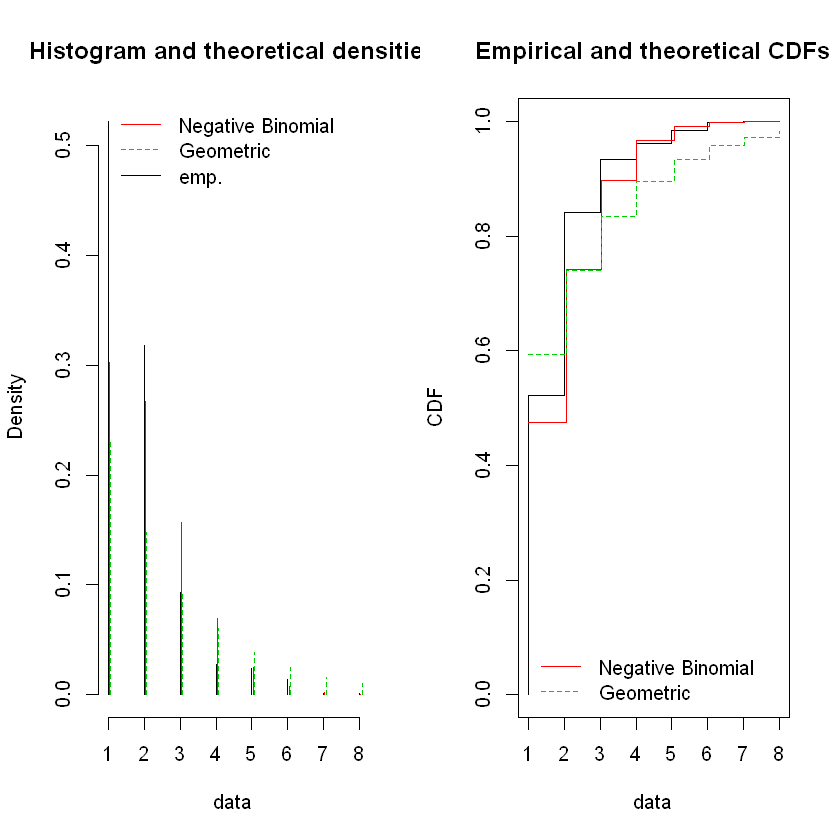

In [149]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wMar, fd_GE_wMar), legendtext=plot.legend )
cdfcomp( list(fd_NB_wMar, fd_GE_wMar), legendtext=plot.legend )

In [150]:
statRes <- gofstat( list(fd_NB_wMar, fd_GE_wMar), fitnames=c("Negative Binomial", "Geometric") )

In [151]:
print(statRes)

Chi-squared statistic:  1453.746 5641.643 
Degree of freedom of the Chi-squared distribution:  3 4 
Chi-squared p-value:  6.405878e-315 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1     10916              9916.5475     12400.9562
<= 2      6653              5573.2288      3080.9903
<= 3      1953              3273.2785      1965.4124
<= 4       572              1441.8509      1253.7676
<= 5       489               508.0984       799.7982
> 5        327               196.9959      1409.0753

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          61048.82  75607.91
Bayesian Information Criterion          61064.71  75615.86


In [152]:
fdNB_wMar_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [153]:
fdNB_wMar_p = fdNB_wMar_size / (fdNB_wMar_size + fdNB_wMar_mu)
cat("prob: ", fdNB_wMar_p)

prob:  0.9999998

In [154]:
MonDistDF[3, ] <- list( 3, wMarMean, wMarBNr, fdNB_wMar_p, fdNB_wMar_mu, fdNB_wMar_size,
                        fdNB_wMar_pvalue )

In [155]:
gf_wMar <- goodfit( wMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wMar_size, prob=fdNB_wMar_p) )

In [156]:
summary( gf_wMar )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson           8324.456  8        0
Likelihood Ratio 11532.612  7        0


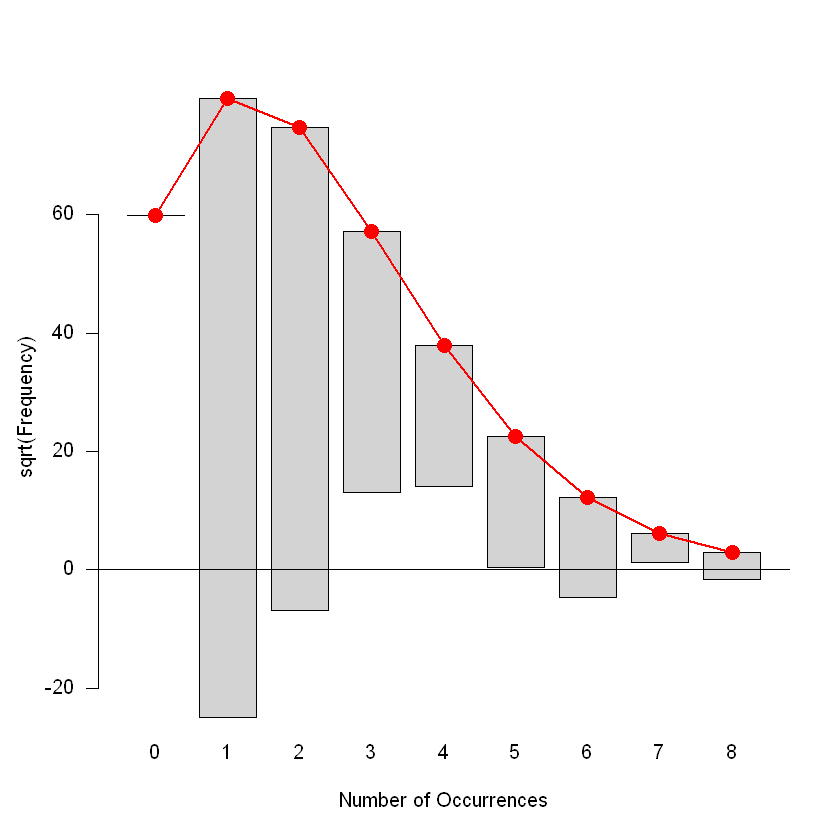

In [157]:
plot( gf_wMar )

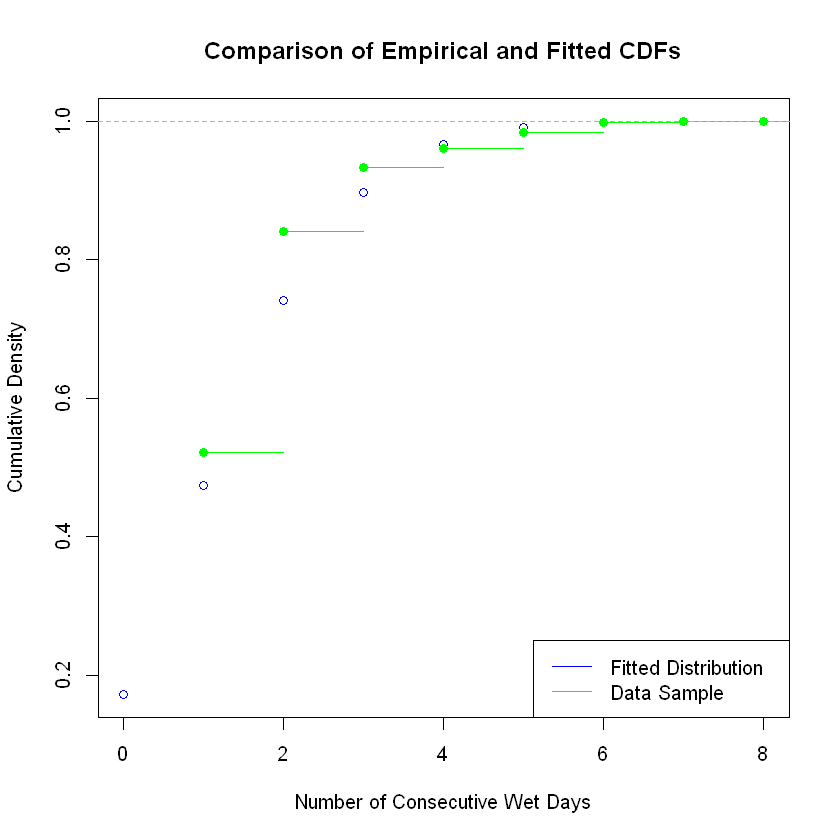

In [158]:
x <- seq(0,wMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wMar_mu, size=fdNB_wMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

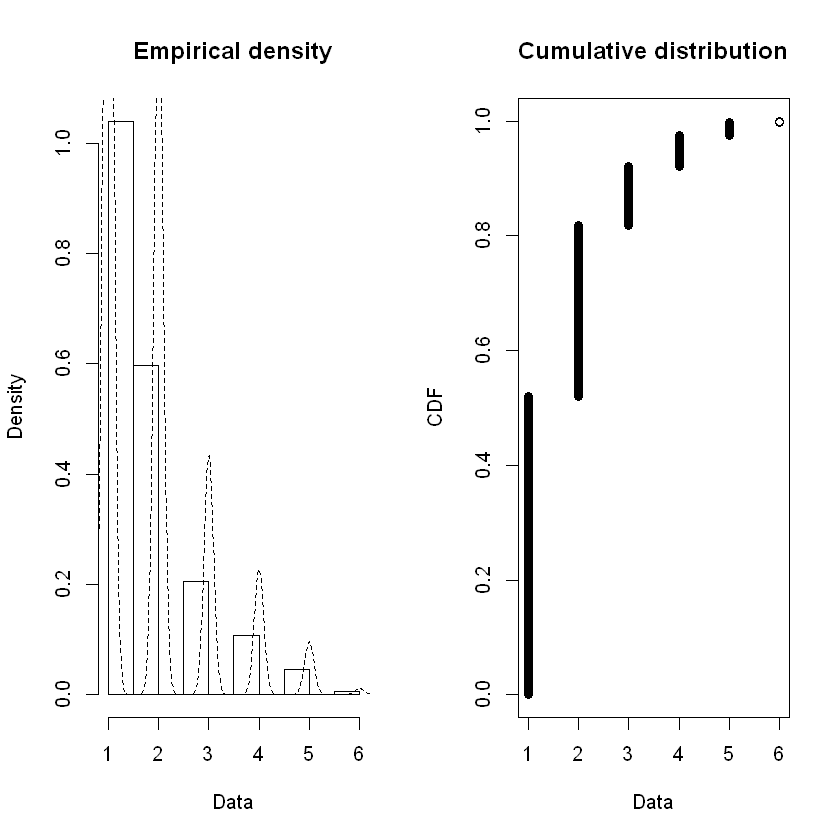

In [159]:
plotdist( wApr$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  6 
median:  1 
mean:  1.768595 
estimated sd:  1.01503 
estimated skewness:  1.453096 
estimated kurtosis:  4.766524 

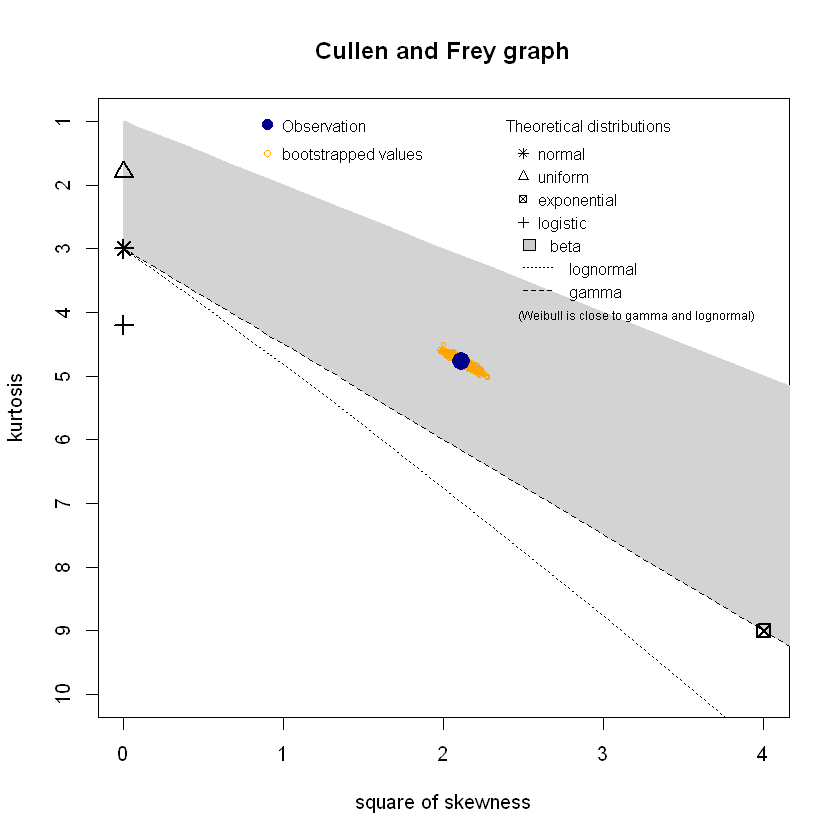

In [160]:
descdist( wApr$Wet_Count, boot=1000 )

In [161]:
fd_NB_wApr <- fitdist( wApr$Wet_Count, "nbinom" )
fd_GE_wApr <- fitdist( wApr$Wet_Count, "geom" )

Warning message in sqrt(diag(varcovar)):
"NaNs produced"Warning message in sqrt(1/diag(V)):
"NaNs produced"Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"

In [162]:
fdNB_wApr_size <- fd_NB_wApr$estimate[["size"]]
fdNB_wApr_mu <- fd_NB_wApr$estimate[["mu"]]
cat("Apr size: ", fdNB_wApr_size, "\n", "Apr mu: ", fdNB_wApr_mu, "\n")

Apr size:  1958205 
 Apr mu:  1.768731 


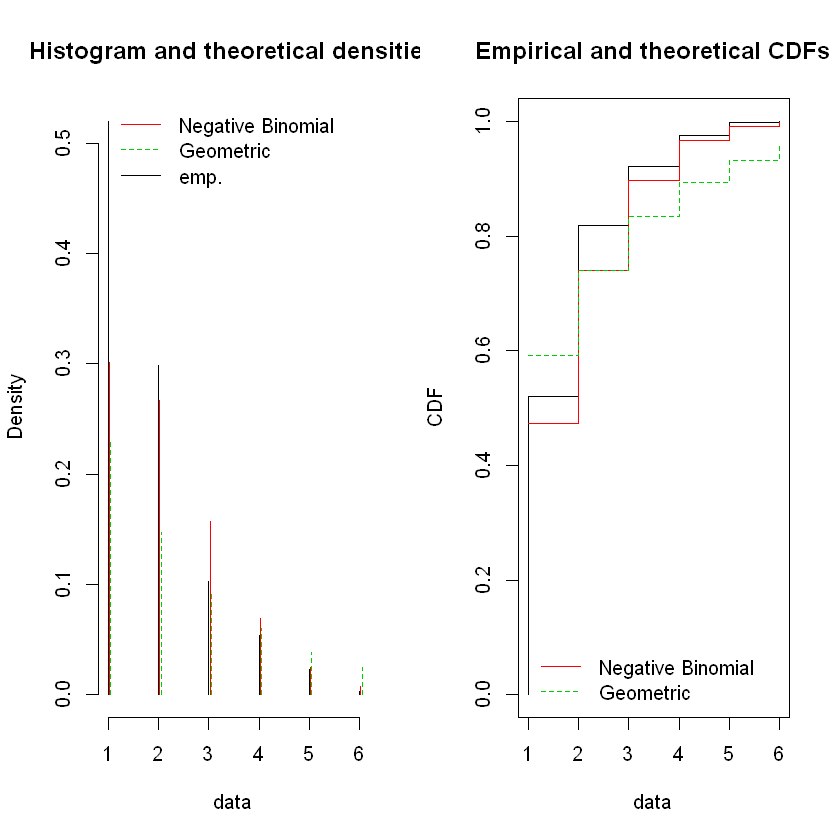

In [163]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wApr, fd_GE_wApr), legendtext=plot.legend )
cdfcomp( list(fd_NB_wApr, fd_GE_wApr), legendtext=plot.legend )

In [164]:
statRes <- gofstat( list(fd_NB_wApr, fd_GE_wApr), fitnames=c("Negative Binomial", "Geometric") )

In [165]:
print(statRes)

Chi-squared statistic:  673.4698 4325.906 
Degree of freedom of the Chi-squared distribution:  3 4 
Chi-squared p-value:  1.1875e-145 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      9629              8741.9373     10958.3433
<= 2      5520              4938.7839      2728.6969
<= 3      1899              2911.7929      1743.1079
<= 4       997              1287.5450      1113.5077
<= 5       420               455.4646       711.3154
> 5         48               177.4763      1258.0288

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          53597.57  67054.01
Bayesian Information Criterion          53613.22  67061.83


In [166]:
fdNB_wApr_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [167]:
fdNB_wApr_p = fdNB_wApr_size / (fdNB_wApr_size + fdNB_wApr_mu)
cat("prob: ", fdNB_wApr_p)

prob:  0.9999991

In [168]:
MonDistDF[4, ] <- list( 4, wAprMean, wAprBNr, fdNB_wApr_p, fdNB_wApr_mu, fdNB_wApr_size,
                        fdNB_wApr_pvalue )

In [169]:
gf_wApr <- goodfit( wApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wApr_size, prob=fdNB_wApr_p) )

In [170]:
summary( gf_wApr )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          6669.909  6        0
Likelihood Ratio 9419.355  5        0


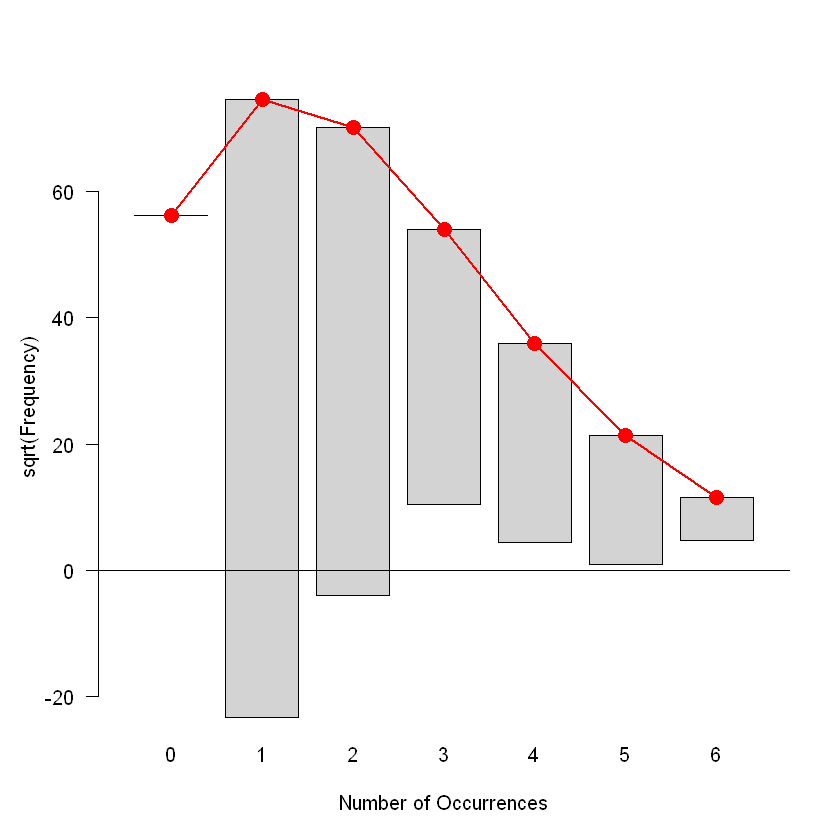

In [171]:
plot( gf_wApr )

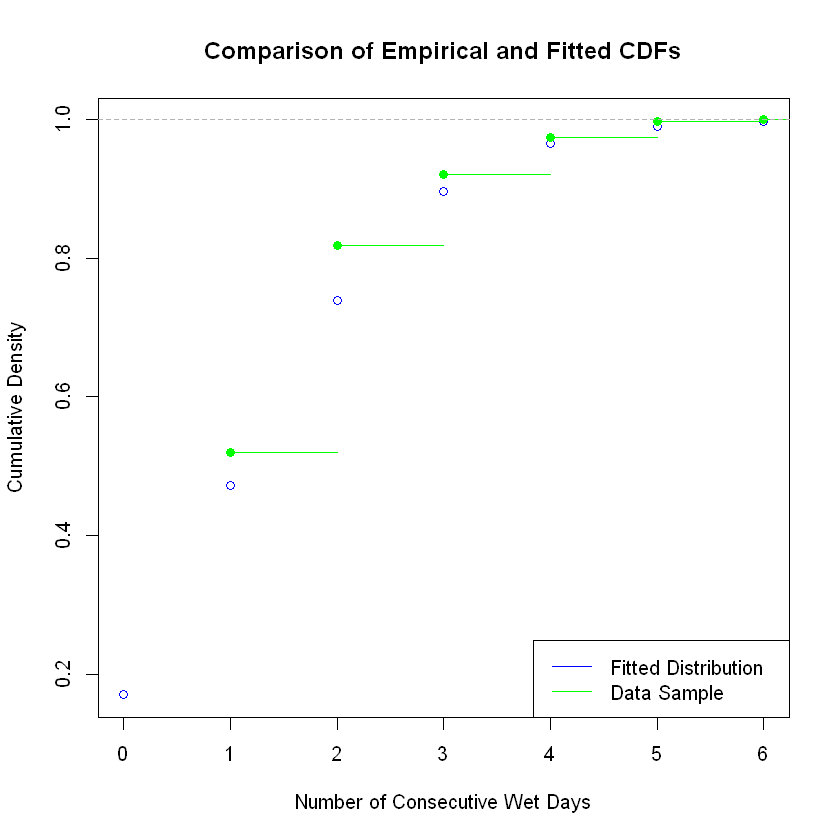

In [172]:
x <- seq(0,wAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wApr_mu, size=fdNB_wApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

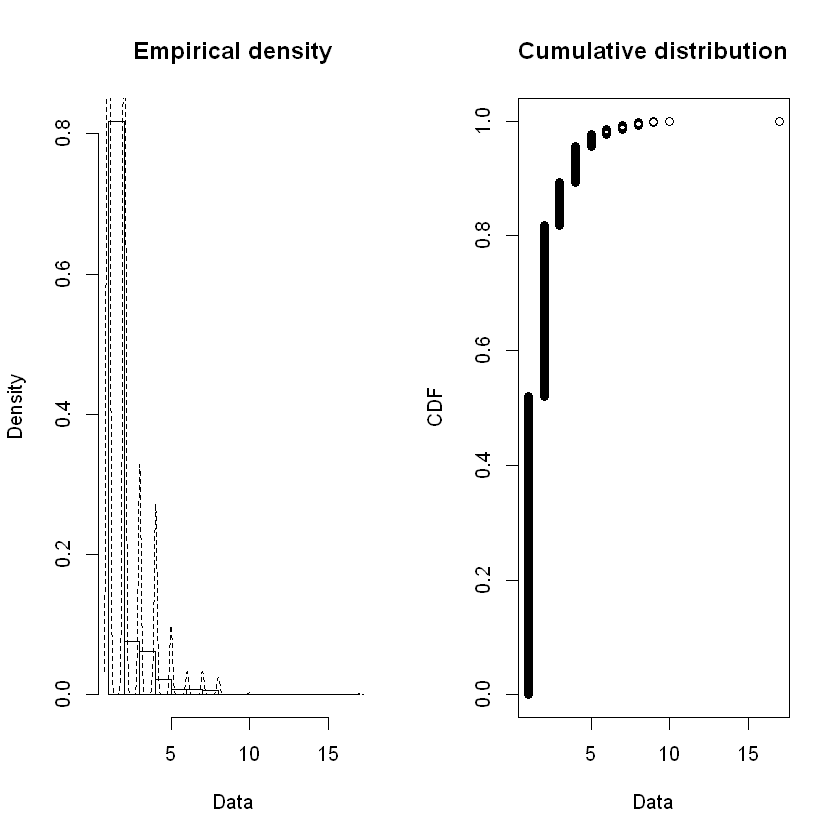

In [173]:
plotdist( wMay$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  17 
median:  1 
mean:  1.862177 
estimated sd:  1.305705 
estimated skewness:  2.757098 
estimated kurtosis:  17.13809 

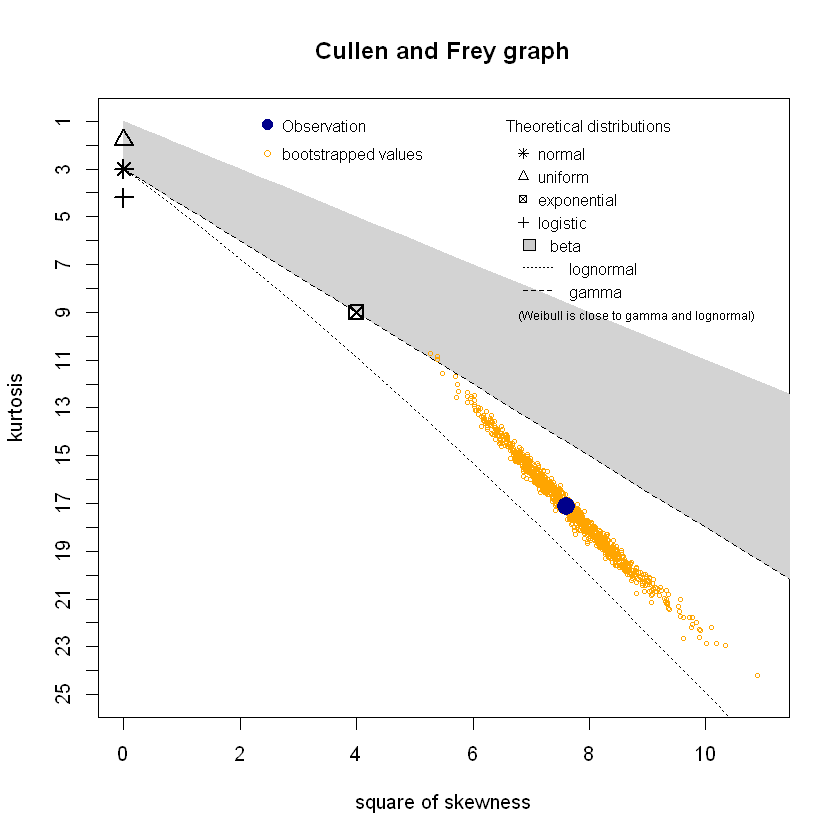

In [174]:
descdist( wMay$Wet_Count, boot=1000 )

In [175]:
fd_NB_wMay <- fitdist( wMay$Wet_Count, "nbinom" )
fd_GE_wMay <- fitdist( wMay$Wet_Count, "geom" )

Warning message in sqrt(diag(varcovar)):
"NaNs produced"Warning message in sqrt(1/diag(V)):
"NaNs produced"Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"

In [176]:
fdNB_wMay_size <- fd_NB_wMay$estimate[["size"]]
fdNB_wMay_mu <- fd_NB_wMay$estimate[["mu"]]
cat("May size: ", fdNB_wMay_size, "\n", "May mu: ", fdNB_wMay_mu, "\n")

May size:  281059.9 
 May mu:  1.862747 


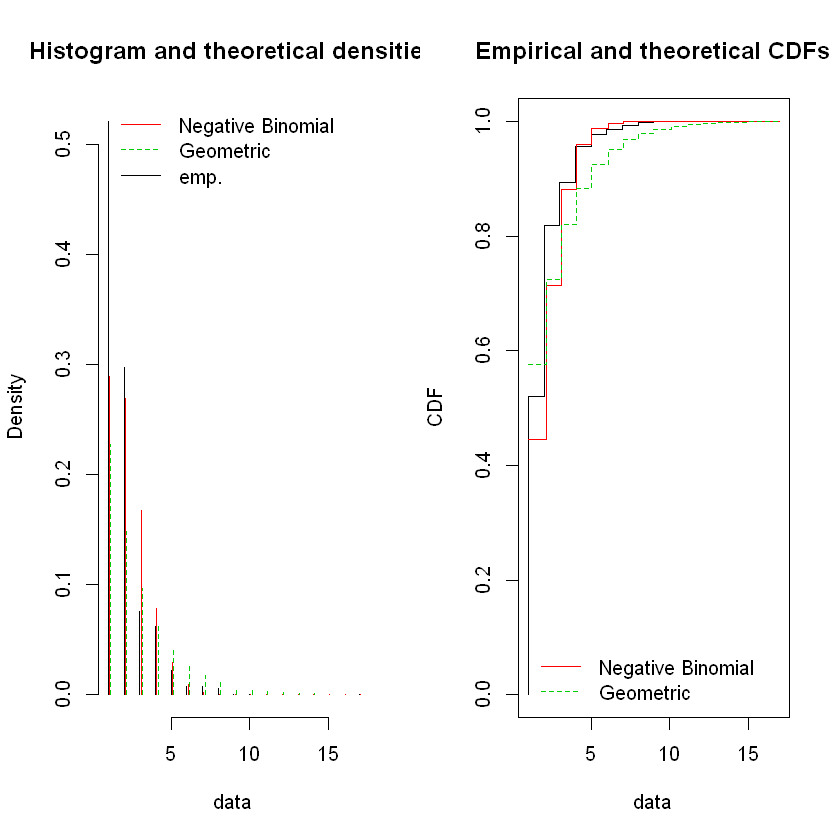

In [177]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wMay, fd_GE_wMay), legendtext=plot.legend )
cdfcomp( list(fd_NB_wMay, fd_GE_wMay), legendtext=plot.legend )

In [178]:
statRes <- gofstat( list(fd_NB_wMay, fd_GE_wMay), fitnames=c("Negative Binomial", "Geometric") )

In [179]:
print(statRes)

Chi-squared statistic:  3173.935 5173.115 
Degree of freedom of the Chi-squared distribution:  4 5 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1     12971            11073.40652     14369.0413
<= 2      7408             6710.79250      3684.9430
<= 3      1881             4166.83911      2397.4813
<= 4      1550             1940.45003      1559.8387
<= 5       553              722.91914      1014.8554
<= 7       381              284.16394      1089.8697
> 7        172               17.42876       799.9706

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          77409.75  92291.55
Bayesian Information Criterion          77426.00  92299.67


In [180]:
fdNB_wMay_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [181]:
fdNB_wMay_p = fdNB_wMay_size / (fdNB_wMay_size + fdNB_wMay_mu)
cat("prob: ", fdNB_wMay_p)

prob:  0.9999934

In [182]:
MonDistDF[5, ] <- list( 5, wMayMean, wMayBNr, fdNB_wMay_p, fdNB_wMay_mu, fdNB_wMay_size,
                        fdNB_wMay_pvalue )

In [183]:
gf_wMay <- goodfit( wMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wMay_size, prob=fdNB_wMay_p) )

In [184]:
summary( gf_wMay )

Warning message in summary.goodfit(gf_wMay):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                         X^2 df P(> X^2)
Pearson          356074333.4 17        0
Likelihood Ratio     14303.2 10        0


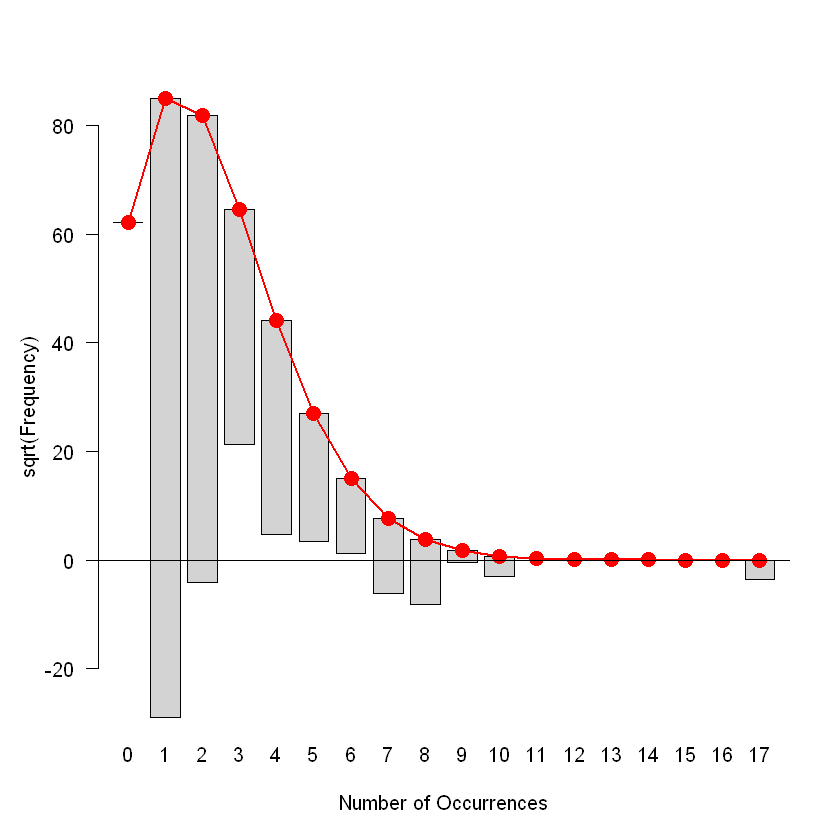

In [185]:
plot( gf_wMay )

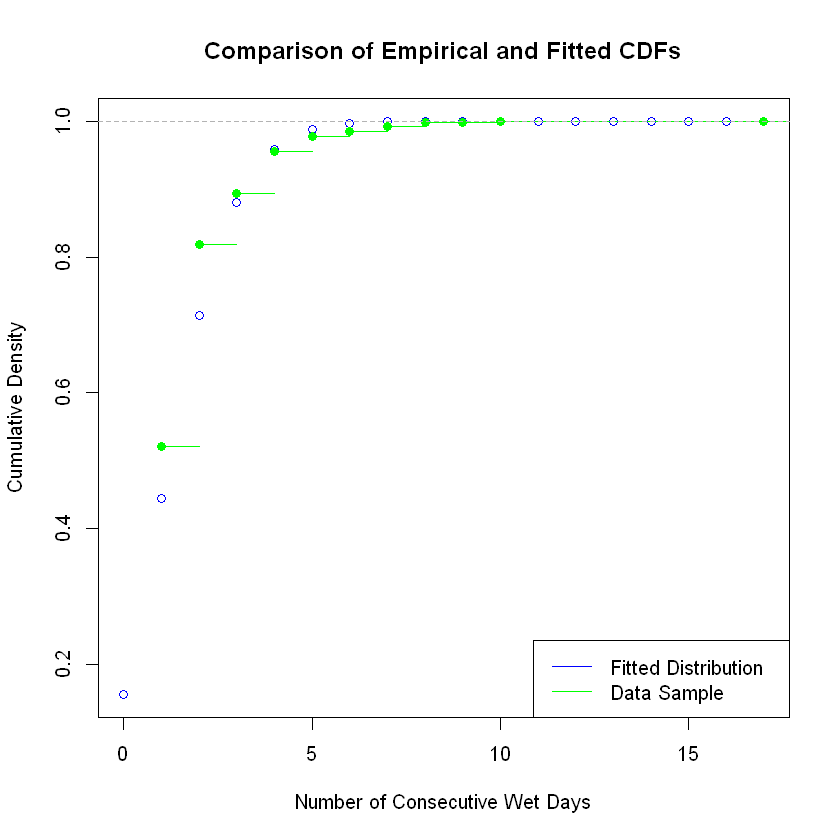

In [186]:
x <- seq(0,wMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wMay_mu, size=fdNB_wMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

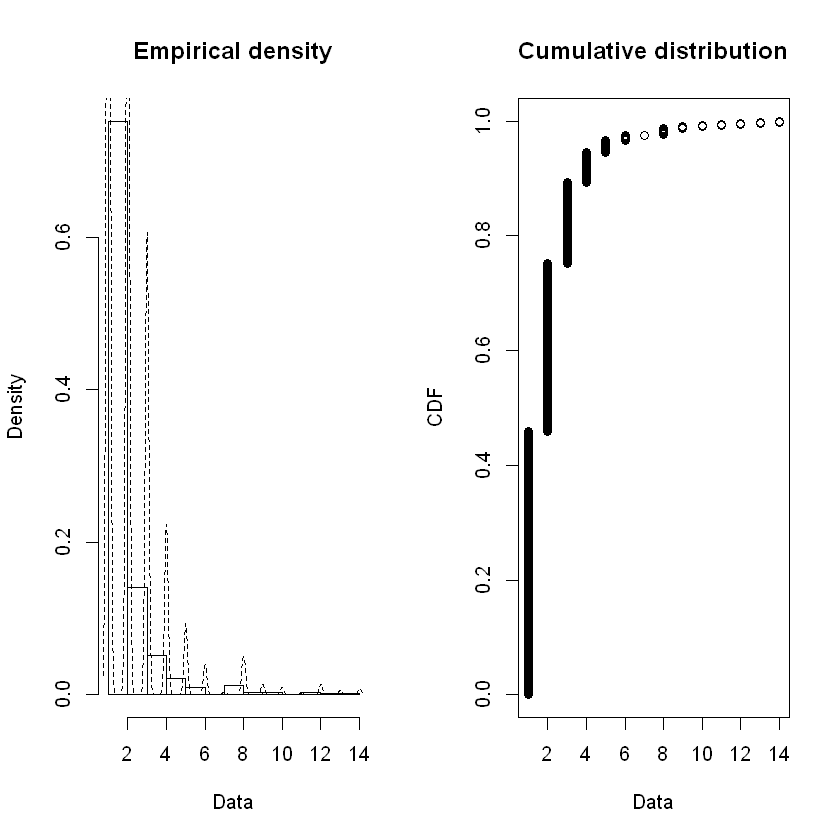

In [187]:
plotdist( wJun$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  14 
median:  2 
mean:  2.07189 
estimated sd:  1.630758 
estimated skewness:  3.225279 
estimated kurtosis:  17.80913 

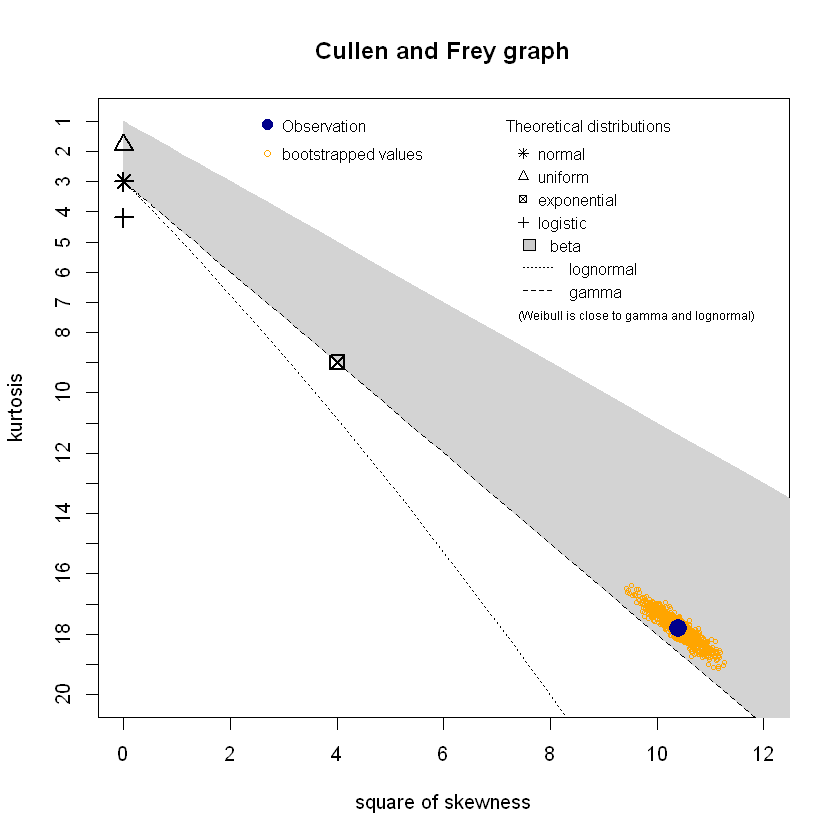

In [188]:
descdist( wJun$Wet_Count, boot=1000 )

In [189]:
fd_NB_wJun <- fitdist( wJun$Wet_Count, "nbinom" )
fd_GE_wJun <- fitdist( wJun$Wet_Count, "geom" )

In [190]:
fdNB_wJun_size <- fd_NB_wJun$estimate[["size"]]
fdNB_wJun_mu <- fd_NB_wJun$estimate[["mu"]]
cat("Jun size: ", fdNB_wJun_size, "\n", "Jun mu: ", fdNB_wJun_mu, "\n")

Jun size:  15.46611 
 Jun mu:  2.071984 


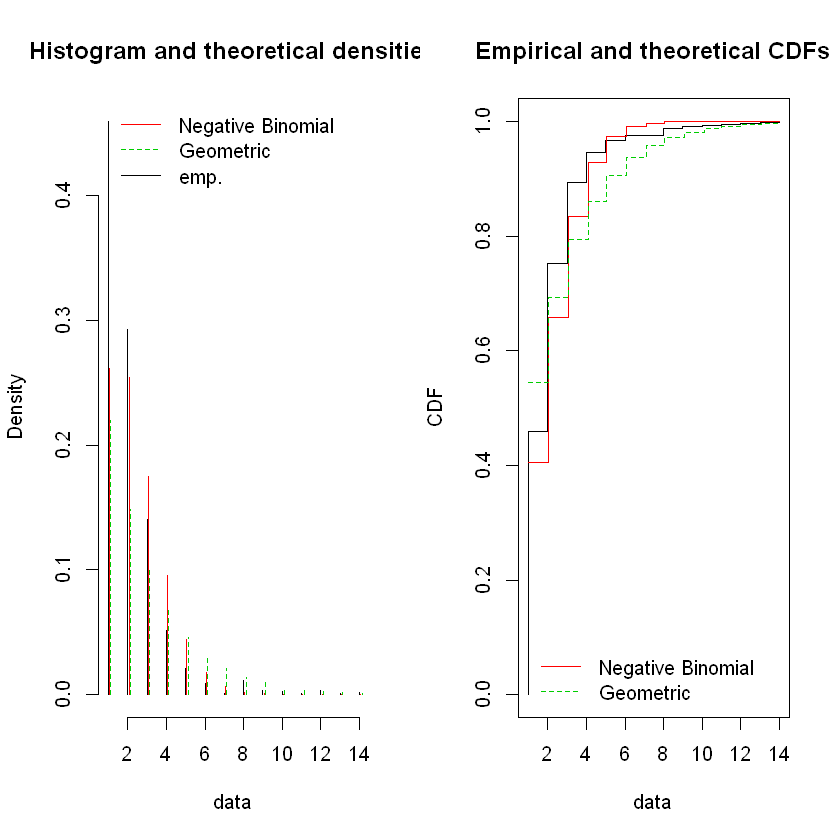

In [191]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wJun, fd_GE_wJun), legendtext=plot.legend )
cdfcomp( list(fd_NB_wJun, fd_GE_wJun), legendtext=plot.legend )

In [192]:
statRes <- gofstat( list(fd_NB_wJun, fd_GE_wJun), fitnames=c("Negative Binomial", "Geometric") )

In [193]:
print(statRes)

Chi-squared statistic:  4450.491 5161.774 
Degree of freedom of the Chi-squared distribution:  4 5 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1     10451             9198.85647     12397.0624
<= 2      6660             5782.66691      3367.9385
<= 3      3201             3977.47256      2271.5652
<= 4      1178             2169.33536      1532.0970
<= 5       486              997.79181      1033.3497
<= 8       486              596.10164      1484.0902
> 8        281               20.77526       656.8969

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          76832.53  88166.11
Bayesian Information Criterion          76848.60  88174.15


In [194]:
fdNB_wJun_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [195]:
fdNB_wJun_p = fdNB_wJun_size / (fdNB_wJun_size + fdNB_wJun_mu)
cat("prob: ", fdNB_wJun_p)

prob:  0.8818581

In [196]:
MonDistDF[6, ] <- list( 6, wJunMean, wJunBNr, fdNB_wJun_p, fdNB_wJun_mu, fdNB_wJun_size,
                        fdNB_wJun_pvalue )

In [197]:
gf_wJun <- goodfit( wJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wJun_size, prob=fdNB_wJun_p) )

In [198]:
summary( gf_wJun )

Warning message in summary.goodfit(gf_wJun):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          108014.21 14        0
Likelihood Ratio  13006.62 13        0


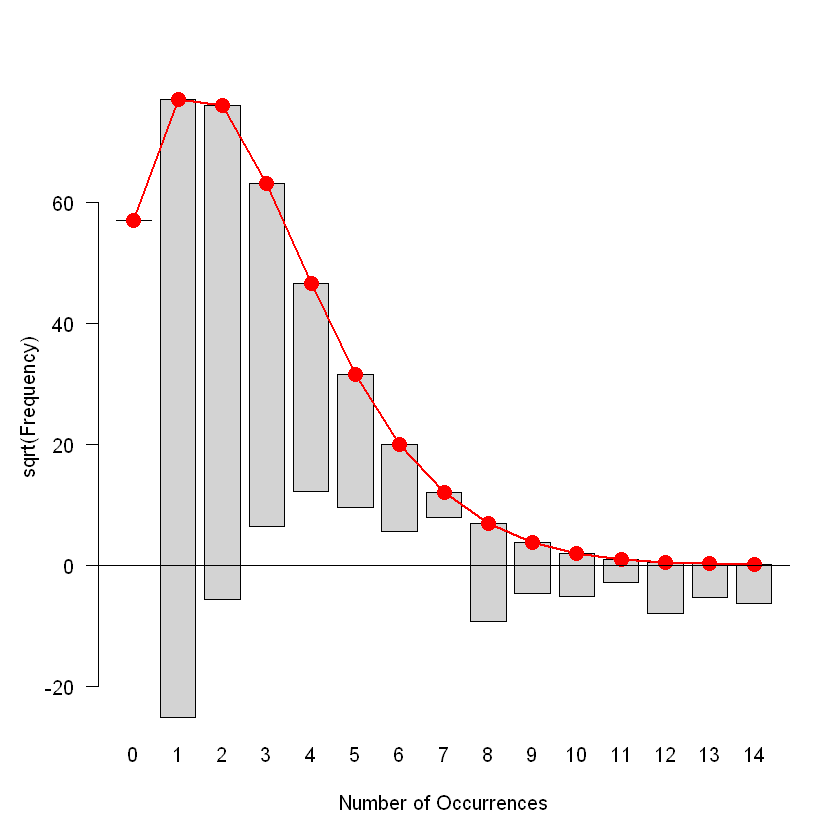

In [199]:
plot( gf_wJun )

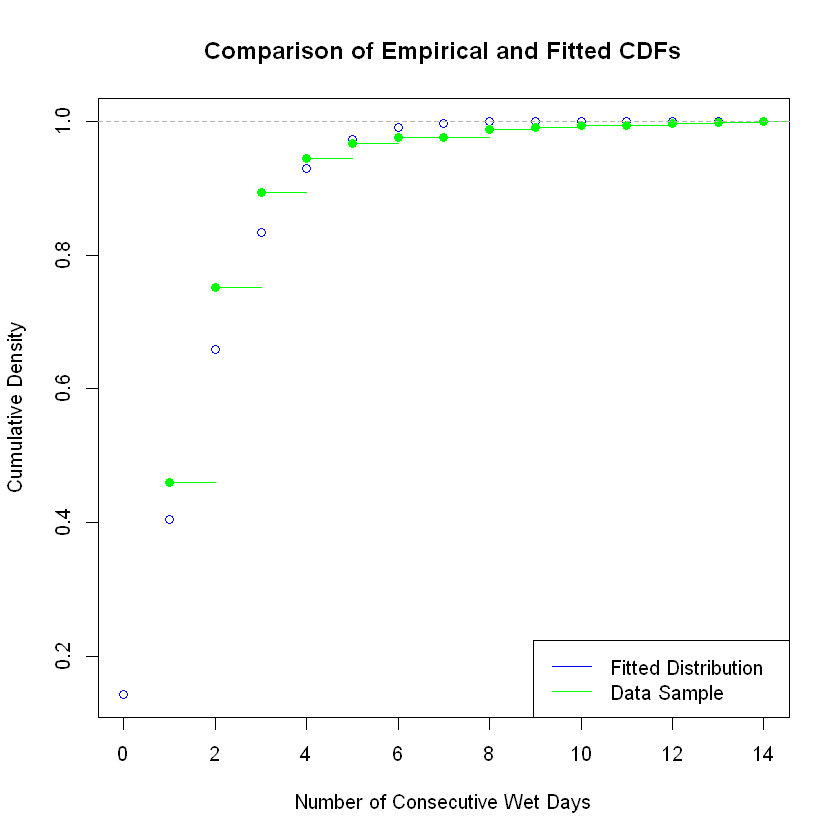

In [200]:
x <- seq(0,wJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wJun_mu, size=fdNB_wJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

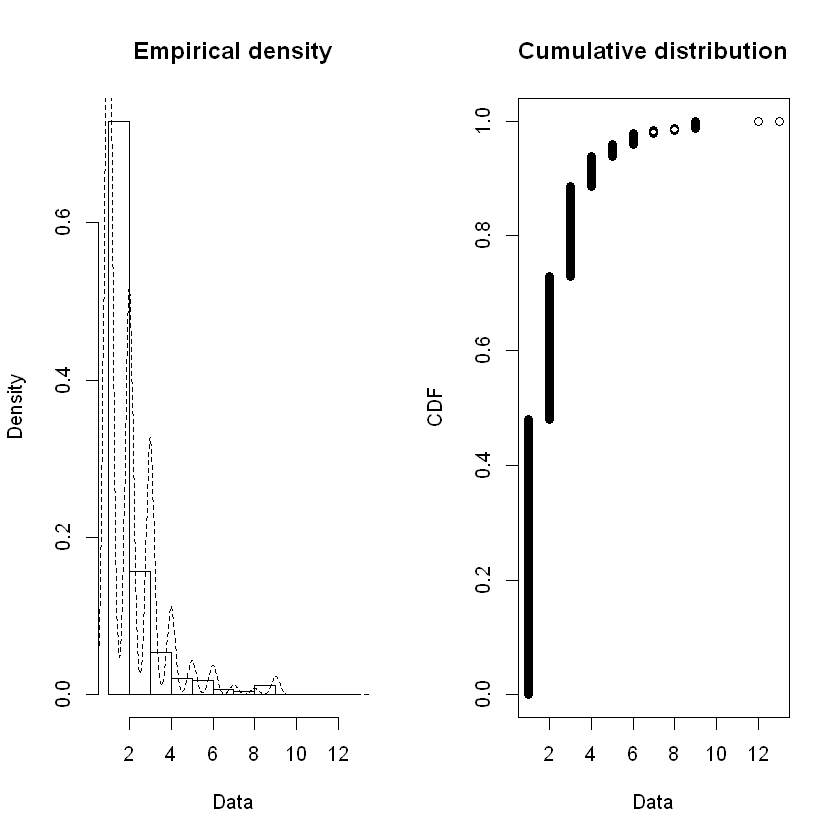

In [201]:
plotdist( wJul$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  13 
median:  2 
mean:  2.056709 
estimated sd:  1.49449 
estimated skewness:  2.279548 
estimated kurtosis:  9.914599 

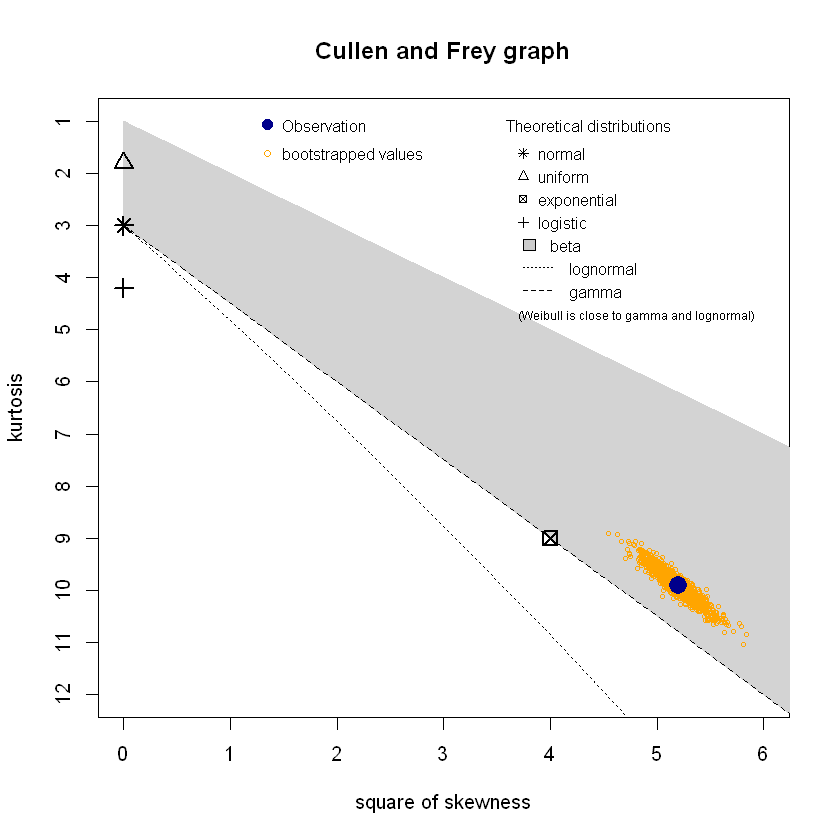

In [202]:
descdist( wJul$Wet_Count, boot=1000 )

In [203]:
fd_NB_wJul <- fitdist( wJul$Wet_Count, "nbinom" )
fd_GE_wJul <- fitdist( wJul$Wet_Count, "geom" )

In [204]:
fdNB_wJul_size <- fd_NB_wJul$estimate[["size"]]
fdNB_wJul_mu <- fd_NB_wJul$estimate[["mu"]]
cat("Jul size: ", fdNB_wJul_size, "\n", "Jul mu: ", fdNB_wJul_mu, "\n")

Jul size:  41.0901 
 Jul mu:  2.056711 


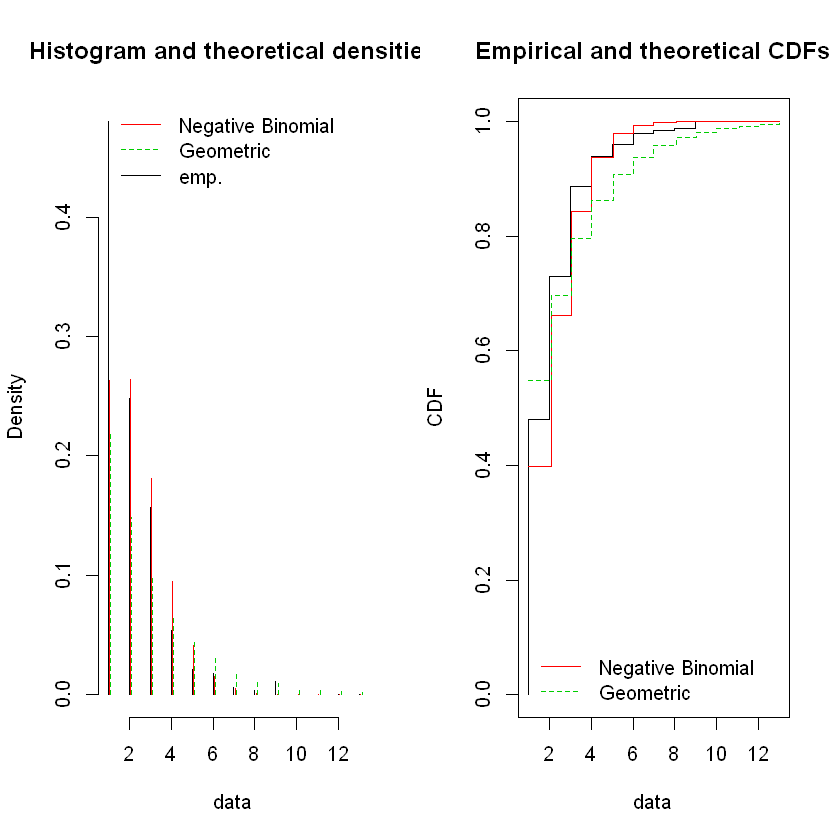

In [205]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wJul, fd_GE_wJul), legendtext=plot.legend )
cdfcomp( list(fd_NB_wJul, fd_GE_wJul), legendtext=plot.legend )

In [206]:
statRes <- gofstat( list(fd_NB_wJul, fd_GE_wJul), fitnames=c("Negative Binomial", "Geometric") )

In [207]:
print(statRes)

Chi-squared statistic:  1466.005 2754.557 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  6.853384e-315 0 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      8328            6893.071826      9486.4093
<= 2      4308            4577.752021      2567.3330
<= 3      2718            3134.246079      1727.4321
<= 4       927            1646.792058      1162.3041
<= 5       365             707.904279       782.0572
<= 6       312             259.212247       526.2078
<= 9       365             113.131660       752.5812
> 9         11               1.889831       329.6754

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          57690.28  66990.02
Bayesian Information Criterion          57705.80  66997.78


In [208]:
fdNB_wJul_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [209]:
fdNB_wJul_p = fdNB_wJul_size / (fdNB_wJul_size + fdNB_wJul_mu)
cat("prob: ", fdNB_wJul_p)

prob:  0.9523323

In [210]:
MonDistDF[7, ] <- list( 7, wJulMean, wJulBNr, fdNB_wJul_p, fdNB_wJul_mu, fdNB_wJul_size,
                        fdNB_wJul_pvalue )

In [211]:
gf_wJul <- goodfit( wJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wJul_size, prob=fdNB_wJul_p) )

In [212]:
summary( gf_wJul )

Warning message in summary.goodfit(gf_wJul):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          13951.349 13        0
Likelihood Ratio  8931.821 10        0


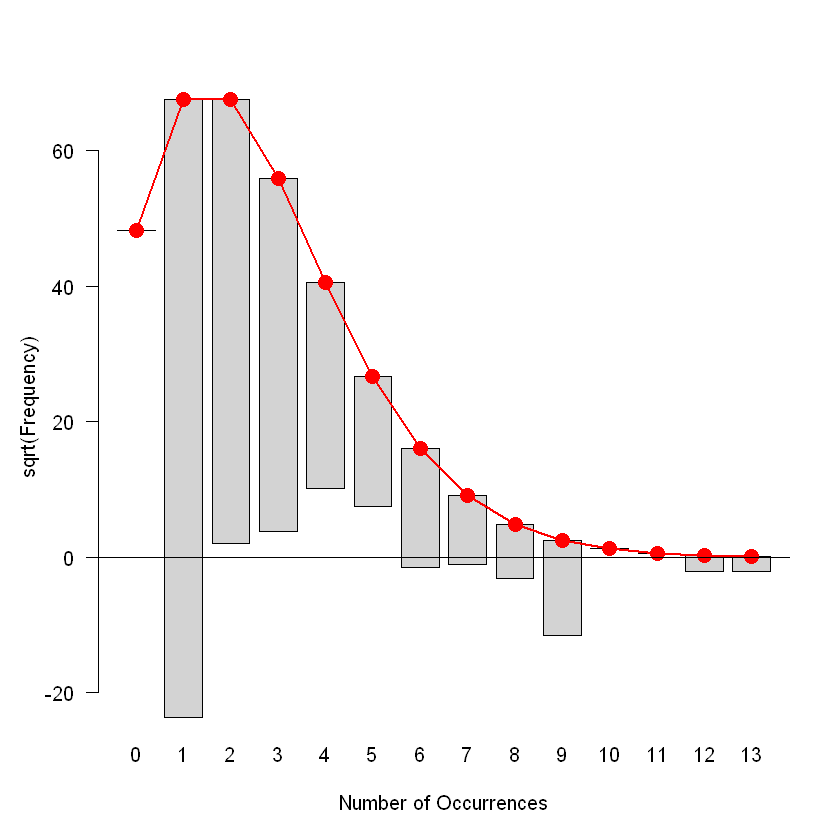

In [213]:
plot( gf_wJul )

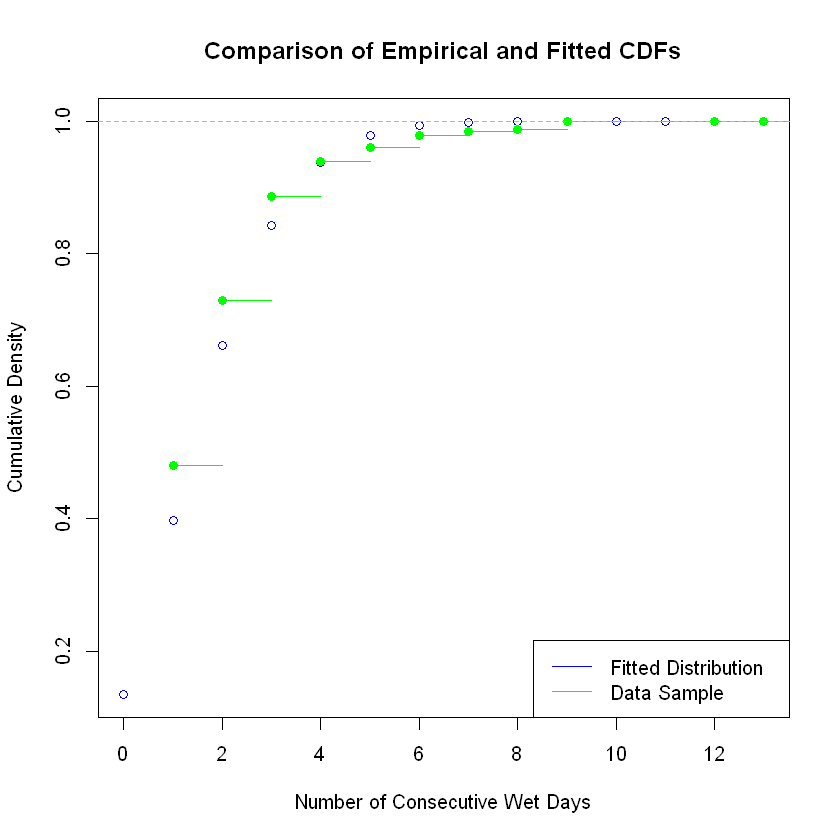

In [214]:
x <- seq(0,wJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wJul_mu, size=fdNB_wJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

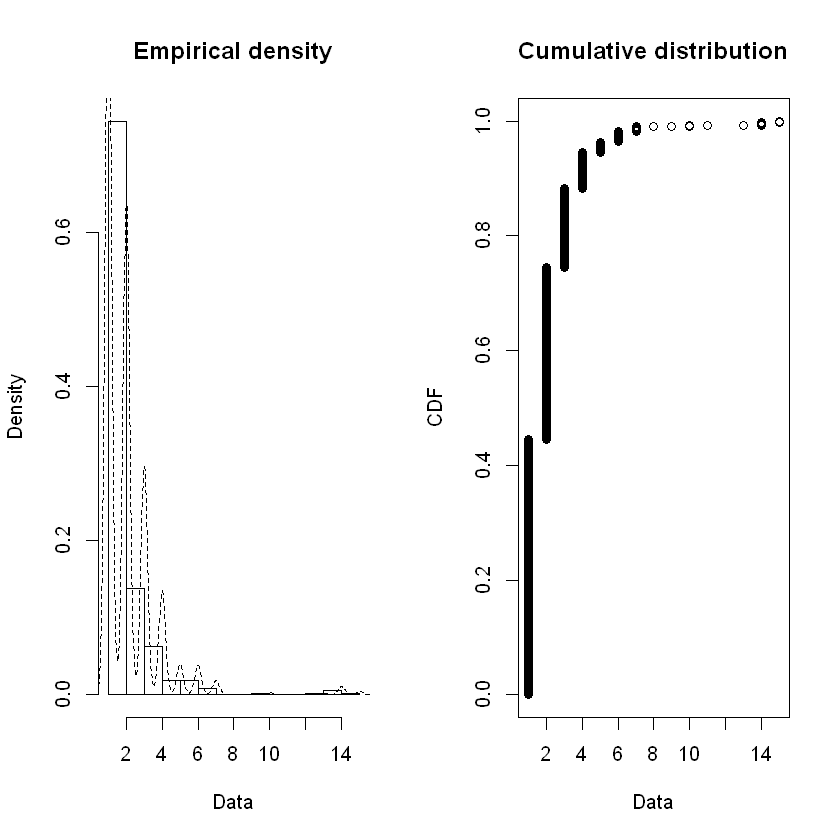

In [215]:
plotdist( wAug$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  15 
median:  2 
mean:  2.098422 
estimated sd:  1.661041 
estimated skewness:  3.725306 
estimated kurtosis:  24.34276 

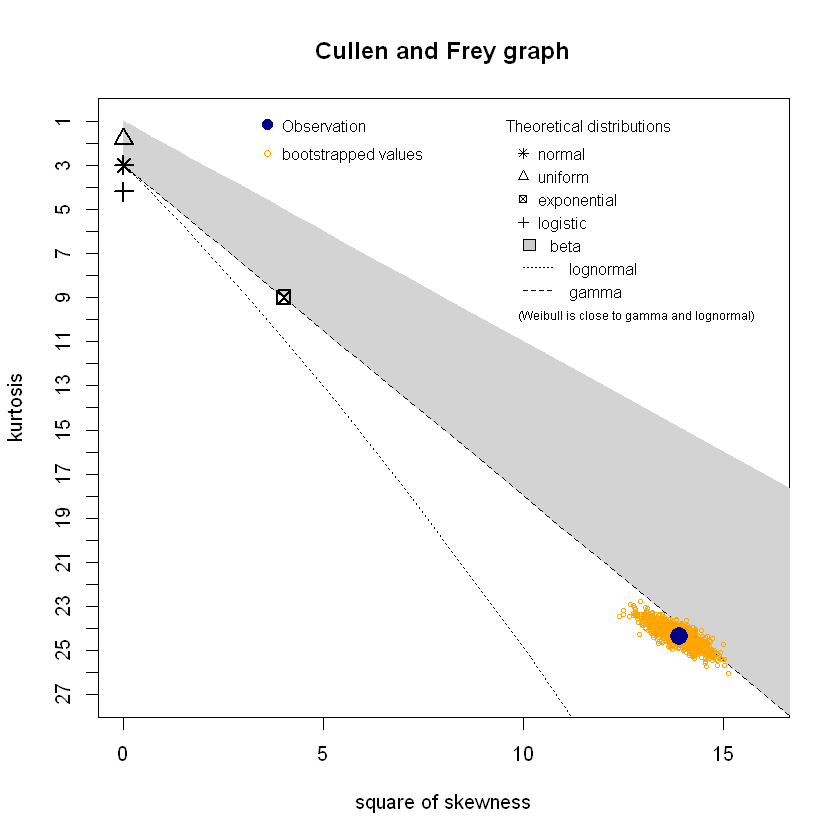

In [216]:
descdist( wAug$Wet_Count, boot=1000 )

In [217]:
fd_NB_wAug <- fitdist( wAug$Wet_Count, "nbinom" )
fd_GE_wAug <- fitdist( wAug$Wet_Count, "geom" )

In [218]:
fdNB_wAug_size <- fd_NB_wAug$estimate[["size"]]
fdNB_wAug_mu <- fd_NB_wAug$estimate[["mu"]]
cat("Aug size: ", fdNB_wAug_size, "\n", "Aug mu: ", fdNB_wAug_mu, "\n")

Aug size:  15.331 
 Aug mu:  2.09858 


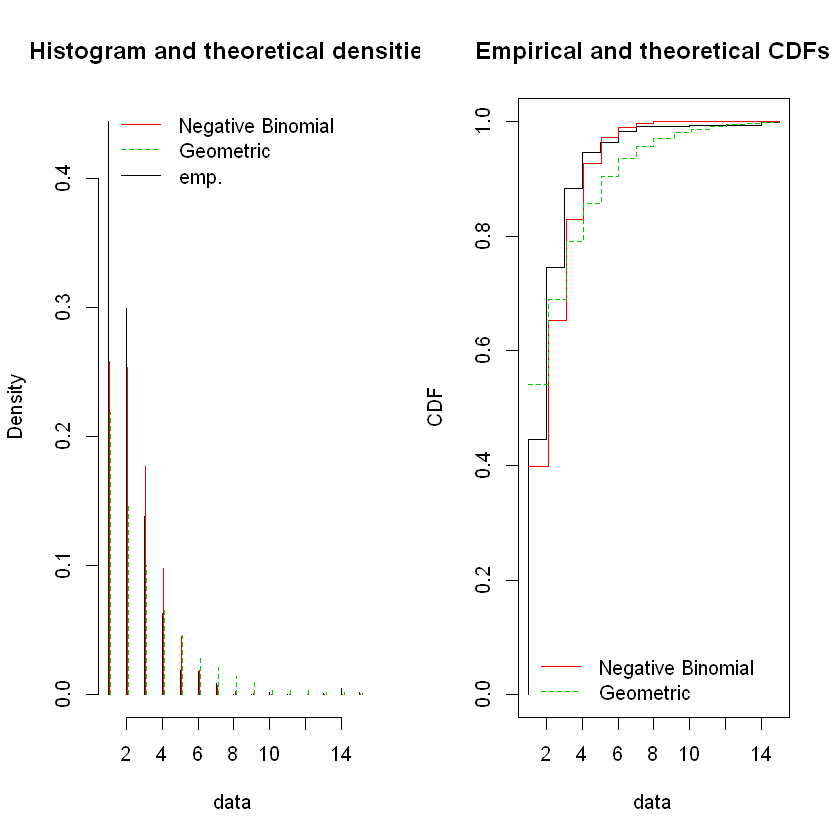

In [219]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wAug, fd_GE_wAug), legendtext=plot.legend )
cdfcomp( list(fd_NB_wAug, fd_GE_wAug), legendtext=plot.legend )

In [220]:
statRes <- gofstat( list(fd_NB_wAug, fd_GE_wAug), fitnames=c("Negative Binomial", "Geometric") )

In [221]:
print(statRes)

Chi-squared statistic:  771721.1 5061.747 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  0 0 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1       8929           7.997359e+03    10873.60720
<= 2       6021           5.099843e+03     2973.57597
<= 3       2781           3.547299e+03     2013.86935
<= 4       1262           1.957324e+03     1363.90319
<= 5        369           9.111409e+02      923.71033
<= 6        358           3.717335e+02      625.58749
<= 13       229           2.022759e+02     1226.95449
> 13        138           2.470093e-02       85.79197

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          68113.07  78287.60
Bayesian Information Criterion          68128.88  78295.51


In [222]:
fdNB_wAug_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [223]:
fdNB_wAug_p = fdNB_wAug_size / (fdNB_wAug_size + fdNB_wAug_mu)
cat("prob: ", fdNB_wAug_p)

prob:  0.8795966

In [224]:
MonDistDF[8, ] <- list( 8, wAugMean, wAugBNr, fdNB_wAug_p, fdNB_wAug_mu, fdNB_wAug_size,
                        fdNB_wAug_pvalue )

In [225]:
gf_wAug <- goodfit( wAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wAug_size, prob=fdNB_wAug_p) )

In [226]:
summary( gf_wAug )

Warning message in summary.goodfit(gf_wAug):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          792860.43 15        0
Likelihood Ratio  11310.02 13        0


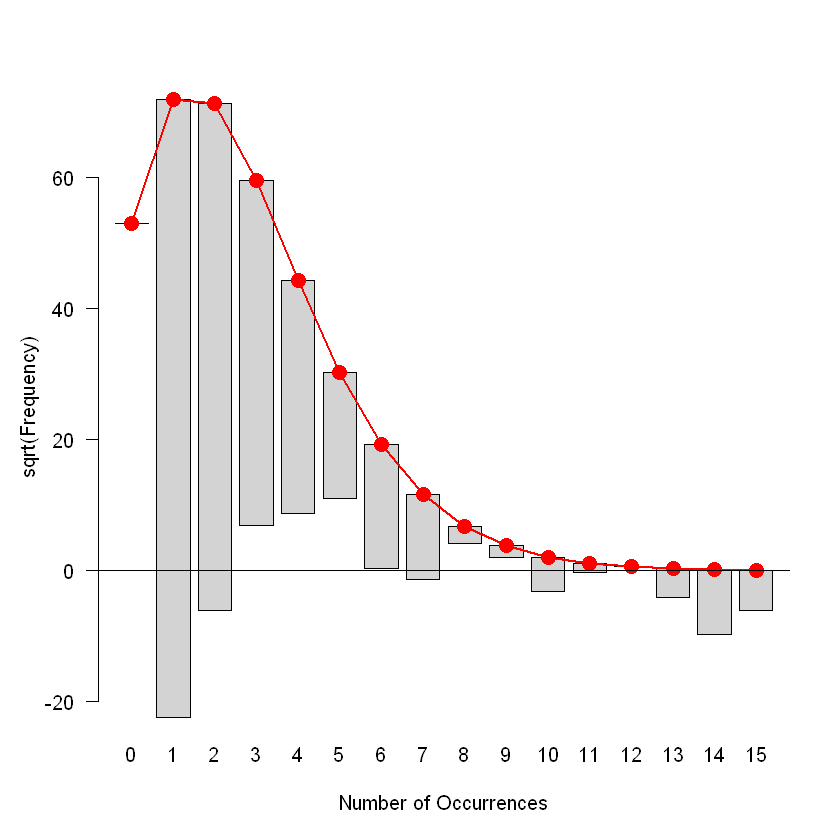

In [227]:
plot( gf_wAug )

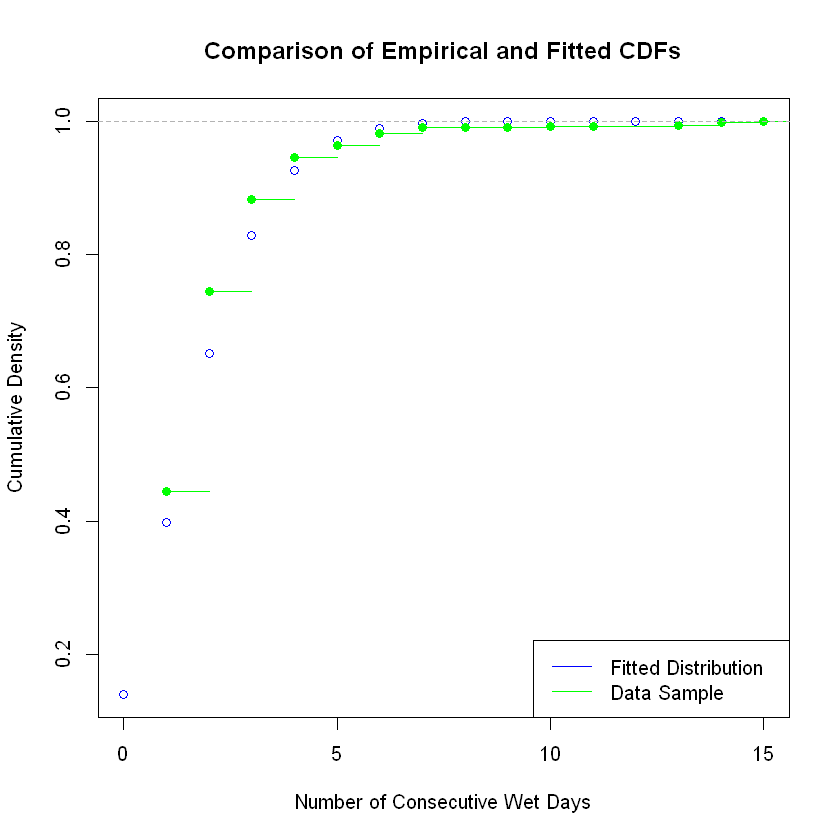

In [228]:
x <- seq(0,wAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wAug_mu, size=fdNB_wAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

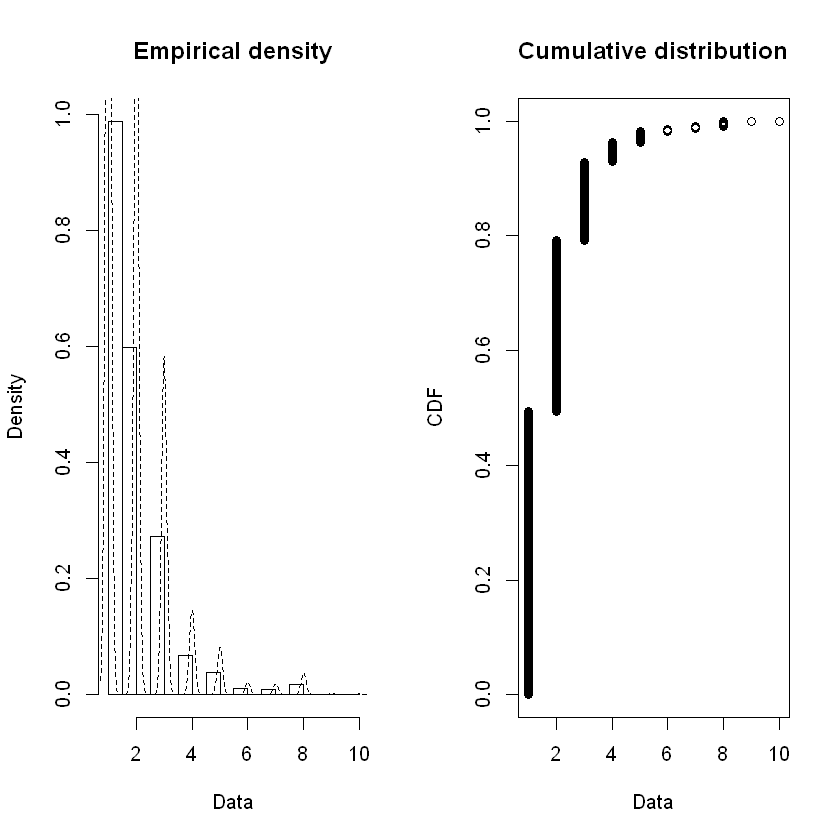

In [229]:
plotdist( wSep$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  10 
median:  2 
mean:  1.863289 
estimated sd:  1.202872 
estimated skewness:  2.297208 
estimated kurtosis:  10.4655 

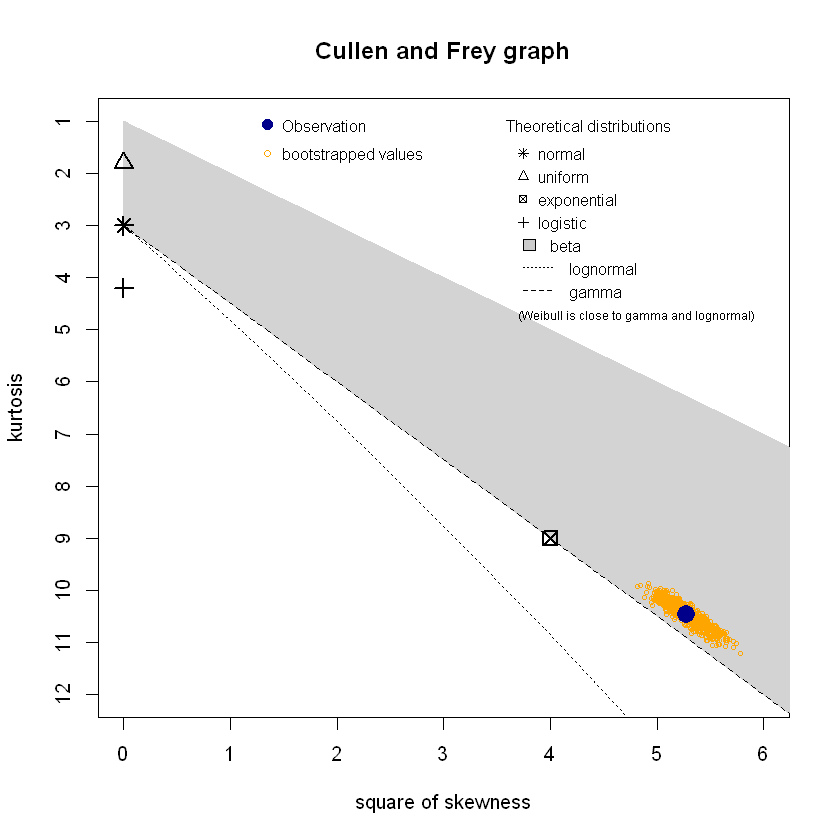

In [230]:
descdist( wSep$Wet_Count, boot=1000 )

In [231]:
fd_NB_wSep <- fitdist( wSep$Wet_Count, "nbinom" )
fd_GE_wSep <- fitdist( wSep$Wet_Count, "geom" )

In [232]:
fdNB_wSep_size <- fd_NB_wSep$estimate[["size"]]
fdNB_wSep_mu <- fd_NB_wSep$estimate[["mu"]]
cat("Sep size: ", fdNB_wSep_size, "\n", "Sep mu: ", fdNB_wSep_mu, "\n")

Sep size:  4317364 
 Sep mu:  1.863442 


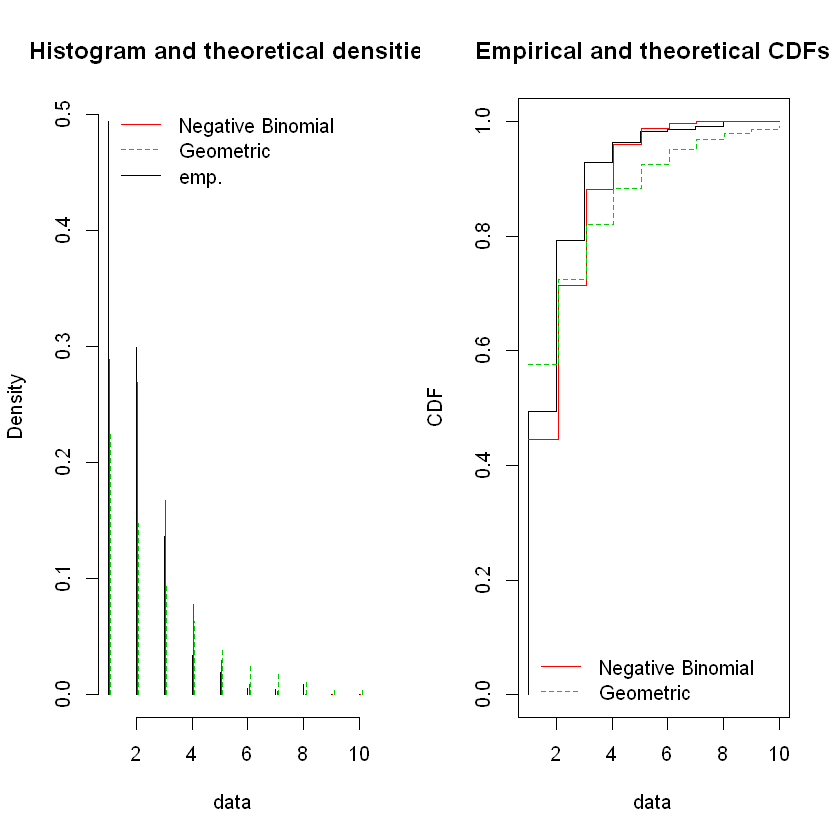

In [233]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wSep, fd_GE_wSep), legendtext=plot.legend )
cdfcomp( list(fd_NB_wSep, fd_GE_wSep), legendtext=plot.legend )

In [234]:
statRes <- gofstat( list(fd_NB_wSep, fd_GE_wSep), fitnames=c("Negative Binomial", "Geometric") )

In [235]:
print(statRes)

Chi-squared statistic:  1013.676 5246.999 
Degree of freedom of the Chi-squared distribution:  4 5 
Chi-squared p-value:  3.880052e-218 0 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1     10267            9231.503315     11980.7209
<= 2      6212            5597.389322      3073.4866
<= 3      2828            3476.802754      2000.0752
<= 4       697            1619.705120      1301.5514
<= 5       396             603.645468       846.9862
<= 8       365             249.008833      1143.2676
> 8         16               2.945187       434.9121

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          63210.03  76995.25
Bayesian Information Criterion          63225.92  77003.19


In [236]:
fdNB_wSep_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [237]:
fdNB_wSep_p = fdNB_wSep_size / (fdNB_wSep_size + fdNB_wSep_mu)
cat("prob: ", fdNB_wSep_p)

prob:  0.9999996

In [238]:
MonDistDF[9, ] <- list( 9, wSepMean, wSepBNr, fdNB_wSep_p, fdNB_wSep_mu, fdNB_wSep_size,
                        fdNB_wSep_pvalue )

In [239]:
gf_wSep <- goodfit( wSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wSep_size, prob=fdNB_wSep_p) )

In [240]:
summary( gf_wSep )

Warning message in summary.goodfit(gf_wSep):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson           9497.282 10        0
Likelihood Ratio 10607.580  9        0


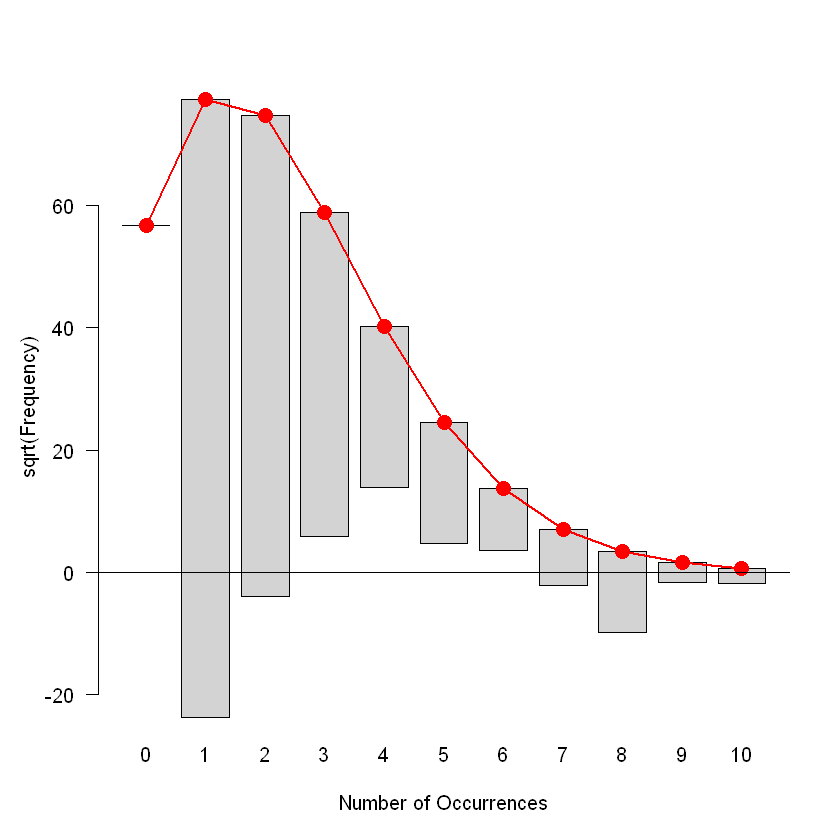

In [241]:
plot( gf_wSep )

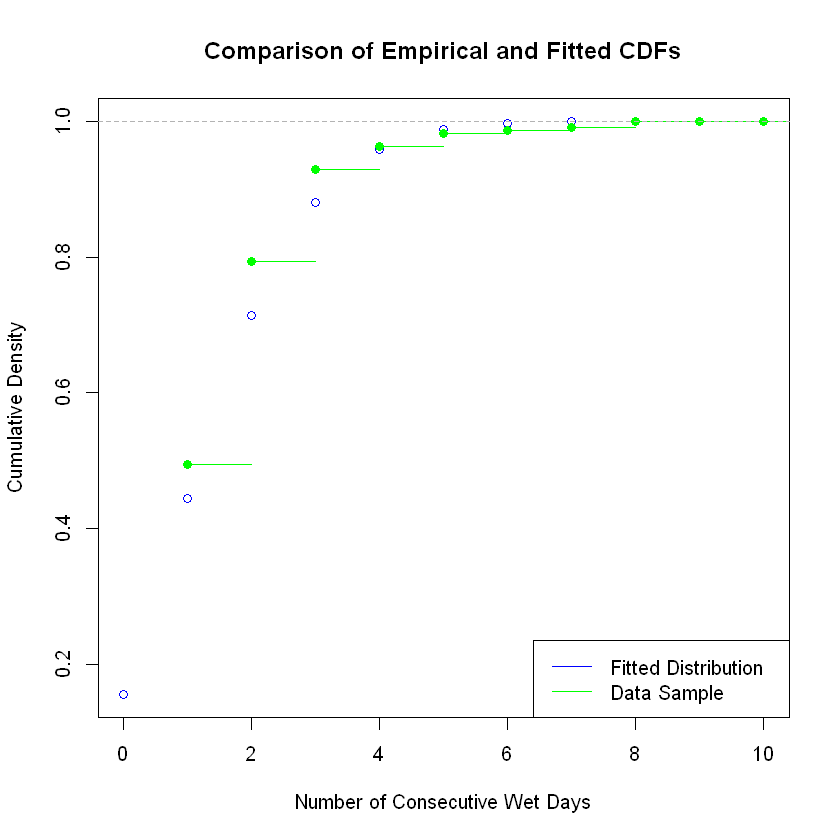

In [242]:
x <- seq(0,wSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wSep_mu, size=fdNB_wSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

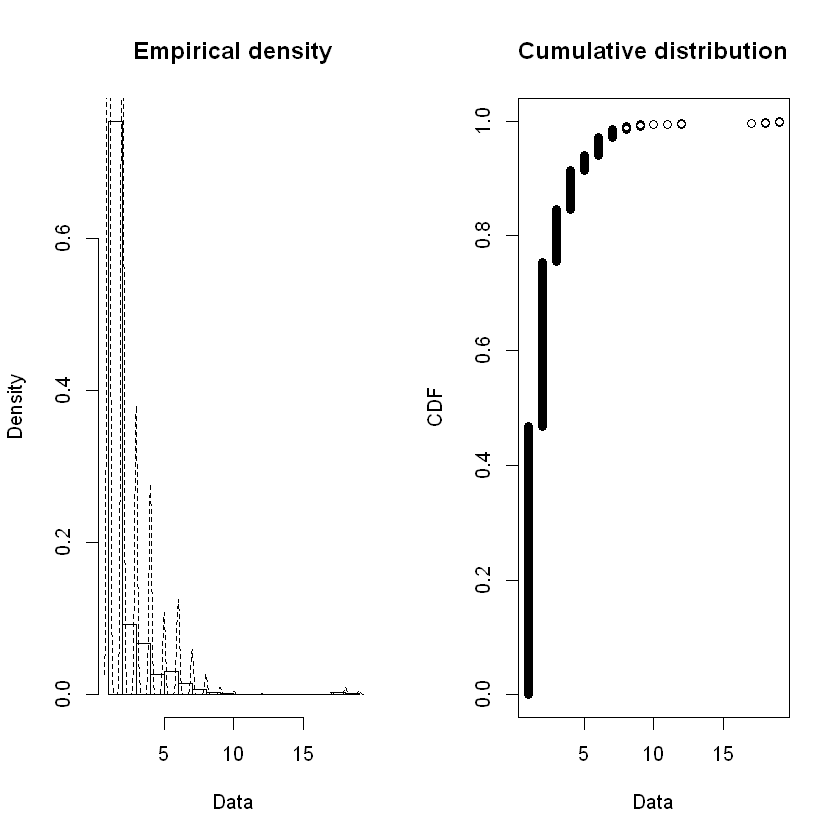

In [243]:
plotdist( wOct$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  19 
median:  2 
mean:  2.170252 
estimated sd:  1.865462 
estimated skewness:  3.776056 
estimated kurtosis:  26.94367 

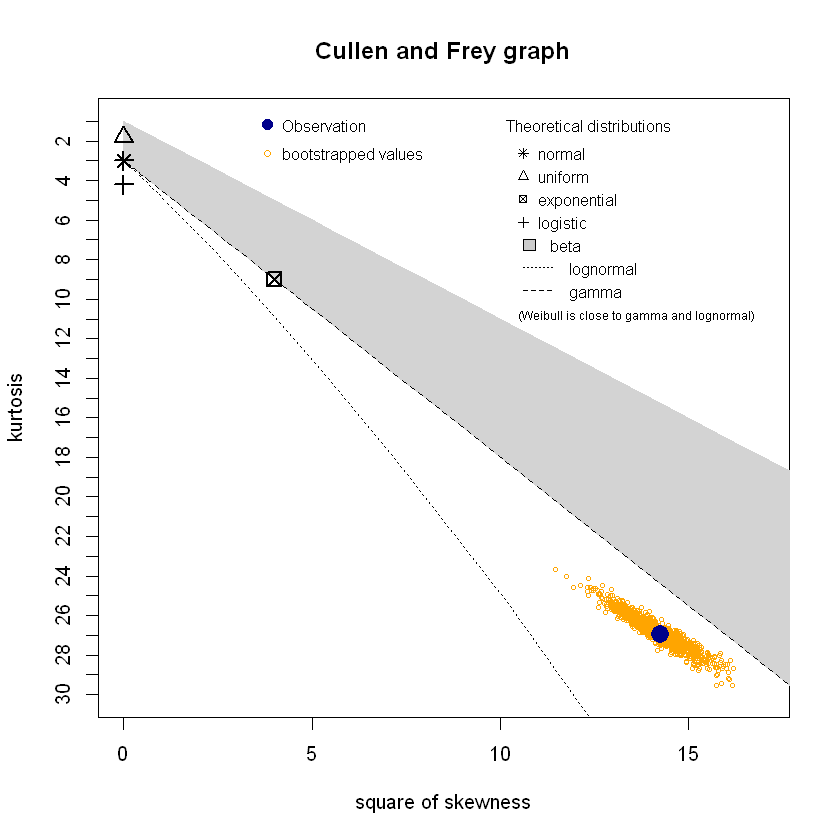

In [244]:
descdist( wOct$Wet_Count, boot=1000 )

In [245]:
fd_NB_wOct <- fitdist( wOct$Wet_Count, "nbinom" )
fd_GE_wOct <- fitdist( wOct$Wet_Count, "geom" )

In [246]:
fdNB_wOct_size <- fd_NB_wOct$estimate[["size"]]
fdNB_wOct_mu <- fd_NB_wOct$estimate[["mu"]]
cat("Oct size: ", fdNB_wOct_size, "\n", "Oct mu: ", fdNB_wOct_mu, "\n")

Oct size:  7.896168 
 Oct mu:  2.170282 


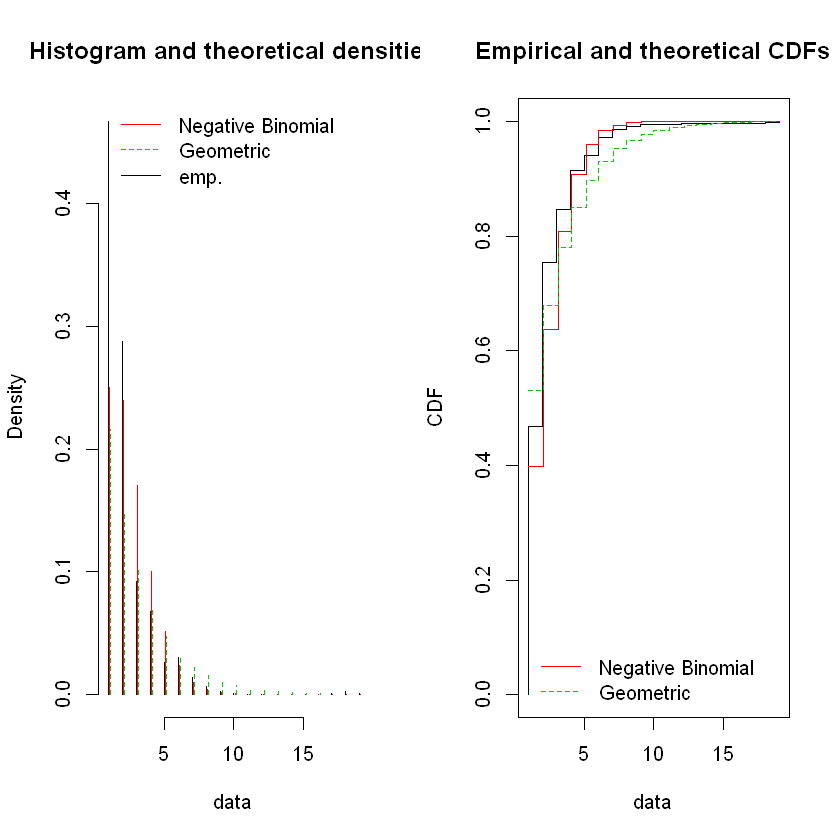

In [247]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wOct, fd_GE_wOct), legendtext=plot.legend )
cdfcomp( list(fd_NB_wOct, fd_GE_wOct), legendtext=plot.legend )

In [248]:
statRes <- gofstat( list(fd_NB_wOct, fd_GE_wOct), fitnames=c("Negative Binomial", "Geometric") )

In [249]:
print(statRes)

Chi-squared statistic:  1835.649 3443.23 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      9097              7736.3972     10349.4371
<= 2      5601              4673.7073      2879.1284
<= 3      1795              3323.8937      1970.9582
<= 4      1322              1952.0940      1349.2543
<= 5       508              1001.3309       923.6559
<= 6       593               464.0095       632.3049
<= 7       276               198.5929       432.8555
> 7        285               126.9745       939.4056

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          68905.13  76985.49
Bayesian Information Criterion          68920.88  76993.37


In [250]:
fdNB_wOct_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [251]:
fdNB_wOct_p = fdNB_wOct_size / (fdNB_wOct_size + fdNB_wOct_mu)
cat("prob: ", fdNB_wOct_p)

prob:  0.7844044

In [252]:
MonDistDF[10, ] <- list( 10, wOctMean, wOctBNr, fdNB_wOct_p, fdNB_wOct_mu, fdNB_wOct_size,
                        fdNB_wOct_pvalue )

In [253]:
gf_wOct <- goodfit( wOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wOct_size, prob=fdNB_wOct_p) )

In [254]:
summary( gf_wOct )

Warning message in summary.goodfit(gf_wOct):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          3020535.2 19        0
Likelihood Ratio   11885.9 14        0


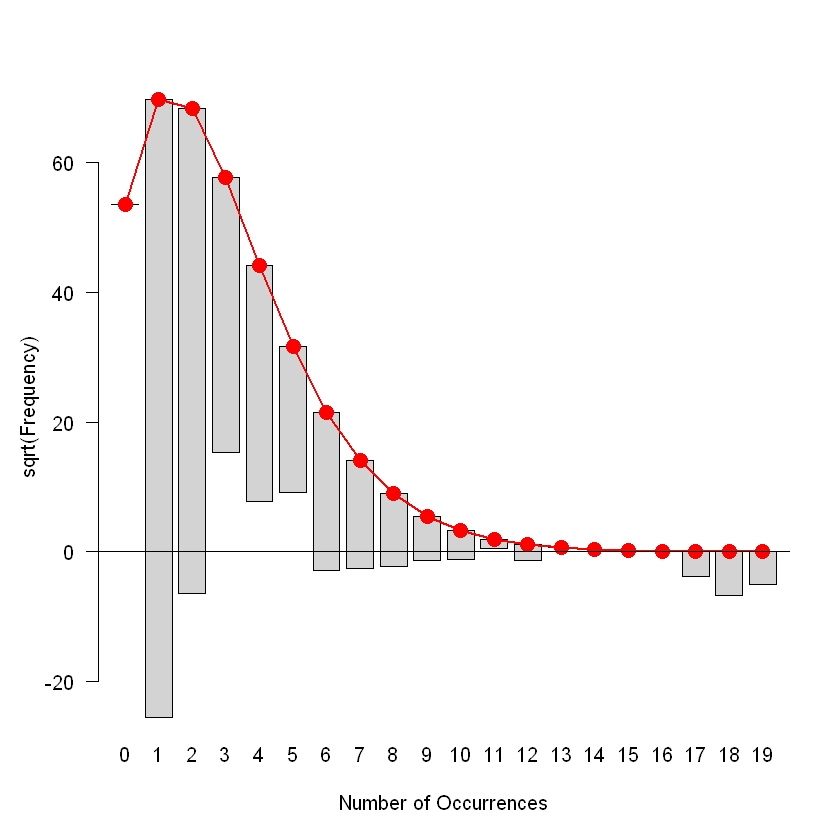

In [255]:
plot( gf_wOct )

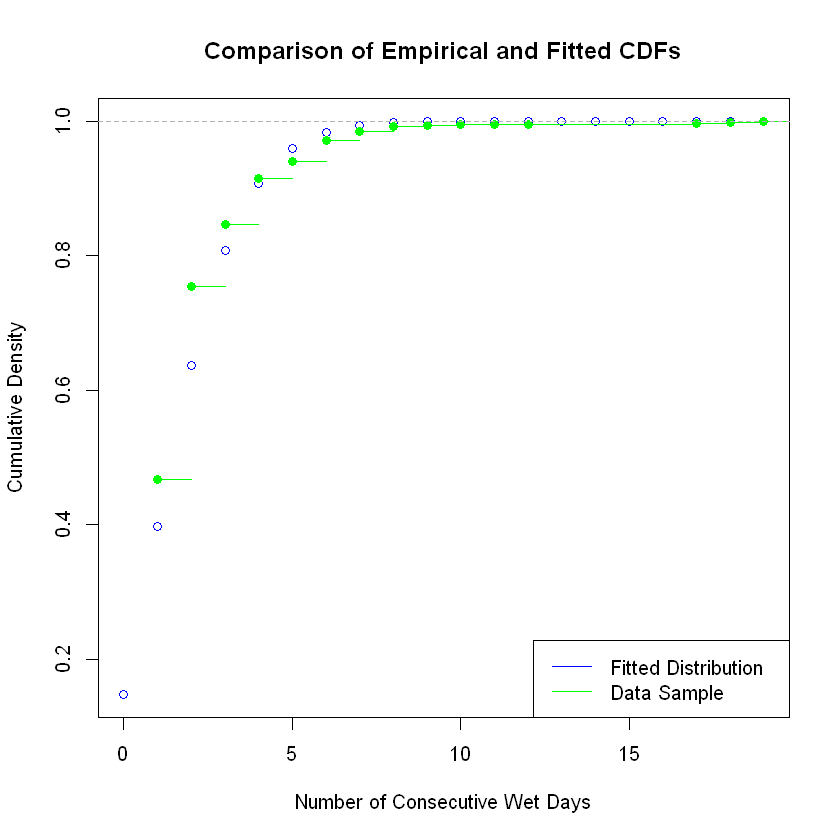

In [256]:
x <- seq(0,wOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wOct_mu, size=fdNB_wOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

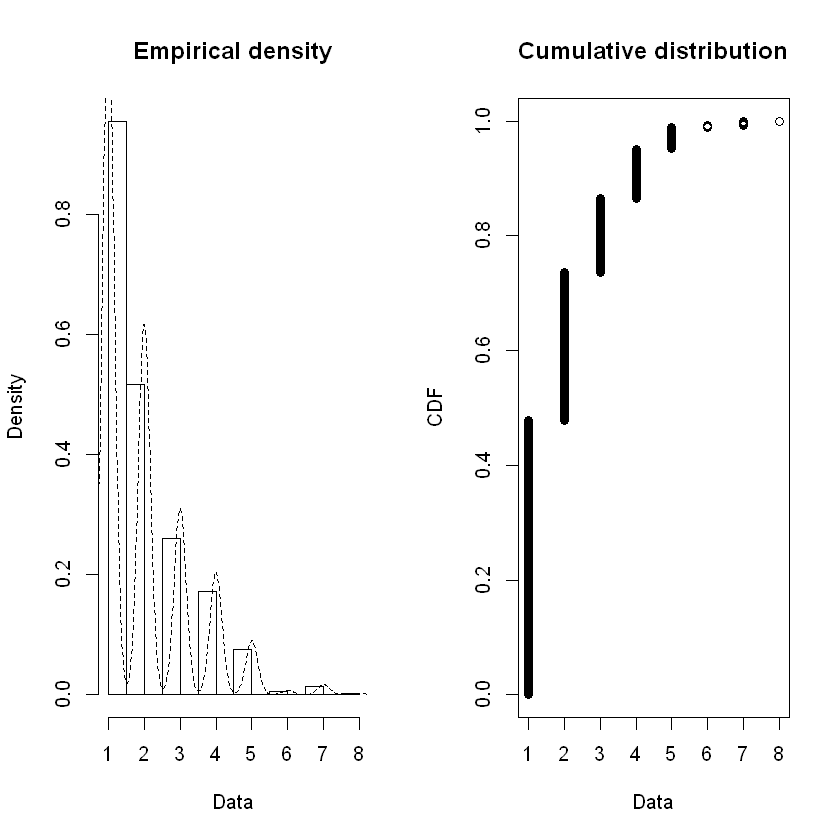

In [257]:
plotdist( wNov$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  8 
median:  2 
mean:  1.987832 
estimated sd:  1.240532 
estimated skewness:  1.386565 
estimated kurtosis:  4.788217 

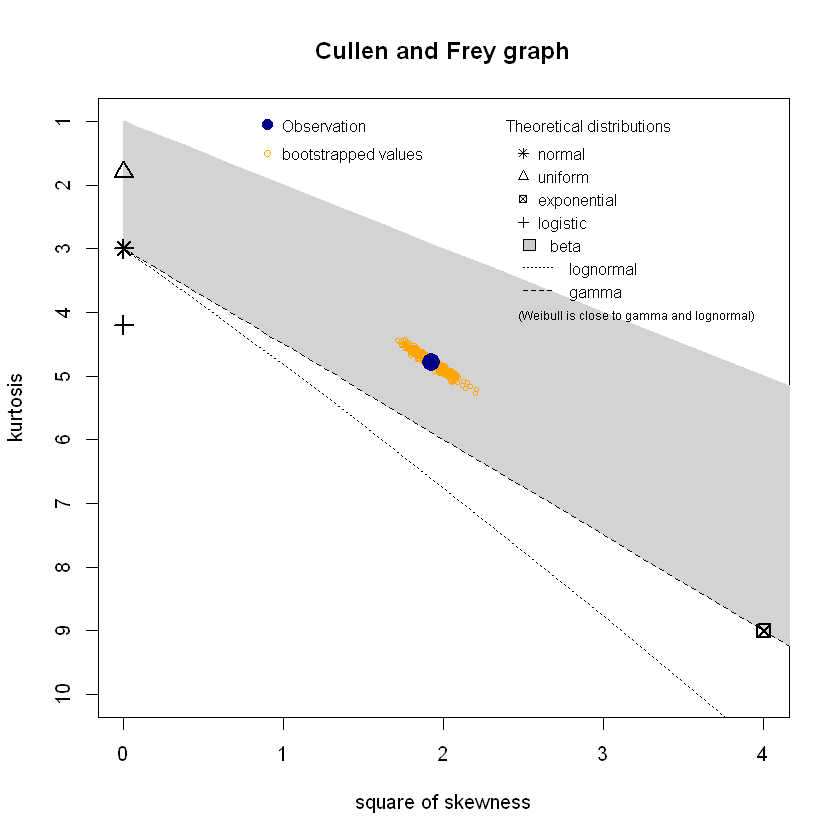

In [258]:
descdist( wNov$Wet_Count, boot=1000 )

In [259]:
fd_NB_wNov <- fitdist( wNov$Wet_Count, "nbinom" )
fd_GE_wNov <- fitdist( wNov$Wet_Count, "geom" )

Warning message in sqrt(diag(varcovar)):
"NaNs produced"Warning message in sqrt(1/diag(V)):
"NaNs produced"Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"

In [260]:
fdNB_wNov_size <- fd_NB_wNov$estimate[["size"]]
fdNB_wNov_mu <- fd_NB_wNov$estimate[["mu"]]
cat("Nov size: ", fdNB_wNov_size, "\n", "Nov mu: ", fdNB_wNov_mu, "\n")

Nov size:  253529.9 
 Nov mu:  1.988015 


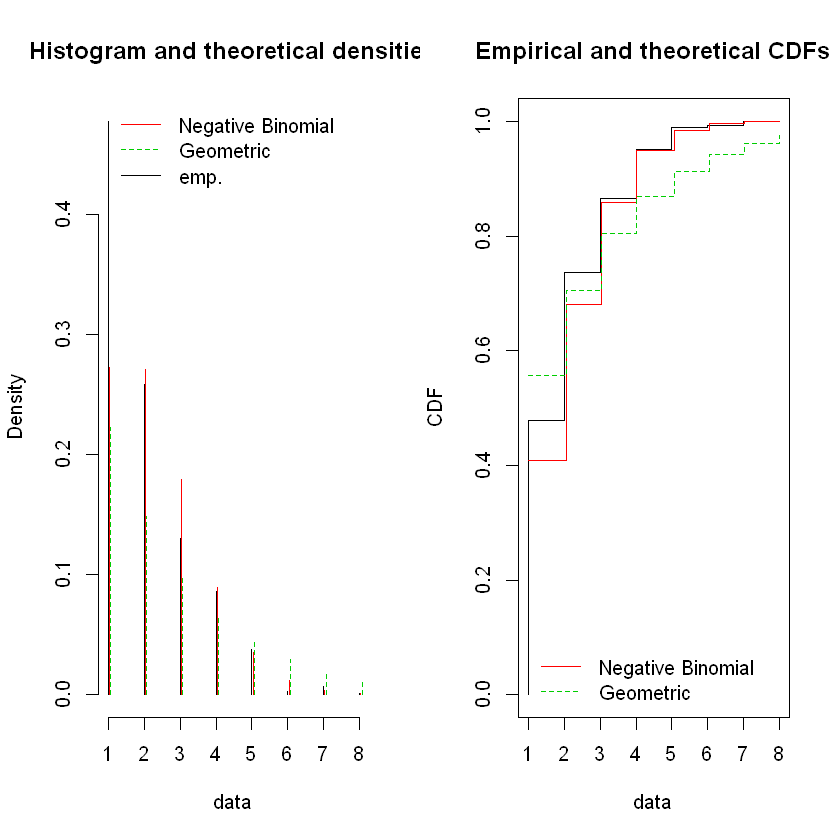

In [261]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wNov, fd_GE_wNov), legendtext=plot.legend )
cdfcomp( list(fd_NB_wNov, fd_GE_wNov), legendtext=plot.legend )

In [262]:
statRes <- gofstat( list(fd_NB_wNov, fd_GE_wNov), fitnames=c("Negative Binomial", "Geometric") )

In [263]:
print(statRes)

Chi-squared statistic:  372.3548 2391.779 
Degree of freedom of the Chi-squared distribution:  3 4 
Chi-squared p-value:  2.151597e-80 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      6436              5516.0133      7512.1482
<= 2      3486              3647.9520      1996.7159
<= 3      1752              2417.3949      1328.4334
<= 4      1153              1201.4593       883.8189
<= 5       507               477.7077       588.0128
> 5        144               217.4727      1168.8707

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          42420.59  51342.30
Bayesian Information Criterion          42435.60  51349.81


In [264]:
fdNB_wNov_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [265]:
fdNB_wNov_p = fdNB_wNov_size / (fdNB_wNov_size + fdNB_wNov_mu)
cat("prob: ", fdNB_wNov_p)

prob:  0.9999922

In [266]:
MonDistDF[11, ] <- list( 11, wNovMean, wNovBNr, fdNB_wNov_p, fdNB_wNov_mu, fdNB_wNov_size,
                        fdNB_wNov_pvalue )

In [267]:
gf_wNov <- goodfit( wNov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wNov_size, prob=fdNB_wNov_p) )

In [268]:
summary( gf_wNov )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          4272.768  8        0
Likelihood Ratio 5784.692  7        0


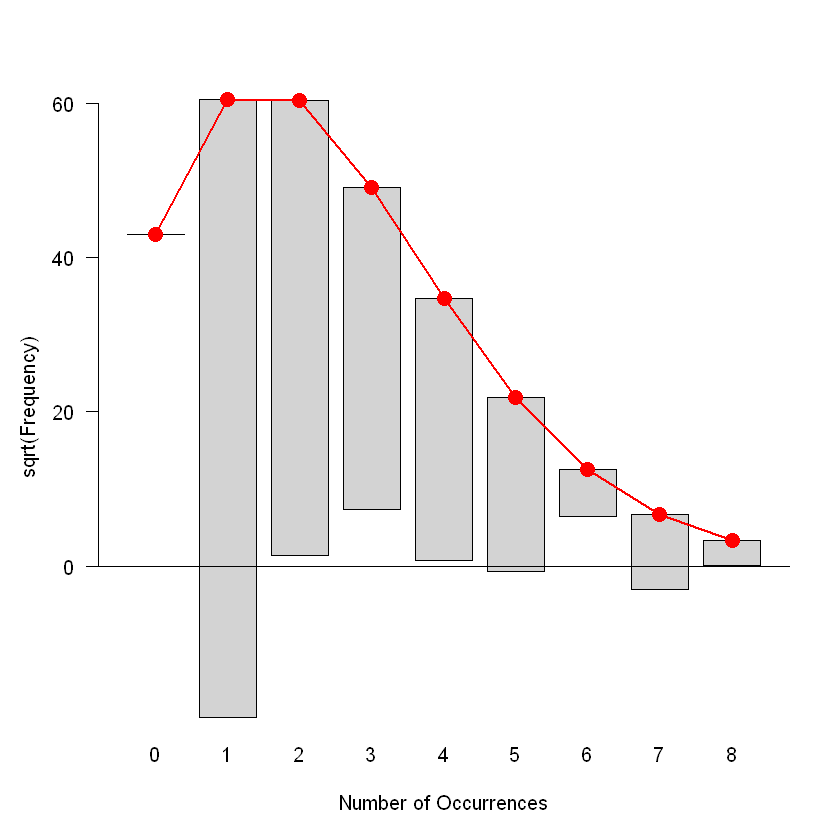

In [269]:
plot( gf_wNov )

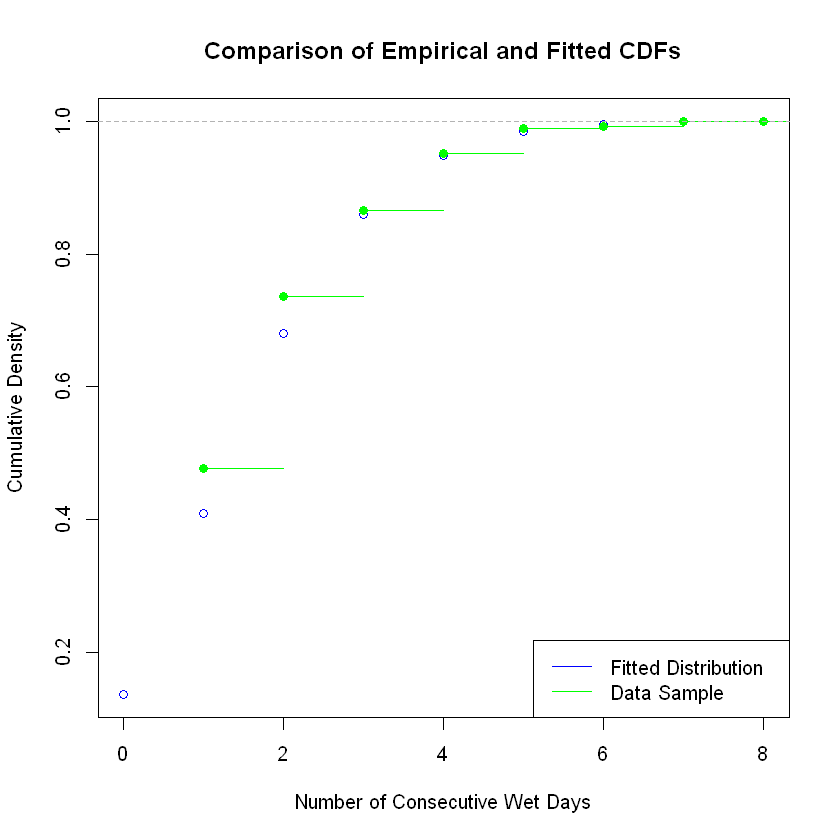

In [270]:
x <- seq(0,wNovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wNov_mu, size=fdNB_wNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wNov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

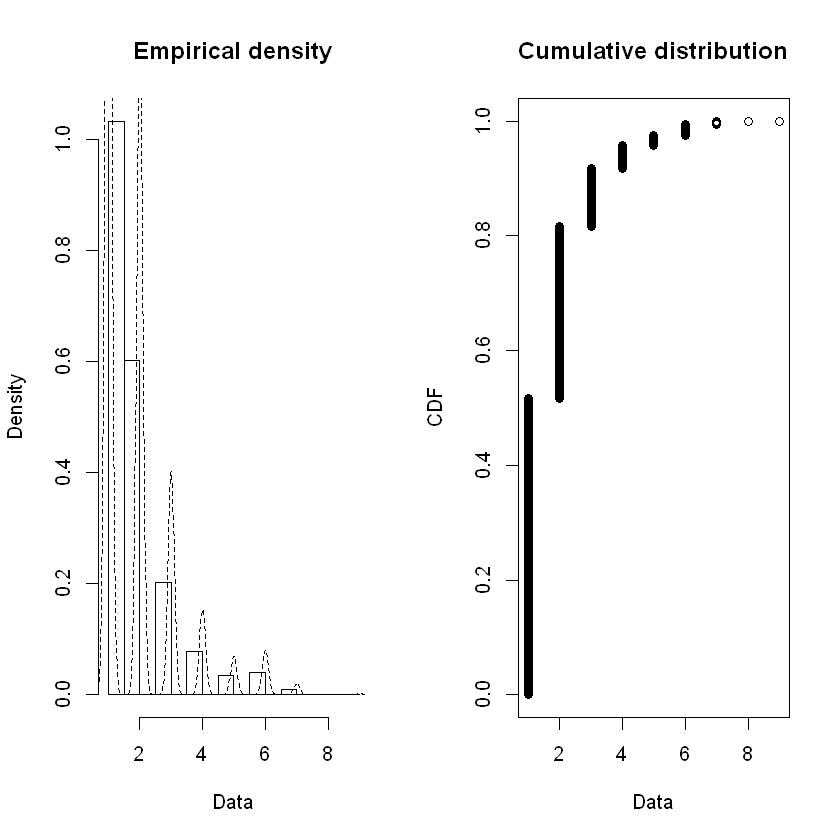

In [271]:
plotdist( wDec$Wet_Count, histo=TRUE, demp=TRUE )

summary statistics
------
min:  1   max:  9 
median:  1 
mean:  1.823286 
estimated sd:  1.170106 
estimated skewness:  1.990173 
estimated kurtosis:  7.572806 

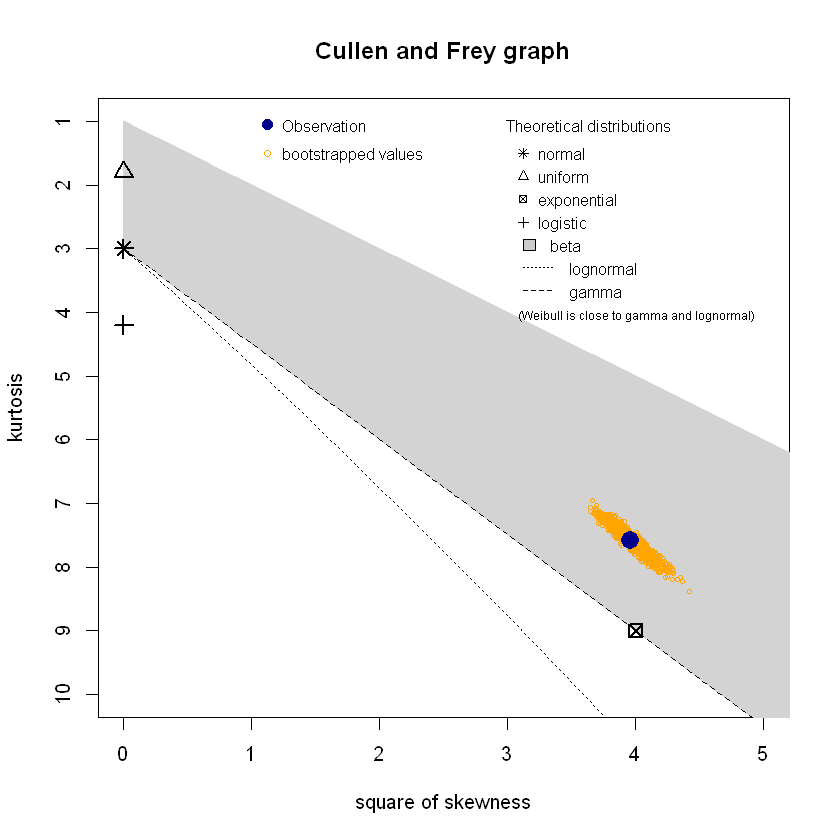

In [272]:
descdist( wDec$Wet_Count, boot=1000 )

In [273]:
fd_NB_wDec <- fitdist( wDec$Wet_Count, "nbinom" )
fd_GE_wDec <- fitdist( wDec$Wet_Count, "geom" )

Warning message in sqrt(diag(varcovar)):
"NaNs produced"Warning message in sqrt(1/diag(V)):
"NaNs produced"Warning message in cov2cor(varcovar):
"diag(.) had 0 or NA entries; non-finite result is doubtful"

In [274]:
fdNB_wDec_size <- fd_NB_wDec$estimate[["size"]]
fdNB_wDec_mu <- fd_NB_wDec$estimate[["mu"]]
cat("Dec size: ", fdNB_wDec_size, "\n", "Dec mu: ", fdNB_wDec_mu, "\n")

Dec size:  831426 
 Dec mu:  1.82316 


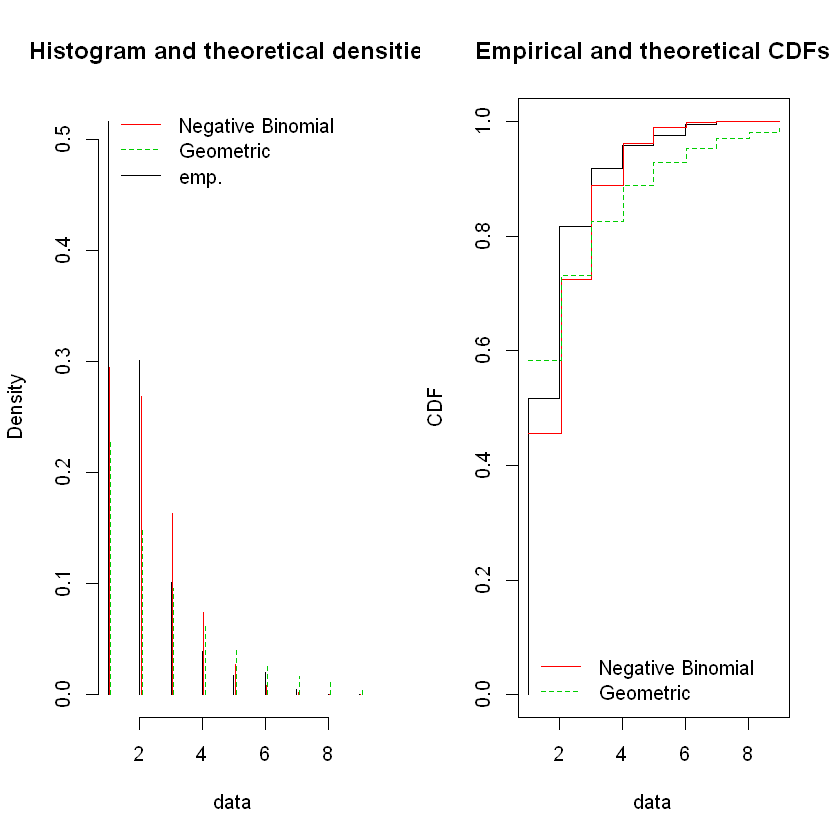

In [275]:
par(mfrow=c(1,2))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(fd_NB_wDec, fd_GE_wDec), legendtext=plot.legend )
cdfcomp( list(fd_NB_wDec, fd_GE_wDec), legendtext=plot.legend )

In [276]:
statRes <- gofstat( list(fd_NB_wDec, fd_GE_wDec), fitnames=c("Negative Binomial", "Geometric") )

In [277]:
print(statRes)

Chi-squared statistic:  1034.815 3107.866 
Degree of freedom of the Chi-squared distribution:  4 5 
Chi-squared p-value:  1.017485e-222 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1      7107             6277.95771      8025.9010
<= 2      4144             3695.74137      2033.8355
<= 3      1394             2245.97593      1313.4566
<= 4       532             1023.69460       848.2339
<= 5       241              373.27271       547.7918
<= 6       273              113.42305       353.7655
> 6         77               37.93464       645.0156

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion          41456.61  50534.78
Bayesian Information Criterion          41471.67  50542.31


In [278]:
fdNB_wDec_pvalue <- statRes$chisqpvalue[["Negative Binomial"]]

In [279]:
fdNB_wDec_p = fdNB_wDec_size / (fdNB_wDec_size + fdNB_wDec_mu)
cat("prob: ", fdNB_wDec_p)

prob:  0.9999978

In [280]:
MonDistDF[12, ] <- list( 12, wDecMean, wDecBNr, fdNB_wDec_p, fdNB_wDec_mu, fdNB_wDec_size,
                        fdNB_wDec_pvalue )

In [281]:
gf_wDec <- goodfit( wDec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=fdNB_wDec_size, prob=fdNB_wDec_p) )

In [282]:
summary( gf_wDec )

Warning message in summary.goodfit(gf_wDec):
"Chi-squared approximation may be incorrect"


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          5467.492  9        0
Likelihood Ratio 7293.292  8        0


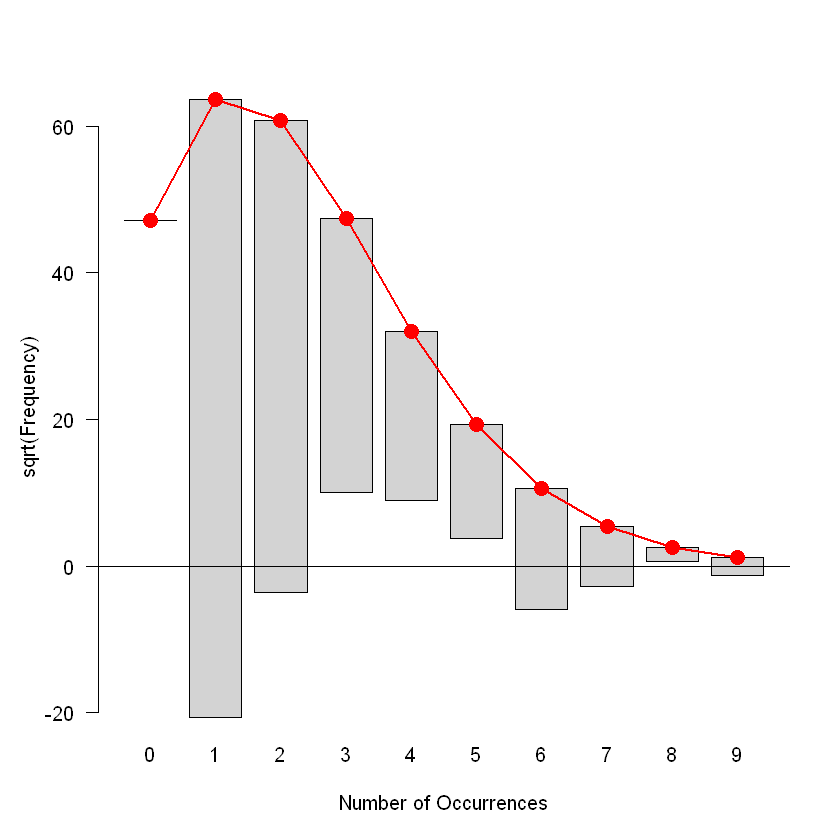

In [283]:
plot( gf_wDec )

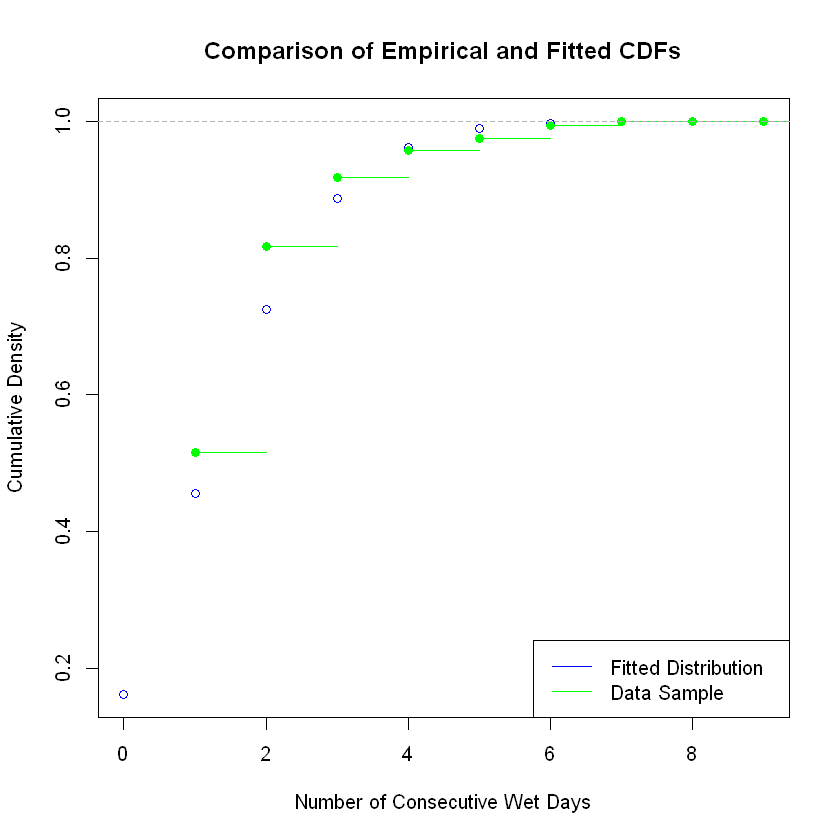

In [284]:
x <- seq(0,wDecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=fdNB_wDec_mu, size=fdNB_wDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="Comparison of Empirical and Fitted CDFs" )
plot(ecdf(wDec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Look at our summary DataFrame

In [285]:
print( MonDistDF, quote=FALSE, row.names=FALSE )

 month      smu    ssize     sprob      tmu        tsize        pvalue
     1 1.866392 3.483419 0.9999997 1.866322 6.860232e+06  0.000000e+00
     2 1.815739 3.296908 0.9999991 1.815874 1.958205e+06 7.098435e-144
     3 1.761789 3.103899 0.9999998 1.761965 8.392017e+06 6.405878e-315
     4 1.768595 3.127928 0.9999991 1.768731 1.958205e+06 1.187500e-145
     5 1.862177 3.467703 0.9999934 1.862747 2.810599e+05  0.000000e+00
     6 2.071890 4.292729 0.8818581 2.071984 1.546611e+01  0.000000e+00
     7 2.056709 4.230053 0.9523323 2.056711 4.109010e+01 6.853384e-315
     8 2.098422 4.403374 0.8795966 2.098580 1.533100e+01  0.000000e+00
     9 1.863289 3.471844 0.9999996 1.863442 4.317364e+06 3.880052e-218
    10 2.170252 3.596253 0.7844044 2.170282 7.896168e+00  0.000000e+00
    11 1.987832 3.951476 0.9999922 1.988015 2.535299e+05  2.151597e-80
    12 1.823286 3.324371 0.9999978 1.823160 8.314260e+05 1.017485e-222


## Check that No Grid Cell Outliers

Check that there are not any grid cell outliers

In [286]:
OurGridIDs <- unique( dfWet$Grid_Id )
NumIDs = length(OurGridIDs)
cat("Number of GridIDS: ", NumIDs)

Number of GridIDS:  210

In [287]:
TotNRows <- nrow( dfWet )
cat("Total Rows in DF: ", TotNRows)

Total Rows in DF:  226190

Create a DataFrame to store all of our p-values by Grid_ID and Month

In [288]:
MonPVDF <- data.frame( gridid=rep(NA,NumIDs), jan=rep(NA,NumIDs), feb=rep(NA,NumIDs), 
                       mar=rep(NA,NumIDs), apr=rep(NA,NumIDs), may=rep(NA,NumIDs),
                       jun=rep(NA,NumIDs), jul=rep(NA,NumIDs), aug=rep(NA,NumIDs),
                       sep=rep(NA,NumIDs), oct=rep(NA,NumIDs), nov=rep(NA,NumIDs),
                       dec=rep(NA,NumIDs), stringsAsFactors=FALSE )

Change the working directory to a subdirectory for output

In [289]:
setwd("PRISM_WetDays")

In [290]:
capO <- file( "Grid_Month_Check.txt", "w" )
cat("Determine if each grid, monthly values are from same distribution\n\n", file=capO )
for(iI in 1:NumIDs) {
    # get the grid ID
    tID <- OurGridIDs[iI]
    cat("Grid Node: ", tID, " \n", file=capO, append=TRUE )
    # january
    cJanPick <- wJan %>% filter( Grid_Id == tID )
    cJanOther <- wJan %>% filter( Grid_Id != tID )
    cJanRes <- ks.test( cJanPick$Wet_Count, cJanOther$Wet_Count )
    cat("    January --- \n", file=capO, append=TRUE )
    cat("          ", cJanRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cJanRes$statistic, ", ", cJanRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    # set our color
    if (cJanRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Jan.png")
    titleStr <- paste("Grid ID ", tID, " January Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cJanPick$Wet_Count, cJanOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wJanMax), ylim=c(0,wJanMax) )
    abline( 0, 1)
    dev.off()
    # february
    cFebPick <- wFeb %>% filter( Grid_Id == tID )
    cFebOther <- wFeb %>% filter( Grid_Id != tID )
    cFebRes <- ks.test( cFebPick$Wet_Count, cFebOther$Wet_Count )
    cat("    February --- \n", file=capO, append=TRUE )
    cat("          ", cFebRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cFebRes$statistic, ", ", cFebRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cFebRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Feb.png")
    titleStr <- paste("Grid ID ", tID, " February Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cFebPick$Wet_Count, cFebOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wFebMax), ylim=c(0,wFebMax) )
    abline( 0, 1)
    dev.off()
    # march
    cMarPick <- wMar %>% filter( Grid_Id == tID )
    cMarOther <- wMar %>% filter( Grid_Id != tID )
    cMarRes <- ks.test( cMarPick$Wet_Count, cMarOther$Wet_Count )
    cat("    March --- \n", file=capO, append=TRUE )
    cat("          ", cMarRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cMarRes$statistic, ", ", cMarRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cMarRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Mar.png")
    titleStr <- paste("Grid ID ", tID, " March Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cMarPick$Wet_Count, cMarOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wMarMax), ylim=c(0,wMarMax) )
    abline( 0, 1)
    dev.off()
    # april
    cAprPick <- wApr %>% filter( Grid_Id == tID )
    cAprOther <- wApr %>% filter( Grid_Id != tID )
    cAprRes <- ks.test( cAprPick$Wet_Count, cAprOther$Wet_Count )
    cat("    April --- \n", file=capO, append=TRUE )
    cat("          ", cAprRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cAprRes$statistic, ", ", cAprRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cAprRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Apr.png")
    titleStr <- paste("Grid ID ", tID, " April Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cAprPick$Wet_Count, cAprOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wAprMax), ylim=c(0,wAprMax) )
    abline( 0, 1)
    dev.off()
    # may
    cMayPick <- wMay %>% filter( Grid_Id == tID )
    cMayOther <- wMay %>% filter( Grid_Id != tID )
    cMayRes <- ks.test( cMayPick$Wet_Count, cMayOther$Wet_Count )
    cat("    May --- \n", file=capO, append=TRUE )
    cat("          ", cMayRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cMayRes$statistic, ", ", cMayRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cMayRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_May.png")
    titleStr <- paste("Grid ID ", tID, " May Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cMayPick$Wet_Count, cMayOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wMayMax), ylim=c(0,wMayMax) )
    abline( 0, 1)
    dev.off()
    # june
    cJunPick <- wJun %>% filter( Grid_Id == tID )
    cJunOther <- wJun %>% filter( Grid_Id != tID )
    cJunRes <- ks.test( cJunPick$Wet_Count, cJunOther$Wet_Count )
    cat("    June --- \n", file=capO, append=TRUE )
    cat("          ", cJunRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cJunRes$statistic, ", ", cJunRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cJunRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Jun.png")
    titleStr <- paste("Grid ID ", tID, " June Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cJunPick$Wet_Count, cJunOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wJunMax), ylim=c(0,wJunMax) )
    abline( 0, 1)
    dev.off()
    # july
    cJulPick <- wJul %>% filter( Grid_Id == tID )
    cJulOther <- wJul %>% filter( Grid_Id != tID )
    cJulRes <- ks.test( cJulPick$Wet_Count, cJulOther$Wet_Count )
    cat("    July --- \n", file=capO, append=TRUE )
    cat("          ", cJulRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cJulRes$statistic, ", ", cJulRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cJulRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Jul.png")
    titleStr <- paste("Grid ID ", tID, " July Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cJulPick$Wet_Count, cJulOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wJulMax), ylim=c(0,wJulMax) )
    abline( 0, 1)
    dev.off()
    # august
    cAugPick <- wAug %>% filter( Grid_Id == tID )
    cAugOther <- wAug %>% filter( Grid_Id != tID )
    cAugRes <- ks.test( cAugPick$Wet_Count, cAugOther$Wet_Count )
    cat("    August --- \n", file=capO, append=TRUE )
    cat("          ", cAugRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cAugRes$statistic, ", ", cAugRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cAugRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Aug.png")
    titleStr <- paste("Grid ID ", tID, " August Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cAugPick$Wet_Count, cAugOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wAugMax), ylim=c(0,wAugMax) )
    abline( 0, 1)
    dev.off()
    # september
    cSepPick <- wSep %>% filter( Grid_Id == tID )
    cSepOther <- wSep %>% filter( Grid_Id != tID )
    cSepRes <- ks.test( cSepPick$Wet_Count, cSepOther$Wet_Count )
    cat("    September --- \n", file=capO, append=TRUE )
    cat("          ", cSepRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cSepRes$statistic, ", ", cSepRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cSepRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Sep.png")
    titleStr <- paste("Grid ID ", tID, " September Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cSepPick$Wet_Count, cSepOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wSepMax), ylim=c(0,wSepMax) )
    abline( 0, 1)
    dev.off()
    # october
    cOctPick <- wOct %>% filter( Grid_Id == tID )
    cOctOther <- wOct %>% filter( Grid_Id != tID )
    cOctRes <- ks.test( cOctPick$Wet_Count, cOctOther$Wet_Count )
    cat("    October --- \n", file=capO, append=TRUE )
    cat("          ", cOctRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cOctRes$statistic, ", ", cOctRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cOctRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Oct.png")
    titleStr <- paste("Grid ID ", tID, " October Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cOctPick$Wet_Count, cOctOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wOctMax), ylim=c(0,wOctMax) )
    abline( 0, 1)
    dev.off()
    # november
    cNovPick <- wNov %>% filter( Grid_Id == tID )
    cNovOther <- wNov %>% filter( Grid_Id != tID )
    cNovRes <- ks.test( cNovPick$Wet_Count, cNovOther$Wet_Count )
    cat("    November --- \n", file=capO, append=TRUE )
    cat("          ", cNovRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cNovRes$statistic, ", ", cNovRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", file=capO, append=TRUE)
    if (cNovRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Nov.png")
    titleStr <- paste("Grid ID ", tID, " November Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cNovPick$Wet_Count, cNovOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wNovMax), ylim=c(0,wNovMax) )
    abline( 0, 1)
    dev.off()
    # December
    cDecPick <- wDec %>% filter( Grid_Id == tID )
    cDecOther <- wDec %>% filter( Grid_Id != tID )
    cDecRes <- ks.test( cDecPick$Wet_Count, cDecOther$Wet_Count )
    cat("    December --- \n", file=capO, append=TRUE )
    cat("          ", cDecRes$method, "\n", file=capO, append=TRUE)
    cat("          ", cDecRes$statistic, ", ", cDecRes$p.value, "\n", file=capO, 
        append=TRUE)
    cat("\n", "\n", file=capO, append=TRUE)
    if (cDecRes$p.value < 0.10) {
        fPartr <- "Check_"
        psColr <- "red"
    } else {
        fPartr <- ""
        psColr <- "blue"
    }
    OutFName <- paste(fPartr, "GI_", tID, "_Dec.png")
    titleStr <- paste("Grid ID ", tID, " December Compare" )
    png( OutFName, width=640, height=480 )
    qqplot( cDecPick$Wet_Count, cDecOther$Wet_Count, col=psColr, 
            xlab=paste("Grid ID: ", tID), ylab="All Others", main=titleStr,
            xlim=c(0,wDecMax), ylim=c(0,wDecMax) )
    abline( 0, 1)
    dev.off()
    # add to our dataframe
    MonPVDF[iI, ] <-list( tID, cJanRes$p.value, cFebRes$p.value, cMarRes$p.value,
                          cAprRes$p.value, cMayRes$p.value, cJunRes$p.value,
                          cJulRes$p.value, cAugRes$p.value, cSepRes$p.value,
                          cOctRes$p.value, cNovRes$p.value, cDecRes$p.value )
}

Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values wi

"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAugPick$Wet_Count, cAugOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cSepPick$Wet_Count, cSepOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cOctPick$Wet_Count, cOctOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_

"cannot compute correct p-values with ties"Warning message in ks.test(cNovPick$Wet_Count, cNovOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cDecPick$Wet_Count, cDecOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJanPick$Wet_Count, cJanOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cFebPick$Wet_Count, cFebOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMarPick$Wet_Count, cMarOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cAprPick$Wet_Count, cAprOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cMayPick$Wet_Count, cMayOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJunPick$Wet_Count, cJunOther$Wet_Count):
"cannot compute correct p-values with ties"Warning message in ks.test(cJulPick$Wet_Count, cJulOther$Wet_

In [291]:
summary( MonPVDF )

     gridid            jan               feb               mar        
 Min.   :662328   Min.   :0.07228   Min.   :0.06879   Min.   :0.2048  
 1st Qu.:666550   1st Qu.:0.98340   1st Qu.:0.93891   1st Qu.:0.8909  
 Median :671468   Median :0.99997   Median :0.99959   Median :0.9990  
 Mean   :671468   Mean   :0.94172   Mean   :0.93261   Mean   :0.8932  
 3rd Qu.:676385   3rd Qu.:1.00000   3rd Qu.:1.00000   3rd Qu.:1.0000  
 Max.   :680607   Max.   :1.00000   Max.   :1.00000   Max.   :1.0000  
      apr               may              jun               jul          
 Min.   :0.06958   Min.   :0.0312   Min.   :0.04046   Min.   :0.006928  
 1st Qu.:0.92450   1st Qu.:0.6980   1st Qu.:0.67921   1st Qu.:0.886634  
 Median :0.99967   Median :0.9930   Median :0.96550   Median :0.997294  
 Mean   :0.91788   Mean   :0.8075   Mean   :0.80564   Mean   :0.863566  
 3rd Qu.:1.00000   3rd Qu.:1.0000   3rd Qu.:0.99999   3rd Qu.:1.000000  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.00000   Max.   :1.0

Now filter for the p-values that are lower than 0.1 and look at these in terms of total number an Q-Q fit. Need to do these by month and then concatentate

In [292]:
pGJan <- MonPVDF %>% filter( jan < 0.1 )
pGFeb <- MonPVDF %>% filter( feb < 0.1 )
pGMar <- MonPVDF %>% filter( mar < 0.1 )
pGApr <- MonPVDF %>% filter( apr < 0.1 )
pGMay <- MonPVDF %>% filter( may < 0.1 )
pGJun <- MonPVDF %>% filter( jun < 0.1 )
pGJul <- MonPVDF %>% filter( jul < 0.1 )
pGAug <- MonPVDF %>% filter( aug < 0.1 )
pGSep <- MonPVDF %>% filter( sep < 0.1 )
pGOct <- MonPVDF %>% filter( oct < 0.1 )
pGNov <- MonPVDF %>% filter( nov < 0.1 )
pGDec <- MonPVDF %>% filter( dec < 0.1 )

In [293]:
pGDF <- rbind( pGJan, pGFeb, pGMar, pGApr, pGMay, pGJun, pGJul, pGAug, pGSep, 
               pGOct, pGNov, pGDec, make.row.names=TRUE, stringsAsFactors=FALSE )

In [294]:
pGNRows <- nrow( pGDF )
uniqpGIds <- unique( pGDF$gridid )
pgNumUniq <- length( uniqpGIds )
cat("Total num rows: ", pGNRows, " Unique Grid IDs: ", pgNumUniq )

Total num rows:  31  Unique Grid IDs:  24

Consequently we need to drop some rows. However, we know that there are 29 grid cell and month combinations that have p-values below 0.1.

In [295]:
TotalGridMo <- NumIDs * 12
pGFrac <- ( pGNRows / TotalGridMo )
cat("Total Grid cells x months: ", TotalGridMo, " Have ", pGNRows, 
    " problems for a fraction of ", pGFrac )

Total Grid cells x months:  2520  Have  31  problems for a fraction of  0.01230159

In [296]:
uniqGridProbs <- unique( pGDF )

In [297]:
print( uniqGridProbs )

   gridid        jan        feb       mar       apr        may        jun
1  662342 0.07227673 0.99127331 0.8756442 1.0000000 0.99984263 0.38901397
2  673568 0.19295317 0.06879165 0.6073282 0.9732055 0.07236760 0.70722515
3  670770 0.56093001 0.99933016 1.0000000 0.0695823 0.66753276 0.62617559
4  672163 0.18415585 0.33223177 0.7724590 0.9946347 0.03120454 0.82946333
6  676388 1.00000000 0.99956775 0.6842290 0.9366162 0.08480357 0.78601796
7  680604 0.99657612 0.79289132 0.9364604 0.9742344 0.09826271 0.11033151
8  680605 0.99841713 0.97890983 0.2899552 0.7372861 0.09140733 0.21266813
9  676391 1.00000000 0.89993448 0.3387406 0.7639144 0.47686125 0.05641237
10 677794 1.00000000 1.00000000 0.9415932 0.9732055 0.23031479 0.06544031
11 677795 1.00000000 0.99999999 0.9742879 0.9887823 0.33644494 0.05083230
12 677796 0.99999201 0.99999075 0.8756442 0.9638499 0.45993030 0.04045891
13 679198 1.00000000 0.99941067 0.8310503 0.9229841 0.10342724 0.04936183
14 679199 0.99999079 0.99999999 0.9501

## Output to a Spreadsheet

In [298]:
outputDF_xlsx <- createWorkbook()

In [299]:
sumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Summary_Stats")
mondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Dist_Properties")
cp_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="Check_Grid")

In [300]:
addDataFrame( x=MonSumStatDF, sheet=sumstat_xlsx )
addDataFrame( x=MonDistDF, sheet=mondist_xlsx )
addDataFrame( x=MonPVDF, sheet=cp_xlsx )

In [301]:
saveWorkbook( outputDF_xlsx, file="PRISM_Wet_RSummary.xlsx" )